In [ ]:
!pip install torch torchvision torchsummary matplotlib tqdm

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')
from torch.autograd import Variable
from copy import deepcopy
from tqdm import tqdm

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


In [ ]:
# Experiment Constants
epochs = 150
lr = 1e-4
batch_size = 128
sample_size = 200
hidden_size = 512
num_task = 3


In [ ]:
class PermutedMNIST(datasets.MNIST):
    def __init__(self, root="~/.torch/data/mnist", train=True, permute_idx=None):
        super(PermutedMNIST, self).__init__(root, train, download=True)
        assert len(permute_idx) == 28 * 28
        if self.train:
            self.training_data = torch.stack([img.float().view(-1)[permute_idx] / 255 for img in self.train_data])
            self.training_labels = self.train_labels
        else:
            self.testing_data = torch.stack([img.float().view(-1)[permute_idx] / 255 for img in self.test_data])
            self.testing_labels = self.test_labels

    def __getitem__(self, index):
        if self.train:
            img, target = self.training_data[index], self.training_labels[index]
        else:
            img, target = self.testing_data[index], self.testing_labels[index]
        return img, target

    def get_sample(self, sample_size):
        sample_idx = random.sample(range(len(self)), sample_size)
        return [img for img in self.training_data[sample_idx]]


In [ ]:
def get_permute_mnist():
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28))
    for i in range(num_task):
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=True, permute_idx=idx),
                                                      batch_size=batch_size,
                                                      num_workers=4)
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=False, permute_idx=idx),
                                                     batch_size=batch_size)
        print(f'Index for task {i} \n {idx}')
        idx = random.sample(idx, len(idx))
    return train_loader, test_loader

train_loader, test_loader = get_permute_mnist()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 19366102.86it/s]


Extracting /root/.torch/data/mnist/PermutedMNIST/raw/train-images-idx3-ubyte.gz to /root/.torch/data/mnist/PermutedMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 601868.64it/s]


Extracting /root/.torch/data/mnist/PermutedMNIST/raw/train-labels-idx1-ubyte.gz to /root/.torch/data/mnist/PermutedMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 5313148.33it/s]


Extracting /root/.torch/data/mnist/PermutedMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.torch/data/mnist/PermutedMNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2273332.79it/s]


Extracting /root/.torch/data/mnist/PermutedMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.torch/data/mnist/PermutedMNIST/raw

Index for task 0 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 

In [ ]:
class MLP(nn.Module):
    def __init__(self, hidden_size=200):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 10)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x


In [ ]:
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

def normal_train(model: nn.Module, optimizer: torch.optim, data_loader: torch.utils.data.DataLoader):
    model.train()
    epoch_loss = 0
    for input, target in data_loader:
        input, target = variable(input), variable(target)
        optimizer.zero_grad()
        output = model(input)
        loss = F.cross_entropy(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    return epoch_loss / len(data_loader)

def test(model: nn.Module, data_loader: torch.utils.data.DataLoader):
    model.eval()
    correct = 0
    for input, target in data_loader:
        input, target = variable(input), variable(target)
        output = model(input)
        correct += (F.softmax(output, dim=1).max(dim=1)[1] == target).data.sum()
    return correct / len(data_loader.dataset)


In [ ]:
class EWC(object):
    def __init__(self, model: nn.Module, dataset: list):
        self.model = model
        self.dataset = dataset
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._precision_matrices = self._diag_fisher()
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)

        self.model.eval()
        for input in self.dataset:
            self.model.zero_grad()
            input = variable(input.unsqueeze(0))
            output = self.model(input).view(1, -1)
            label = output.max(1)[1].view(-1)
            loss = F.nll_loss(F.log_softmax(output, dim=1), label)
            loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

class SynapticIntelligence:
    def __init__(self, model, importance):
        self.model = model
        self.importance = importance
        self.w = {}
        self.omega = {}

        for n, p in self.model.named_parameters():
            self.w[n] = p.data.clone().detach()
            self.omega[n] = torch.zeros_like(p.data)

    def update(self):
        for n, p in self.model.named_parameters():
            delta_w = p.data - self.w[n]
            self.omega[n] += p.grad.data ** 2 * delta_w ** 2
            self.w[n] = p.data.clone().detach()

    def penalty(self):
        loss = 0
        for n, p in self.model.named_parameters():
            loss += (self.omega[n] * (p.data - self.w[n]) ** 2).sum()
        return self.importance * loss


In [ ]:
def l1_regularization(model, l1_lambda):
    l1_loss = 0
    for param in model.parameters():
        l1_loss += torch.sum(torch.abs(param))
    return l1_lambda * l1_loss

def l2_regularization(model, l2_lambda):
    l2_loss = 0
    for param in model.parameters():
        l2_loss += torch.sum(param ** 2)
    return l2_lambda * l2_loss


In [ ]:
def continual_learning_process(epochs, ewc_importance, si_importance, l1_lambda, l2_lambda, use_cuda=True, weight=None, regularization='all'):
    model = MLP(hidden_size).to(device)
    optimizer = optim.SGD(params=model.parameters(), lr=lr)

    loss, acc, penalties = {}, {}, {}
    for task in range(num_task):
        loss[task] = []
        acc[task] = []
        penalties[task] = []

        if task == 0:
            if weight:
                model.load_state_dict(weight)
            else:
                for epoch in tqdm(range(epochs)):
                    epoch_loss = normal_train(model, optimizer, train_loader[task])
                    loss[task].append(epoch_loss)
                    acc[task].append(test(model, test_loader[task]))
                    print(f"Epoch {epoch+1}/{epochs} | Task {task} | Loss: {epoch_loss:.4f} | Accuracy: {acc[task][-1]:.4f}")
        else:
            old_tasks = []
            for sub_task in range(task):
                old_tasks = old_tasks + train_loader[sub_task].dataset.get_sample(sample_size)
            old_tasks = random.sample(old_tasks, k=sample_size)

            ewc = EWC(model, old_tasks) if regularization in ['ewc', 'all'] else None
            si = SynapticIntelligence(model, si_importance) if regularization in ['si', 'all'] else None

            for epoch in tqdm(range(epochs)):
                model.train()
                epoch_loss = 0
                for input, target in train_loader[task]:
                    input, target = variable(input), variable(target)
                    optimizer.zero_grad()
                    output = model(input)
                    task_loss = F.cross_entropy(output, target)

                    ewc_loss = ewc_importance * ewc.penalty(model) if ewc else 0
                    si_loss = si.penalty() if si else 0
                    l1_loss = l1_regularization(model, l1_lambda) if regularization in ['l1', 'all'] else 0
                    l2_loss = l2_regularization(model, l2_lambda) if regularization in ['l2', 'all'] else 0

                    total_loss = task_loss + ewc_loss + si_loss + l1_loss + l2_loss
                    epoch_loss += total_loss.item()
                    total_loss.backward()
                    optimizer.step()

                    if si:
                        si.update()

                loss[task].append(epoch_loss / len(train_loader[task]))
                acc[task].append(test(model, test_loader[task]))
                penalties[task].append(ewc_loss.item() if ewc else 0)
                print(f"Epoch {epoch+1}/{epochs} | Task {task} | Loss: {epoch_loss:.4f} | Accuracy: {acc[task][-1]:.4f}")

    return loss, acc, penalties

In [ ]:
loss_ewc, acc_ewc, penalties_ewc = continual_learning_process(epochs, 1000, 0, 0, 0, regularization='ewc')

  1%|          | 1/150 [00:08<21:02,  8.47s/it]

Epoch 1/150 | Task 0 | Loss: 2.3032 | Accuracy: 0.0893


  1%|▏         | 2/150 [00:17<22:20,  9.06s/it]

Epoch 2/150 | Task 0 | Loss: 2.3031 | Accuracy: 0.0893


  2%|▏         | 3/150 [00:27<22:57,  9.37s/it]

Epoch 3/150 | Task 0 | Loss: 2.3029 | Accuracy: 0.0895


  3%|▎         | 4/150 [00:35<21:26,  8.81s/it]

Epoch 4/150 | Task 0 | Loss: 2.3028 | Accuracy: 0.0897


  3%|▎         | 5/150 [00:44<21:41,  8.98s/it]

Epoch 5/150 | Task 0 | Loss: 2.3027 | Accuracy: 0.0900


  4%|▍         | 6/150 [00:53<21:37,  9.01s/it]

Epoch 6/150 | Task 0 | Loss: 2.3025 | Accuracy: 0.0902


  5%|▍         | 7/150 [01:01<20:39,  8.67s/it]

Epoch 7/150 | Task 0 | Loss: 2.3024 | Accuracy: 0.0905


  5%|▌         | 8/150 [01:11<20:58,  8.86s/it]

Epoch 8/150 | Task 0 | Loss: 2.3023 | Accuracy: 0.0905


  6%|▌         | 9/150 [01:20<21:04,  8.97s/it]

Epoch 9/150 | Task 0 | Loss: 2.3022 | Accuracy: 0.0910


  7%|▋         | 10/150 [01:28<20:13,  8.67s/it]

Epoch 10/150 | Task 0 | Loss: 2.3020 | Accuracy: 0.0915


  7%|▋         | 11/150 [01:37<20:25,  8.82s/it]

Epoch 11/150 | Task 0 | Loss: 2.3019 | Accuracy: 0.0923


  8%|▊         | 12/150 [01:46<20:33,  8.94s/it]

Epoch 12/150 | Task 0 | Loss: 2.3018 | Accuracy: 0.0929


  9%|▊         | 13/150 [01:54<19:45,  8.65s/it]

Epoch 13/150 | Task 0 | Loss: 2.3017 | Accuracy: 0.0949


  9%|▉         | 14/150 [02:03<19:55,  8.79s/it]

Epoch 14/150 | Task 0 | Loss: 2.3015 | Accuracy: 0.0974


 10%|█         | 15/150 [02:13<20:06,  8.94s/it]

Epoch 15/150 | Task 0 | Loss: 2.3014 | Accuracy: 0.1005


 11%|█         | 16/150 [02:21<19:20,  8.66s/it]

Epoch 16/150 | Task 0 | Loss: 2.3012 | Accuracy: 0.1028


 11%|█▏        | 17/150 [02:30<19:34,  8.83s/it]

Epoch 17/150 | Task 0 | Loss: 2.3010 | Accuracy: 0.1066


 12%|█▏        | 18/150 [02:39<19:39,  8.93s/it]

Epoch 18/150 | Task 0 | Loss: 2.3008 | Accuracy: 0.1105


 13%|█▎        | 19/150 [02:47<18:53,  8.65s/it]

Epoch 19/150 | Task 0 | Loss: 2.3006 | Accuracy: 0.1156


 13%|█▎        | 20/150 [02:56<19:06,  8.82s/it]

Epoch 20/150 | Task 0 | Loss: 2.3004 | Accuracy: 0.1231


 14%|█▍        | 21/150 [03:05<19:07,  8.90s/it]

Epoch 21/150 | Task 0 | Loss: 2.3002 | Accuracy: 0.1320


 15%|█▍        | 22/150 [03:13<18:27,  8.66s/it]

Epoch 22/150 | Task 0 | Loss: 2.3000 | Accuracy: 0.1415


 15%|█▌        | 23/150 [03:23<18:38,  8.81s/it]

Epoch 23/150 | Task 0 | Loss: 2.2998 | Accuracy: 0.1525


 16%|█▌        | 24/150 [03:32<18:48,  8.95s/it]

Epoch 24/150 | Task 0 | Loss: 2.2996 | Accuracy: 0.1641


 17%|█▋        | 25/150 [03:40<18:11,  8.73s/it]

Epoch 25/150 | Task 0 | Loss: 2.2994 | Accuracy: 0.1772


 17%|█▋        | 26/150 [03:49<18:19,  8.87s/it]

Epoch 26/150 | Task 0 | Loss: 2.2992 | Accuracy: 0.1896


 18%|█▊        | 27/150 [03:59<18:22,  8.97s/it]

Epoch 27/150 | Task 0 | Loss: 2.2990 | Accuracy: 0.2016


 19%|█▊        | 28/150 [04:07<17:38,  8.67s/it]

Epoch 28/150 | Task 0 | Loss: 2.2988 | Accuracy: 0.2158


 19%|█▉        | 29/150 [04:16<17:52,  8.86s/it]

Epoch 29/150 | Task 0 | Loss: 2.2986 | Accuracy: 0.2273


 20%|██        | 30/150 [04:25<17:52,  8.94s/it]

Epoch 30/150 | Task 0 | Loss: 2.2984 | Accuracy: 0.2371


 21%|██        | 31/150 [04:33<17:10,  8.66s/it]

Epoch 31/150 | Task 0 | Loss: 2.2982 | Accuracy: 0.2452


 21%|██▏       | 32/150 [04:43<17:45,  9.03s/it]

Epoch 32/150 | Task 0 | Loss: 2.2979 | Accuracy: 0.2525


 22%|██▏       | 33/150 [04:54<18:34,  9.53s/it]

Epoch 33/150 | Task 0 | Loss: 2.2977 | Accuracy: 0.2598


 23%|██▎       | 34/150 [05:02<17:50,  9.23s/it]

Epoch 34/150 | Task 0 | Loss: 2.2975 | Accuracy: 0.2659


 23%|██▎       | 35/150 [05:11<17:35,  9.18s/it]

Epoch 35/150 | Task 0 | Loss: 2.2973 | Accuracy: 0.2722


 24%|██▍       | 36/150 [05:21<17:34,  9.25s/it]

Epoch 36/150 | Task 0 | Loss: 2.2970 | Accuracy: 0.2791


 25%|██▍       | 37/150 [05:29<17:10,  9.12s/it]

Epoch 37/150 | Task 0 | Loss: 2.2968 | Accuracy: 0.2847


 25%|██▌       | 38/150 [05:38<16:46,  8.98s/it]

Epoch 38/150 | Task 0 | Loss: 2.2966 | Accuracy: 0.2883


 26%|██▌       | 39/150 [05:47<16:53,  9.13s/it]

Epoch 39/150 | Task 0 | Loss: 2.2963 | Accuracy: 0.2919


 27%|██▋       | 40/150 [05:57<16:49,  9.18s/it]

Epoch 40/150 | Task 0 | Loss: 2.2961 | Accuracy: 0.2946


 27%|██▋       | 41/150 [06:05<16:09,  8.90s/it]

Epoch 41/150 | Task 0 | Loss: 2.2959 | Accuracy: 0.2997


 28%|██▊       | 42/150 [06:15<16:22,  9.09s/it]

Epoch 42/150 | Task 0 | Loss: 2.2956 | Accuracy: 0.3049


 29%|██▊       | 43/150 [06:24<16:23,  9.19s/it]

Epoch 43/150 | Task 0 | Loss: 2.2954 | Accuracy: 0.3076


 29%|██▉       | 44/150 [06:32<15:41,  8.88s/it]

Epoch 44/150 | Task 0 | Loss: 2.2952 | Accuracy: 0.3093


 30%|███       | 45/150 [06:42<15:51,  9.07s/it]

Epoch 45/150 | Task 0 | Loss: 2.2949 | Accuracy: 0.3111


 31%|███       | 46/150 [06:51<15:51,  9.15s/it]

Epoch 46/150 | Task 0 | Loss: 2.2947 | Accuracy: 0.3126


 31%|███▏      | 47/150 [06:59<15:13,  8.87s/it]

Epoch 47/150 | Task 0 | Loss: 2.2945 | Accuracy: 0.3146


 32%|███▏      | 48/150 [07:09<15:19,  9.01s/it]

Epoch 48/150 | Task 0 | Loss: 2.2942 | Accuracy: 0.3165


 33%|███▎      | 49/150 [07:18<15:23,  9.14s/it]

Epoch 49/150 | Task 0 | Loss: 2.2940 | Accuracy: 0.3175


 33%|███▎      | 50/150 [07:26<14:50,  8.90s/it]

Epoch 50/150 | Task 0 | Loss: 2.2937 | Accuracy: 0.3192


 34%|███▍      | 51/150 [07:36<14:49,  8.99s/it]

Epoch 51/150 | Task 0 | Loss: 2.2935 | Accuracy: 0.3209


 35%|███▍      | 52/150 [07:45<14:56,  9.15s/it]

Epoch 52/150 | Task 0 | Loss: 2.2933 | Accuracy: 0.3225


 35%|███▌      | 53/150 [07:54<14:33,  9.01s/it]

Epoch 53/150 | Task 0 | Loss: 2.2930 | Accuracy: 0.3239


 36%|███▌      | 54/150 [08:03<14:20,  8.97s/it]

Epoch 54/150 | Task 0 | Loss: 2.2928 | Accuracy: 0.3252


 37%|███▋      | 55/150 [08:12<14:24,  9.10s/it]

Epoch 55/150 | Task 0 | Loss: 2.2925 | Accuracy: 0.3276


 37%|███▋      | 56/150 [08:21<14:14,  9.09s/it]

Epoch 56/150 | Task 0 | Loss: 2.2923 | Accuracy: 0.3290


 38%|███▊      | 57/150 [08:30<13:47,  8.89s/it]

Epoch 57/150 | Task 0 | Loss: 2.2920 | Accuracy: 0.3307


 39%|███▊      | 58/150 [08:39<13:51,  9.04s/it]

Epoch 58/150 | Task 0 | Loss: 2.2917 | Accuracy: 0.3323


 39%|███▉      | 59/150 [08:48<13:51,  9.14s/it]

Epoch 59/150 | Task 0 | Loss: 2.2915 | Accuracy: 0.3340


 40%|████      | 60/150 [08:57<13:19,  8.88s/it]

Epoch 60/150 | Task 0 | Loss: 2.2912 | Accuracy: 0.3351


 41%|████      | 61/150 [09:06<13:26,  9.06s/it]

Epoch 61/150 | Task 0 | Loss: 2.2910 | Accuracy: 0.3363


 41%|████▏     | 62/150 [09:16<13:31,  9.22s/it]

Epoch 62/150 | Task 0 | Loss: 2.2907 | Accuracy: 0.3385


 42%|████▏     | 63/150 [09:24<12:56,  8.92s/it]

Epoch 63/150 | Task 0 | Loss: 2.2904 | Accuracy: 0.3389


 43%|████▎     | 64/150 [09:33<12:58,  9.05s/it]

Epoch 64/150 | Task 0 | Loss: 2.2901 | Accuracy: 0.3395


 43%|████▎     | 65/150 [09:43<12:58,  9.16s/it]

Epoch 65/150 | Task 0 | Loss: 2.2899 | Accuracy: 0.3411


 44%|████▍     | 66/150 [09:51<12:25,  8.88s/it]

Epoch 66/150 | Task 0 | Loss: 2.2896 | Accuracy: 0.3416


 45%|████▍     | 67/150 [10:00<12:29,  9.03s/it]

Epoch 67/150 | Task 0 | Loss: 2.2893 | Accuracy: 0.3428


 45%|████▌     | 68/150 [10:10<12:30,  9.16s/it]

Epoch 68/150 | Task 0 | Loss: 2.2890 | Accuracy: 0.3439


 46%|████▌     | 69/150 [10:18<12:03,  8.94s/it]

Epoch 69/150 | Task 0 | Loss: 2.2887 | Accuracy: 0.3441


 47%|████▋     | 70/150 [10:27<12:02,  9.03s/it]

Epoch 70/150 | Task 0 | Loss: 2.2884 | Accuracy: 0.3453


 47%|████▋     | 71/150 [10:37<12:00,  9.12s/it]

Epoch 71/150 | Task 0 | Loss: 2.2881 | Accuracy: 0.3456


 48%|████▊     | 72/150 [10:46<11:45,  9.05s/it]

Epoch 72/150 | Task 0 | Loss: 2.2878 | Accuracy: 0.3461


 49%|████▊     | 73/150 [10:54<11:31,  8.98s/it]

Epoch 73/150 | Task 0 | Loss: 2.2875 | Accuracy: 0.3465


 49%|████▉     | 74/150 [11:04<11:33,  9.13s/it]

Epoch 74/150 | Task 0 | Loss: 2.2872 | Accuracy: 0.3470


 50%|█████     | 75/150 [11:13<11:25,  9.13s/it]

Epoch 75/150 | Task 0 | Loss: 2.2869 | Accuracy: 0.3482


 51%|█████     | 76/150 [11:21<10:59,  8.91s/it]

Epoch 76/150 | Task 0 | Loss: 2.2866 | Accuracy: 0.3491


 51%|█████▏    | 77/150 [11:31<11:03,  9.08s/it]

Epoch 77/150 | Task 0 | Loss: 2.2862 | Accuracy: 0.3495


 52%|█████▏    | 78/150 [11:40<11:02,  9.20s/it]

Epoch 78/150 | Task 0 | Loss: 2.2859 | Accuracy: 0.3499


 53%|█████▎    | 79/150 [11:49<10:35,  8.94s/it]

Epoch 79/150 | Task 0 | Loss: 2.2856 | Accuracy: 0.3499


 53%|█████▎    | 80/150 [11:58<10:36,  9.09s/it]

Epoch 80/150 | Task 0 | Loss: 2.2853 | Accuracy: 0.3504


 54%|█████▍    | 81/150 [12:08<10:34,  9.19s/it]

Epoch 81/150 | Task 0 | Loss: 2.2849 | Accuracy: 0.3507


 55%|█████▍    | 82/150 [12:16<10:08,  8.95s/it]

Epoch 82/150 | Task 0 | Loss: 2.2846 | Accuracy: 0.3516


 55%|█████▌    | 83/150 [12:25<10:08,  9.09s/it]

Epoch 83/150 | Task 0 | Loss: 2.2842 | Accuracy: 0.3523


 56%|█████▌    | 84/150 [12:35<10:05,  9.18s/it]

Epoch 84/150 | Task 0 | Loss: 2.2839 | Accuracy: 0.3535


 57%|█████▋    | 85/150 [12:43<09:40,  8.94s/it]

Epoch 85/150 | Task 0 | Loss: 2.2835 | Accuracy: 0.3541


 57%|█████▋    | 86/150 [12:52<09:39,  9.06s/it]

Epoch 86/150 | Task 0 | Loss: 2.2831 | Accuracy: 0.3547


 58%|█████▊    | 87/150 [13:02<09:35,  9.14s/it]

Epoch 87/150 | Task 0 | Loss: 2.2828 | Accuracy: 0.3552


 59%|█████▊    | 88/150 [13:10<09:17,  8.99s/it]

Epoch 88/150 | Task 0 | Loss: 2.2824 | Accuracy: 0.3555


 59%|█████▉    | 89/150 [13:19<09:09,  9.01s/it]

Epoch 89/150 | Task 0 | Loss: 2.2820 | Accuracy: 0.3564


 60%|██████    | 90/150 [13:29<09:06,  9.12s/it]

Epoch 90/150 | Task 0 | Loss: 2.2816 | Accuracy: 0.3575


 61%|██████    | 91/150 [13:38<08:54,  9.06s/it]

Epoch 91/150 | Task 0 | Loss: 2.2812 | Accuracy: 0.3582


 61%|██████▏   | 92/150 [13:46<08:38,  8.93s/it]

Epoch 92/150 | Task 0 | Loss: 2.2808 | Accuracy: 0.3587


 62%|██████▏   | 93/150 [13:56<08:36,  9.07s/it]

Epoch 93/150 | Task 0 | Loss: 2.2804 | Accuracy: 0.3591


 63%|██████▎   | 94/150 [14:05<08:30,  9.12s/it]

Epoch 94/150 | Task 0 | Loss: 2.2800 | Accuracy: 0.3590


 63%|██████▎   | 95/150 [14:13<08:07,  8.86s/it]

Epoch 95/150 | Task 0 | Loss: 2.2796 | Accuracy: 0.3597


 64%|██████▍   | 96/150 [14:24<08:23,  9.32s/it]

Epoch 96/150 | Task 0 | Loss: 2.2791 | Accuracy: 0.3602


 65%|██████▍   | 97/150 [14:33<08:16,  9.36s/it]

Epoch 97/150 | Task 0 | Loss: 2.2787 | Accuracy: 0.3602


 65%|██████▌   | 98/150 [14:42<08:02,  9.28s/it]

Epoch 98/150 | Task 0 | Loss: 2.2783 | Accuracy: 0.3601


 66%|██████▌   | 99/150 [14:53<08:18,  9.77s/it]

Epoch 99/150 | Task 0 | Loss: 2.2778 | Accuracy: 0.3606


 67%|██████▋   | 100/150 [15:04<08:26, 10.13s/it]

Epoch 100/150 | Task 0 | Loss: 2.2773 | Accuracy: 0.3611


 67%|██████▋   | 101/150 [15:13<08:05,  9.90s/it]

Epoch 101/150 | Task 0 | Loss: 2.2769 | Accuracy: 0.3618


 68%|██████▊   | 102/150 [15:22<07:32,  9.42s/it]

Epoch 102/150 | Task 0 | Loss: 2.2764 | Accuracy: 0.3619


 69%|██████▊   | 103/150 [15:31<07:22,  9.41s/it]

Epoch 103/150 | Task 0 | Loss: 2.2759 | Accuracy: 0.3621


 69%|██████▉   | 104/150 [15:41<07:12,  9.40s/it]

Epoch 104/150 | Task 0 | Loss: 2.2754 | Accuracy: 0.3620


 70%|███████   | 105/150 [15:49<06:47,  9.06s/it]

Epoch 105/150 | Task 0 | Loss: 2.2749 | Accuracy: 0.3621


 71%|███████   | 106/150 [15:58<06:43,  9.16s/it]

Epoch 106/150 | Task 0 | Loss: 2.2744 | Accuracy: 0.3619


 71%|███████▏  | 107/150 [16:08<06:37,  9.25s/it]

Epoch 107/150 | Task 0 | Loss: 2.2739 | Accuracy: 0.3625


 72%|███████▏  | 108/150 [16:16<06:19,  9.03s/it]

Epoch 108/150 | Task 0 | Loss: 2.2734 | Accuracy: 0.3632


 73%|███████▎  | 109/150 [16:25<06:10,  9.04s/it]

Epoch 109/150 | Task 0 | Loss: 2.2728 | Accuracy: 0.3636


 73%|███████▎  | 110/150 [16:35<06:06,  9.15s/it]

Epoch 110/150 | Task 0 | Loss: 2.2723 | Accuracy: 0.3639


 74%|███████▍  | 111/150 [16:44<05:54,  9.09s/it]

Epoch 111/150 | Task 0 | Loss: 2.2717 | Accuracy: 0.3643


 75%|███████▍  | 112/150 [16:52<05:41,  8.99s/it]

Epoch 112/150 | Task 0 | Loss: 2.2712 | Accuracy: 0.3642


 75%|███████▌  | 113/150 [17:02<05:37,  9.12s/it]

Epoch 113/150 | Task 0 | Loss: 2.2706 | Accuracy: 0.3647


 76%|███████▌  | 114/150 [17:11<05:30,  9.18s/it]

Epoch 114/150 | Task 0 | Loss: 2.2700 | Accuracy: 0.3657


 77%|███████▋  | 115/150 [17:19<05:12,  8.93s/it]

Epoch 115/150 | Task 0 | Loss: 2.2694 | Accuracy: 0.3654


 77%|███████▋  | 116/150 [17:29<05:08,  9.08s/it]

Epoch 116/150 | Task 0 | Loss: 2.2688 | Accuracy: 0.3657


 78%|███████▊  | 117/150 [17:38<05:02,  9.18s/it]

Epoch 117/150 | Task 0 | Loss: 2.2682 | Accuracy: 0.3656


 79%|███████▊  | 118/150 [17:47<04:45,  8.91s/it]

Epoch 118/150 | Task 0 | Loss: 2.2675 | Accuracy: 0.3659


 79%|███████▉  | 119/150 [17:56<04:41,  9.07s/it]

Epoch 119/150 | Task 0 | Loss: 2.2669 | Accuracy: 0.3660


 80%|████████  | 120/150 [18:05<04:34,  9.15s/it]

Epoch 120/150 | Task 0 | Loss: 2.2662 | Accuracy: 0.3661


 81%|████████  | 121/150 [18:14<04:17,  8.88s/it]

Epoch 121/150 | Task 0 | Loss: 2.2655 | Accuracy: 0.3661


 81%|████████▏ | 122/150 [18:23<04:14,  9.07s/it]

Epoch 122/150 | Task 0 | Loss: 2.2649 | Accuracy: 0.3664


 82%|████████▏ | 123/150 [18:35<04:25,  9.82s/it]

Epoch 123/150 | Task 0 | Loss: 2.2642 | Accuracy: 0.3665


 83%|████████▎ | 124/150 [18:44<04:14,  9.80s/it]

Epoch 124/150 | Task 0 | Loss: 2.2634 | Accuracy: 0.3673


 83%|████████▎ | 125/150 [18:53<03:53,  9.35s/it]

Epoch 125/150 | Task 0 | Loss: 2.2627 | Accuracy: 0.3673


 84%|████████▍ | 126/150 [19:02<03:45,  9.38s/it]

Epoch 126/150 | Task 0 | Loss: 2.2620 | Accuracy: 0.3676


 85%|████████▍ | 127/150 [19:12<03:35,  9.37s/it]

Epoch 127/150 | Task 0 | Loss: 2.2612 | Accuracy: 0.3678


 85%|████████▌ | 128/150 [19:20<03:19,  9.05s/it]

Epoch 128/150 | Task 0 | Loss: 2.2604 | Accuracy: 0.3678


 86%|████████▌ | 129/150 [19:29<03:11,  9.14s/it]

Epoch 129/150 | Task 0 | Loss: 2.2596 | Accuracy: 0.3679


 87%|████████▋ | 130/150 [19:39<03:06,  9.31s/it]

Epoch 130/150 | Task 0 | Loss: 2.2588 | Accuracy: 0.3676


 87%|████████▋ | 131/150 [19:47<02:52,  9.09s/it]

Epoch 131/150 | Task 0 | Loss: 2.2580 | Accuracy: 0.3682


 88%|████████▊ | 132/150 [19:57<02:43,  9.10s/it]

Epoch 132/150 | Task 0 | Loss: 2.2572 | Accuracy: 0.3684


 89%|████████▊ | 133/150 [20:06<02:35,  9.18s/it]

Epoch 133/150 | Task 0 | Loss: 2.2563 | Accuracy: 0.3690


 89%|████████▉ | 134/150 [20:15<02:25,  9.11s/it]

Epoch 134/150 | Task 0 | Loss: 2.2554 | Accuracy: 0.3693


 90%|█████████ | 135/150 [20:24<02:14,  8.99s/it]

Epoch 135/150 | Task 0 | Loss: 2.2545 | Accuracy: 0.3692


 91%|█████████ | 136/150 [20:33<02:07,  9.09s/it]

Epoch 136/150 | Task 0 | Loss: 2.2536 | Accuracy: 0.3690


 91%|█████████▏| 137/150 [20:42<01:58,  9.15s/it]

Epoch 137/150 | Task 0 | Loss: 2.2527 | Accuracy: 0.3694


 92%|█████████▏| 138/150 [20:50<01:46,  8.89s/it]

Epoch 138/150 | Task 0 | Loss: 2.2517 | Accuracy: 0.3695


 93%|█████████▎| 139/150 [21:00<01:39,  9.06s/it]

Epoch 139/150 | Task 0 | Loss: 2.2507 | Accuracy: 0.3692


 93%|█████████▎| 140/150 [21:09<01:31,  9.18s/it]

Epoch 140/150 | Task 0 | Loss: 2.2497 | Accuracy: 0.3693


 94%|█████████▍| 141/150 [21:18<01:20,  8.92s/it]

Epoch 141/150 | Task 0 | Loss: 2.2487 | Accuracy: 0.3693


 95%|█████████▍| 142/150 [21:27<01:12,  9.08s/it]

Epoch 142/150 | Task 0 | Loss: 2.2477 | Accuracy: 0.3694


 95%|█████████▌| 143/150 [21:37<01:04,  9.17s/it]

Epoch 143/150 | Task 0 | Loss: 2.2466 | Accuracy: 0.3694


 96%|█████████▌| 144/150 [21:45<00:53,  8.90s/it]

Epoch 144/150 | Task 0 | Loss: 2.2455 | Accuracy: 0.3693


 97%|█████████▋| 145/150 [21:54<00:45,  9.09s/it]

Epoch 145/150 | Task 0 | Loss: 2.2444 | Accuracy: 0.3692


 97%|█████████▋| 146/150 [22:04<00:36,  9.20s/it]

Epoch 146/150 | Task 0 | Loss: 2.2433 | Accuracy: 0.3692


 98%|█████████▊| 147/150 [22:12<00:27,  9.03s/it]

Epoch 147/150 | Task 0 | Loss: 2.2421 | Accuracy: 0.3697


 99%|█████████▊| 148/150 [22:22<00:18,  9.06s/it]

Epoch 148/150 | Task 0 | Loss: 2.2409 | Accuracy: 0.3692


 99%|█████████▉| 149/150 [22:31<00:09,  9.17s/it]

Epoch 149/150 | Task 0 | Loss: 2.2397 | Accuracy: 0.3688


100%|██████████| 150/150 [22:40<00:00,  9.07s/it]

Epoch 150/150 | Task 0 | Loss: 2.2384 | Accuracy: 0.3693



  1%|          | 1/150 [00:12<31:43, 12.78s/it]

Epoch 1/150 | Task 1 | Loss: 1077.8315 | Accuracy: 0.1377


  1%|▏         | 2/150 [00:25<31:10, 12.64s/it]

Epoch 2/150 | Task 1 | Loss: 1077.4876 | Accuracy: 0.1426


  2%|▏         | 3/150 [00:37<30:49, 12.58s/it]

Epoch 3/150 | Task 1 | Loss: 1077.1462 | Accuracy: 0.1466


  3%|▎         | 4/150 [00:50<30:34, 12.57s/it]

Epoch 4/150 | Task 1 | Loss: 1076.8059 | Accuracy: 0.1488


  3%|▎         | 5/150 [01:02<30:23, 12.58s/it]

Epoch 5/150 | Task 1 | Loss: 1076.4663 | Accuracy: 0.1507


  4%|▍         | 6/150 [01:15<30:17, 12.62s/it]

Epoch 6/150 | Task 1 | Loss: 1076.1269 | Accuracy: 0.1534


  5%|▍         | 7/150 [01:28<29:57, 12.57s/it]

Epoch 7/150 | Task 1 | Loss: 1075.7874 | Accuracy: 0.1554


  5%|▌         | 8/150 [01:40<29:49, 12.60s/it]

Epoch 8/150 | Task 1 | Loss: 1075.4476 | Accuracy: 0.1579


  6%|▌         | 9/150 [01:53<29:36, 12.60s/it]

Epoch 9/150 | Task 1 | Loss: 1075.1071 | Accuracy: 0.1587


  7%|▋         | 10/150 [02:06<29:25, 12.61s/it]

Epoch 10/150 | Task 1 | Loss: 1074.7658 | Accuracy: 0.1612


  7%|▋         | 11/150 [02:18<29:24, 12.69s/it]

Epoch 11/150 | Task 1 | Loss: 1074.4235 | Accuracy: 0.1629


  8%|▊         | 12/150 [02:34<30:54, 13.44s/it]

Epoch 12/150 | Task 1 | Loss: 1074.0803 | Accuracy: 0.1655


  9%|▊         | 13/150 [02:46<30:16, 13.26s/it]

Epoch 13/150 | Task 1 | Loss: 1073.7358 | Accuracy: 0.1670


  9%|▉         | 14/150 [02:59<29:39, 13.08s/it]

Epoch 14/150 | Task 1 | Loss: 1073.3900 | Accuracy: 0.1688


 10%|█         | 15/150 [03:12<29:14, 12.99s/it]

Epoch 15/150 | Task 1 | Loss: 1073.0428 | Accuracy: 0.1705


 11%|█         | 16/150 [03:25<28:50, 12.91s/it]

Epoch 16/150 | Task 1 | Loss: 1072.6941 | Accuracy: 0.1717


 11%|█▏        | 17/150 [03:37<28:29, 12.86s/it]

Epoch 17/150 | Task 1 | Loss: 1072.3440 | Accuracy: 0.1736


 12%|█▏        | 18/150 [03:50<28:15, 12.84s/it]

Epoch 18/150 | Task 1 | Loss: 1071.9924 | Accuracy: 0.1751


 13%|█▎        | 19/150 [04:03<27:56, 12.80s/it]

Epoch 19/150 | Task 1 | Loss: 1071.6393 | Accuracy: 0.1774


 13%|█▎        | 20/150 [04:16<27:44, 12.80s/it]

Epoch 20/150 | Task 1 | Loss: 1071.2847 | Accuracy: 0.1790


 14%|█▍        | 21/150 [04:28<27:28, 12.78s/it]

Epoch 21/150 | Task 1 | Loss: 1070.9284 | Accuracy: 0.1807


 15%|█▍        | 22/150 [04:41<27:16, 12.79s/it]

Epoch 22/150 | Task 1 | Loss: 1070.5704 | Accuracy: 0.1828


 15%|█▌        | 23/150 [04:54<26:59, 12.75s/it]

Epoch 23/150 | Task 1 | Loss: 1070.2106 | Accuracy: 0.1847


 16%|█▌        | 24/150 [05:07<26:44, 12.74s/it]

Epoch 24/150 | Task 1 | Loss: 1069.8490 | Accuracy: 0.1872


 17%|█▋        | 25/150 [05:19<26:35, 12.76s/it]

Epoch 25/150 | Task 1 | Loss: 1069.4855 | Accuracy: 0.1885


 17%|█▋        | 26/150 [05:32<26:23, 12.77s/it]

Epoch 26/150 | Task 1 | Loss: 1069.1200 | Accuracy: 0.1910


 18%|█▊        | 27/150 [05:45<26:09, 12.76s/it]

Epoch 27/150 | Task 1 | Loss: 1068.7523 | Accuracy: 0.1922


 19%|█▊        | 28/150 [05:58<25:54, 12.74s/it]

Epoch 28/150 | Task 1 | Loss: 1068.3825 | Accuracy: 0.1946


 19%|█▉        | 29/150 [06:10<25:37, 12.71s/it]

Epoch 29/150 | Task 1 | Loss: 1068.0103 | Accuracy: 0.1973


 20%|██        | 30/150 [06:23<25:23, 12.69s/it]

Epoch 30/150 | Task 1 | Loss: 1067.6355 | Accuracy: 0.1993


 21%|██        | 31/150 [06:36<25:11, 12.70s/it]

Epoch 31/150 | Task 1 | Loss: 1067.2581 | Accuracy: 0.2015


 21%|██▏       | 32/150 [06:48<24:57, 12.69s/it]

Epoch 32/150 | Task 1 | Loss: 1066.8779 | Accuracy: 0.2039


 22%|██▏       | 33/150 [07:01<24:44, 12.69s/it]

Epoch 33/150 | Task 1 | Loss: 1066.4948 | Accuracy: 0.2071


 23%|██▎       | 34/150 [07:14<24:33, 12.70s/it]

Epoch 34/150 | Task 1 | Loss: 1066.1087 | Accuracy: 0.2097


 23%|██▎       | 35/150 [07:26<24:21, 12.71s/it]

Epoch 35/150 | Task 1 | Loss: 1065.7195 | Accuracy: 0.2130


 24%|██▍       | 36/150 [07:39<24:08, 12.71s/it]

Epoch 36/150 | Task 1 | Loss: 1065.3271 | Accuracy: 0.2151


 25%|██▍       | 37/150 [07:52<24:03, 12.77s/it]

Epoch 37/150 | Task 1 | Loss: 1064.9312 | Accuracy: 0.2178


 25%|██▌       | 38/150 [08:05<23:42, 12.70s/it]

Epoch 38/150 | Task 1 | Loss: 1064.5317 | Accuracy: 0.2204


 26%|██▌       | 39/150 [08:17<23:32, 12.73s/it]

Epoch 39/150 | Task 1 | Loss: 1064.1284 | Accuracy: 0.2230


 27%|██▋       | 40/150 [08:30<23:19, 12.72s/it]

Epoch 40/150 | Task 1 | Loss: 1063.7213 | Accuracy: 0.2254


 27%|██▋       | 41/150 [08:43<23:06, 12.72s/it]

Epoch 41/150 | Task 1 | Loss: 1063.3100 | Accuracy: 0.2283


 28%|██▊       | 42/150 [08:55<22:52, 12.71s/it]

Epoch 42/150 | Task 1 | Loss: 1062.8946 | Accuracy: 0.2301


 29%|██▊       | 43/150 [09:08<22:40, 12.71s/it]

Epoch 43/150 | Task 1 | Loss: 1062.4748 | Accuracy: 0.2332


 29%|██▉       | 44/150 [09:21<22:31, 12.75s/it]

Epoch 44/150 | Task 1 | Loss: 1062.0505 | Accuracy: 0.2365


 30%|███       | 45/150 [09:34<22:17, 12.74s/it]

Epoch 45/150 | Task 1 | Loss: 1061.6216 | Accuracy: 0.2395


 31%|███       | 46/150 [09:47<22:10, 12.80s/it]

Epoch 46/150 | Task 1 | Loss: 1061.1880 | Accuracy: 0.2431


 31%|███▏      | 47/150 [09:59<21:55, 12.77s/it]

Epoch 47/150 | Task 1 | Loss: 1060.7493 | Accuracy: 0.2470


 32%|███▏      | 48/150 [10:12<21:40, 12.75s/it]

Epoch 48/150 | Task 1 | Loss: 1060.3057 | Accuracy: 0.2496


 33%|███▎      | 49/150 [10:25<21:27, 12.75s/it]

Epoch 49/150 | Task 1 | Loss: 1059.8568 | Accuracy: 0.2523


 33%|███▎      | 50/150 [10:38<21:13, 12.74s/it]

Epoch 50/150 | Task 1 | Loss: 1059.4024 | Accuracy: 0.2550


 34%|███▍      | 51/150 [10:50<21:04, 12.77s/it]

Epoch 51/150 | Task 1 | Loss: 1058.9422 | Accuracy: 0.2567


 35%|███▍      | 52/150 [11:03<20:50, 12.76s/it]

Epoch 52/150 | Task 1 | Loss: 1058.4757 | Accuracy: 0.2595


 35%|███▌      | 53/150 [11:16<20:37, 12.76s/it]

Epoch 53/150 | Task 1 | Loss: 1058.0019 | Accuracy: 0.2615


 36%|███▌      | 54/150 [11:29<20:23, 12.74s/it]

Epoch 54/150 | Task 1 | Loss: 1057.5194 | Accuracy: 0.2648


 37%|███▋      | 55/150 [11:41<20:12, 12.76s/it]

Epoch 55/150 | Task 1 | Loss: 1057.0256 | Accuracy: 0.2672


 37%|███▋      | 56/150 [11:54<19:59, 12.76s/it]

Epoch 56/150 | Task 1 | Loss: 1056.5158 | Accuracy: 0.2712


 38%|███▊      | 57/150 [12:07<19:55, 12.85s/it]

Epoch 57/150 | Task 1 | Loss: 1055.9857 | Accuracy: 0.2738


 39%|███▊      | 58/150 [12:20<19:40, 12.83s/it]

Epoch 58/150 | Task 1 | Loss: 1055.4315 | Accuracy: 0.2765


 39%|███▉      | 59/150 [12:33<19:22, 12.78s/it]

Epoch 59/150 | Task 1 | Loss: 1054.8583 | Accuracy: 0.2793


 40%|████      | 60/150 [12:45<19:04, 12.71s/it]

Epoch 60/150 | Task 1 | Loss: 1054.2793 | Accuracy: 0.2817


 41%|████      | 61/150 [12:58<18:49, 12.69s/it]

Epoch 61/150 | Task 1 | Loss: 1053.7043 | Accuracy: 0.2834


 41%|████▏     | 62/150 [13:10<18:35, 12.67s/it]

Epoch 62/150 | Task 1 | Loss: 1053.1354 | Accuracy: 0.2858


 42%|████▏     | 63/150 [13:23<18:26, 12.72s/it]

Epoch 63/150 | Task 1 | Loss: 1052.5687 | Accuracy: 0.2877


 43%|████▎     | 64/150 [13:36<18:13, 12.72s/it]

Epoch 64/150 | Task 1 | Loss: 1052.0008 | Accuracy: 0.2897


 43%|████▎     | 65/150 [13:49<18:03, 12.75s/it]

Epoch 65/150 | Task 1 | Loss: 1051.4289 | Accuracy: 0.2922


 44%|████▍     | 66/150 [14:02<17:51, 12.76s/it]

Epoch 66/150 | Task 1 | Loss: 1050.8518 | Accuracy: 0.2945


 45%|████▍     | 67/150 [14:14<17:37, 12.74s/it]

Epoch 67/150 | Task 1 | Loss: 1050.2687 | Accuracy: 0.2956


 45%|████▌     | 68/150 [14:27<17:28, 12.78s/it]

Epoch 68/150 | Task 1 | Loss: 1049.6788 | Accuracy: 0.2968


 46%|████▌     | 69/150 [14:40<17:13, 12.76s/it]

Epoch 69/150 | Task 1 | Loss: 1049.0818 | Accuracy: 0.2985


 47%|████▋     | 70/150 [14:53<17:03, 12.80s/it]

Epoch 70/150 | Task 1 | Loss: 1048.4774 | Accuracy: 0.2999


 47%|████▋     | 71/150 [15:06<16:53, 12.83s/it]

Epoch 71/150 | Task 1 | Loss: 1047.8652 | Accuracy: 0.3020


 48%|████▊     | 72/150 [15:19<16:41, 12.84s/it]

Epoch 72/150 | Task 1 | Loss: 1047.2450 | Accuracy: 0.3036


 49%|████▊     | 73/150 [15:31<16:29, 12.85s/it]

Epoch 73/150 | Task 1 | Loss: 1046.6166 | Accuracy: 0.3067


 49%|████▉     | 74/150 [15:44<16:15, 12.83s/it]

Epoch 74/150 | Task 1 | Loss: 1045.9796 | Accuracy: 0.3093


 50%|█████     | 75/150 [15:57<16:03, 12.85s/it]

Epoch 75/150 | Task 1 | Loss: 1045.3338 | Accuracy: 0.3107


 51%|█████     | 76/150 [16:10<15:47, 12.81s/it]

Epoch 76/150 | Task 1 | Loss: 1044.6790 | Accuracy: 0.3120


 51%|█████▏    | 77/150 [16:23<15:36, 12.83s/it]

Epoch 77/150 | Task 1 | Loss: 1044.0149 | Accuracy: 0.3137


 52%|█████▏    | 78/150 [16:35<15:22, 12.82s/it]

Epoch 78/150 | Task 1 | Loss: 1043.3414 | Accuracy: 0.3157


 53%|█████▎    | 79/150 [16:48<15:09, 12.81s/it]

Epoch 79/150 | Task 1 | Loss: 1042.6584 | Accuracy: 0.3170


 53%|█████▎    | 80/150 [17:01<14:57, 12.83s/it]

Epoch 80/150 | Task 1 | Loss: 1041.9656 | Accuracy: 0.3187


 54%|█████▍    | 81/150 [17:14<14:46, 12.84s/it]

Epoch 81/150 | Task 1 | Loss: 1041.2629 | Accuracy: 0.3204


 55%|█████▍    | 82/150 [17:27<14:33, 12.84s/it]

Epoch 82/150 | Task 1 | Loss: 1040.5499 | Accuracy: 0.3222


 55%|█████▌    | 83/150 [17:40<14:18, 12.81s/it]

Epoch 83/150 | Task 1 | Loss: 1039.8265 | Accuracy: 0.3233


 56%|█████▌    | 84/150 [17:52<14:04, 12.80s/it]

Epoch 84/150 | Task 1 | Loss: 1039.0926 | Accuracy: 0.3243


 57%|█████▋    | 85/150 [18:05<13:49, 12.77s/it]

Epoch 85/150 | Task 1 | Loss: 1038.3479 | Accuracy: 0.3259


 57%|█████▋    | 86/150 [18:18<13:37, 12.77s/it]

Epoch 86/150 | Task 1 | Loss: 1037.5920 | Accuracy: 0.3274


 58%|█████▊    | 87/150 [18:31<13:23, 12.75s/it]

Epoch 87/150 | Task 1 | Loss: 1036.8249 | Accuracy: 0.3283


 59%|█████▊    | 88/150 [18:43<13:08, 12.71s/it]

Epoch 88/150 | Task 1 | Loss: 1036.0464 | Accuracy: 0.3295


 59%|█████▉    | 89/150 [18:56<12:56, 12.72s/it]

Epoch 89/150 | Task 1 | Loss: 1035.2562 | Accuracy: 0.3302


 60%|██████    | 90/150 [19:09<12:42, 12.71s/it]

Epoch 90/150 | Task 1 | Loss: 1034.4541 | Accuracy: 0.3310


 61%|██████    | 91/150 [19:21<12:31, 12.73s/it]

Epoch 91/150 | Task 1 | Loss: 1033.6400 | Accuracy: 0.3318


 61%|██████▏   | 92/150 [19:34<12:16, 12.70s/it]

Epoch 92/150 | Task 1 | Loss: 1032.8138 | Accuracy: 0.3326


 62%|██████▏   | 93/150 [19:47<12:03, 12.70s/it]

Epoch 93/150 | Task 1 | Loss: 1031.9752 | Accuracy: 0.3338


 63%|██████▎   | 94/150 [19:59<11:52, 12.72s/it]

Epoch 94/150 | Task 1 | Loss: 1031.1242 | Accuracy: 0.3351


 63%|██████▎   | 95/150 [20:12<11:37, 12.68s/it]

Epoch 95/150 | Task 1 | Loss: 1030.2605 | Accuracy: 0.3358


 64%|██████▍   | 96/150 [20:25<11:24, 12.69s/it]

Epoch 96/150 | Task 1 | Loss: 1029.3840 | Accuracy: 0.3365


 65%|██████▍   | 97/150 [20:37<11:10, 12.65s/it]

Epoch 97/150 | Task 1 | Loss: 1028.4943 | Accuracy: 0.3378


 65%|██████▌   | 98/150 [20:50<10:58, 12.66s/it]

Epoch 98/150 | Task 1 | Loss: 1027.5914 | Accuracy: 0.3392


 66%|██████▌   | 99/150 [21:03<10:46, 12.68s/it]

Epoch 99/150 | Task 1 | Loss: 1026.6750 | Accuracy: 0.3400


 67%|██████▋   | 100/150 [21:15<10:35, 12.70s/it]

Epoch 100/150 | Task 1 | Loss: 1025.7450 | Accuracy: 0.3413


 67%|██████▋   | 101/150 [21:28<10:24, 12.75s/it]

Epoch 101/150 | Task 1 | Loss: 1024.8011 | Accuracy: 0.3427


 68%|██████▊   | 102/150 [21:41<10:12, 12.76s/it]

Epoch 102/150 | Task 1 | Loss: 1023.8432 | Accuracy: 0.3441


 69%|██████▊   | 103/150 [21:54<09:59, 12.76s/it]

Epoch 103/150 | Task 1 | Loss: 1022.8711 | Accuracy: 0.3448


 69%|██████▉   | 104/150 [22:07<09:47, 12.77s/it]

Epoch 104/150 | Task 1 | Loss: 1021.8848 | Accuracy: 0.3458


 70%|███████   | 105/150 [22:19<09:34, 12.76s/it]

Epoch 105/150 | Task 1 | Loss: 1020.8839 | Accuracy: 0.3465


 71%|███████   | 106/150 [22:32<09:22, 12.78s/it]

Epoch 106/150 | Task 1 | Loss: 1019.8686 | Accuracy: 0.3474


 71%|███████▏  | 107/150 [22:45<09:08, 12.75s/it]

Epoch 107/150 | Task 1 | Loss: 1018.8386 | Accuracy: 0.3486


 72%|███████▏  | 108/150 [22:58<08:56, 12.77s/it]

Epoch 108/150 | Task 1 | Loss: 1017.7940 | Accuracy: 0.3497


 73%|███████▎  | 109/150 [23:10<08:43, 12.76s/it]

Epoch 109/150 | Task 1 | Loss: 1016.7345 | Accuracy: 0.3511


 73%|███████▎  | 110/150 [23:23<08:31, 12.78s/it]

Epoch 110/150 | Task 1 | Loss: 1015.6600 | Accuracy: 0.3520


 74%|███████▍  | 111/150 [23:36<08:17, 12.76s/it]

Epoch 111/150 | Task 1 | Loss: 1014.5705 | Accuracy: 0.3535


 75%|███████▍  | 112/150 [23:49<08:05, 12.77s/it]

Epoch 112/150 | Task 1 | Loss: 1013.4660 | Accuracy: 0.3543


 75%|███████▌  | 113/150 [24:02<07:54, 12.82s/it]

Epoch 113/150 | Task 1 | Loss: 1012.3463 | Accuracy: 0.3555


 76%|███████▌  | 114/150 [24:14<07:39, 12.77s/it]

Epoch 114/150 | Task 1 | Loss: 1011.2114 | Accuracy: 0.3562


 77%|███████▋  | 115/150 [24:27<07:27, 12.78s/it]

Epoch 115/150 | Task 1 | Loss: 1010.0611 | Accuracy: 0.3571


 77%|███████▋  | 116/150 [24:40<07:13, 12.76s/it]

Epoch 116/150 | Task 1 | Loss: 1008.8955 | Accuracy: 0.3591


 78%|███████▊  | 117/150 [24:53<07:02, 12.80s/it]

Epoch 117/150 | Task 1 | Loss: 1007.7147 | Accuracy: 0.3604


 79%|███████▊  | 118/150 [25:06<06:49, 12.79s/it]

Epoch 118/150 | Task 1 | Loss: 1006.5184 | Accuracy: 0.3616


 79%|███████▉  | 119/150 [25:18<06:35, 12.75s/it]

Epoch 119/150 | Task 1 | Loss: 1005.3066 | Accuracy: 0.3625


 80%|████████  | 120/150 [25:31<06:22, 12.76s/it]

Epoch 120/150 | Task 1 | Loss: 1004.0794 | Accuracy: 0.3645


 81%|████████  | 121/150 [25:44<06:09, 12.73s/it]

Epoch 121/150 | Task 1 | Loss: 1002.8366 | Accuracy: 0.3655


 81%|████████▏ | 122/150 [25:56<05:54, 12.67s/it]

Epoch 122/150 | Task 1 | Loss: 1001.5784 | Accuracy: 0.3666


 82%|████████▏ | 123/150 [26:09<05:41, 12.64s/it]

Epoch 123/150 | Task 1 | Loss: 1000.3047 | Accuracy: 0.3675


 83%|████████▎ | 124/150 [26:21<05:27, 12.60s/it]

Epoch 124/150 | Task 1 | Loss: 999.0157 | Accuracy: 0.3686


 83%|████████▎ | 125/150 [26:34<05:14, 12.58s/it]

Epoch 125/150 | Task 1 | Loss: 997.7113 | Accuracy: 0.3694


 84%|████████▍ | 126/150 [26:46<05:01, 12.58s/it]

Epoch 126/150 | Task 1 | Loss: 996.3915 | Accuracy: 0.3715


 85%|████████▍ | 127/150 [26:59<04:51, 12.66s/it]

Epoch 127/150 | Task 1 | Loss: 995.0563 | Accuracy: 0.3725


 85%|████████▌ | 128/150 [27:12<04:39, 12.68s/it]

Epoch 128/150 | Task 1 | Loss: 993.7061 | Accuracy: 0.3735


 86%|████████▌ | 129/150 [27:25<04:27, 12.74s/it]

Epoch 129/150 | Task 1 | Loss: 992.3407 | Accuracy: 0.3742


 87%|████████▋ | 130/150 [27:38<04:14, 12.75s/it]

Epoch 130/150 | Task 1 | Loss: 990.9602 | Accuracy: 0.3758


 87%|████████▋ | 131/150 [27:50<04:02, 12.76s/it]

Epoch 131/150 | Task 1 | Loss: 989.5646 | Accuracy: 0.3778


 88%|████████▊ | 132/150 [28:03<03:49, 12.77s/it]

Epoch 132/150 | Task 1 | Loss: 988.1541 | Accuracy: 0.3802


 89%|████████▊ | 133/150 [28:16<03:37, 12.77s/it]

Epoch 133/150 | Task 1 | Loss: 986.7287 | Accuracy: 0.3820


 89%|████████▉ | 134/150 [28:29<03:24, 12.79s/it]

Epoch 134/150 | Task 1 | Loss: 985.2883 | Accuracy: 0.3828


 90%|█████████ | 135/150 [28:42<03:11, 12.77s/it]

Epoch 135/150 | Task 1 | Loss: 983.8330 | Accuracy: 0.3844


 91%|█████████ | 136/150 [28:54<02:59, 12.79s/it]

Epoch 136/150 | Task 1 | Loss: 982.3630 | Accuracy: 0.3869


 91%|█████████▏| 137/150 [29:07<02:46, 12.81s/it]

Epoch 137/150 | Task 1 | Loss: 980.8782 | Accuracy: 0.3889


 92%|█████████▏| 138/150 [29:20<02:33, 12.81s/it]

Epoch 138/150 | Task 1 | Loss: 979.3789 | Accuracy: 0.3909


 93%|█████████▎| 139/150 [29:33<02:21, 12.84s/it]

Epoch 139/150 | Task 1 | Loss: 977.8650 | Accuracy: 0.3926


 93%|█████████▎| 140/150 [29:46<02:08, 12.81s/it]

Epoch 140/150 | Task 1 | Loss: 976.3366 | Accuracy: 0.3941


 94%|█████████▍| 141/150 [29:59<01:55, 12.83s/it]

Epoch 141/150 | Task 1 | Loss: 974.7939 | Accuracy: 0.3954


 95%|█████████▍| 142/150 [30:11<01:42, 12.81s/it]

Epoch 142/150 | Task 1 | Loss: 973.2366 | Accuracy: 0.3972


 95%|█████████▌| 143/150 [30:24<01:29, 12.79s/it]

Epoch 143/150 | Task 1 | Loss: 971.6648 | Accuracy: 0.3983


 96%|█████████▌| 144/150 [30:37<01:16, 12.81s/it]

Epoch 144/150 | Task 1 | Loss: 970.0787 | Accuracy: 0.3992


 97%|█████████▋| 145/150 [30:50<01:03, 12.79s/it]

Epoch 145/150 | Task 1 | Loss: 968.4783 | Accuracy: 0.4005


 97%|█████████▋| 146/150 [31:02<00:51, 12.80s/it]

Epoch 146/150 | Task 1 | Loss: 966.8639 | Accuracy: 0.4021


 98%|█████████▊| 147/150 [31:15<00:38, 12.79s/it]

Epoch 147/150 | Task 1 | Loss: 965.2352 | Accuracy: 0.4035


 99%|█████████▊| 148/150 [31:28<00:25, 12.77s/it]

Epoch 148/150 | Task 1 | Loss: 963.5925 | Accuracy: 0.4059


 99%|█████████▉| 149/150 [31:41<00:12, 12.74s/it]

Epoch 149/150 | Task 1 | Loss: 961.9359 | Accuracy: 0.4071


100%|██████████| 150/150 [31:53<00:00, 12.76s/it]

Epoch 150/150 | Task 1 | Loss: 960.2651 | Accuracy: 0.4086



  1%|          | 1/150 [00:13<33:13, 13.38s/it]

Epoch 1/150 | Task 2 | Loss: 1077.4552 | Accuracy: 0.1057


  1%|▏         | 2/150 [00:26<32:03, 13.00s/it]

Epoch 2/150 | Task 2 | Loss: 1075.1279 | Accuracy: 0.1099


  2%|▏         | 3/150 [00:38<31:30, 12.86s/it]

Epoch 3/150 | Task 2 | Loss: 1072.8256 | Accuracy: 0.1156


  3%|▎         | 4/150 [00:51<31:02, 12.76s/it]

Epoch 4/150 | Task 2 | Loss: 1070.5441 | Accuracy: 0.1228


  3%|▎         | 5/150 [01:04<30:49, 12.76s/it]

Epoch 5/150 | Task 2 | Loss: 1068.2983 | Accuracy: 0.1303


  4%|▍         | 6/150 [01:16<30:26, 12.69s/it]

Epoch 6/150 | Task 2 | Loss: 1066.0981 | Accuracy: 0.1410


  5%|▍         | 7/150 [01:29<30:14, 12.69s/it]

Epoch 7/150 | Task 2 | Loss: 1063.9396 | Accuracy: 0.1498


  5%|▌         | 8/150 [01:42<30:02, 12.70s/it]

Epoch 8/150 | Task 2 | Loss: 1061.8192 | Accuracy: 0.1583


  6%|▌         | 9/150 [01:54<29:44, 12.65s/it]

Epoch 9/150 | Task 2 | Loss: 1059.7323 | Accuracy: 0.1655


  7%|▋         | 10/150 [02:07<29:36, 12.69s/it]

Epoch 10/150 | Task 2 | Loss: 1057.6757 | Accuracy: 0.1742


  7%|▋         | 11/150 [02:20<29:18, 12.65s/it]

Epoch 11/150 | Task 2 | Loss: 1055.6471 | Accuracy: 0.1812


  8%|▊         | 12/150 [02:32<29:11, 12.69s/it]

Epoch 12/150 | Task 2 | Loss: 1053.6445 | Accuracy: 0.1889


  9%|▊         | 13/150 [02:45<29:04, 12.73s/it]

Epoch 13/150 | Task 2 | Loss: 1051.6667 | Accuracy: 0.1945


  9%|▉         | 14/150 [02:58<28:49, 12.72s/it]

Epoch 14/150 | Task 2 | Loss: 1049.7127 | Accuracy: 0.2005


 10%|█         | 15/150 [03:11<28:42, 12.76s/it]

Epoch 15/150 | Task 2 | Loss: 1047.7820 | Accuracy: 0.2084


 11%|█         | 16/150 [03:23<28:29, 12.76s/it]

Epoch 16/150 | Task 2 | Loss: 1045.8746 | Accuracy: 0.2145


 11%|█▏        | 17/150 [03:36<28:19, 12.78s/it]

Epoch 17/150 | Task 2 | Loss: 1043.9904 | Accuracy: 0.2217


 12%|█▏        | 18/150 [03:49<28:03, 12.75s/it]

Epoch 18/150 | Task 2 | Loss: 1042.1292 | Accuracy: 0.2269


 13%|█▎        | 19/150 [04:02<27:50, 12.75s/it]

Epoch 19/150 | Task 2 | Loss: 1040.2910 | Accuracy: 0.2330


 13%|█▎        | 20/150 [04:14<27:37, 12.75s/it]

Epoch 20/150 | Task 2 | Loss: 1038.4744 | Accuracy: 0.2400


 14%|█▍        | 21/150 [04:27<27:24, 12.74s/it]

Epoch 21/150 | Task 2 | Loss: 1036.6786 | Accuracy: 0.2459


 15%|█▍        | 22/150 [04:40<27:13, 12.76s/it]

Epoch 22/150 | Task 2 | Loss: 1034.9024 | Accuracy: 0.2528


 15%|█▌        | 23/150 [04:53<27:02, 12.78s/it]

Epoch 23/150 | Task 2 | Loss: 1033.1450 | Accuracy: 0.2585


 16%|█▌        | 24/150 [05:06<26:54, 12.81s/it]

Epoch 24/150 | Task 2 | Loss: 1031.4058 | Accuracy: 0.2620


 17%|█▋        | 25/150 [05:18<26:40, 12.80s/it]

Epoch 25/150 | Task 2 | Loss: 1029.6836 | Accuracy: 0.2669


 17%|█▋        | 26/150 [05:31<26:27, 12.80s/it]

Epoch 26/150 | Task 2 | Loss: 1027.9771 | Accuracy: 0.2718


 18%|█▊        | 27/150 [05:44<26:18, 12.83s/it]

Epoch 27/150 | Task 2 | Loss: 1026.2857 | Accuracy: 0.2759


 19%|█▊        | 28/150 [05:57<26:03, 12.82s/it]

Epoch 28/150 | Task 2 | Loss: 1024.6082 | Accuracy: 0.2801


 19%|█▉        | 29/150 [06:10<25:51, 12.82s/it]

Epoch 29/150 | Task 2 | Loss: 1022.9438 | Accuracy: 0.2835


 20%|██        | 30/150 [06:23<25:38, 12.82s/it]

Epoch 30/150 | Task 2 | Loss: 1021.2922 | Accuracy: 0.2860


 21%|██        | 31/150 [06:35<25:28, 12.85s/it]

Epoch 31/150 | Task 2 | Loss: 1019.6528 | Accuracy: 0.2897


 21%|██▏       | 32/150 [06:48<25:12, 12.82s/it]

Epoch 32/150 | Task 2 | Loss: 1018.0248 | Accuracy: 0.2931


 22%|██▏       | 33/150 [07:01<24:56, 12.79s/it]

Epoch 33/150 | Task 2 | Loss: 1016.4076 | Accuracy: 0.2961


 23%|██▎       | 34/150 [07:14<24:40, 12.76s/it]

Epoch 34/150 | Task 2 | Loss: 1014.8005 | Accuracy: 0.2988


 23%|██▎       | 35/150 [07:26<24:21, 12.71s/it]

Epoch 35/150 | Task 2 | Loss: 1013.2028 | Accuracy: 0.3019


 24%|██▍       | 36/150 [07:39<24:10, 12.72s/it]

Epoch 36/150 | Task 2 | Loss: 1011.6143 | Accuracy: 0.3053


 25%|██▍       | 37/150 [07:52<23:57, 12.72s/it]

Epoch 37/150 | Task 2 | Loss: 1010.0345 | Accuracy: 0.3075


 25%|██▌       | 38/150 [08:04<23:44, 12.72s/it]

Epoch 38/150 | Task 2 | Loss: 1008.4627 | Accuracy: 0.3103


 26%|██▌       | 39/150 [08:17<23:26, 12.67s/it]

Epoch 39/150 | Task 2 | Loss: 1006.8984 | Accuracy: 0.3127


 27%|██▋       | 40/150 [08:30<23:12, 12.66s/it]

Epoch 40/150 | Task 2 | Loss: 1005.3413 | Accuracy: 0.3151


 27%|██▋       | 41/150 [08:42<23:00, 12.67s/it]

Epoch 41/150 | Task 2 | Loss: 1003.7907 | Accuracy: 0.3169


 28%|██▊       | 42/150 [08:55<22:50, 12.69s/it]

Epoch 42/150 | Task 2 | Loss: 1002.2463 | Accuracy: 0.3195


 29%|██▊       | 43/150 [09:08<22:42, 12.73s/it]

Epoch 43/150 | Task 2 | Loss: 1000.7078 | Accuracy: 0.3223


 29%|██▉       | 44/150 [09:21<22:28, 12.73s/it]

Epoch 44/150 | Task 2 | Loss: 999.1747 | Accuracy: 0.3252


 30%|███       | 45/150 [09:33<22:15, 12.72s/it]

Epoch 45/150 | Task 2 | Loss: 997.6465 | Accuracy: 0.3280


 31%|███       | 46/150 [09:46<22:09, 12.78s/it]

Epoch 46/150 | Task 2 | Loss: 996.1225 | Accuracy: 0.3304


 31%|███▏      | 47/150 [09:59<21:54, 12.76s/it]

Epoch 47/150 | Task 2 | Loss: 994.6026 | Accuracy: 0.3333


 32%|███▏      | 48/150 [10:12<21:45, 12.80s/it]

Epoch 48/150 | Task 2 | Loss: 993.0863 | Accuracy: 0.3366


 33%|███▎      | 49/150 [10:25<21:29, 12.77s/it]

Epoch 49/150 | Task 2 | Loss: 991.5735 | Accuracy: 0.3394


 33%|███▎      | 50/150 [10:37<21:19, 12.80s/it]

Epoch 50/150 | Task 2 | Loss: 990.0636 | Accuracy: 0.3422


 34%|███▍      | 51/150 [10:50<21:05, 12.78s/it]

Epoch 51/150 | Task 2 | Loss: 988.5566 | Accuracy: 0.3452


 35%|███▍      | 52/150 [11:03<20:51, 12.78s/it]

Epoch 52/150 | Task 2 | Loss: 987.0524 | Accuracy: 0.3489


 35%|███▌      | 53/150 [11:16<20:40, 12.79s/it]

Epoch 53/150 | Task 2 | Loss: 985.5508 | Accuracy: 0.3511


 36%|███▌      | 54/150 [11:29<20:27, 12.79s/it]

Epoch 54/150 | Task 2 | Loss: 984.0515 | Accuracy: 0.3536


 37%|███▋      | 55/150 [11:41<20:18, 12.82s/it]

Epoch 55/150 | Task 2 | Loss: 982.5543 | Accuracy: 0.3562


 37%|███▋      | 56/150 [11:54<20:03, 12.80s/it]

Epoch 56/150 | Task 2 | Loss: 981.0591 | Accuracy: 0.3580


 38%|███▊      | 57/150 [12:07<19:53, 12.83s/it]

Epoch 57/150 | Task 2 | Loss: 979.5657 | Accuracy: 0.3594


 39%|███▊      | 58/150 [12:20<19:40, 12.83s/it]

Epoch 58/150 | Task 2 | Loss: 978.0739 | Accuracy: 0.3618


 39%|███▉      | 59/150 [12:33<19:26, 12.82s/it]

Epoch 59/150 | Task 2 | Loss: 976.5834 | Accuracy: 0.3638


 40%|████      | 60/150 [12:45<19:12, 12.80s/it]

Epoch 60/150 | Task 2 | Loss: 975.0938 | Accuracy: 0.3663


 41%|████      | 61/150 [12:58<19:01, 12.82s/it]

Epoch 61/150 | Task 2 | Loss: 973.6051 | Accuracy: 0.3683


 41%|████▏     | 62/150 [13:11<18:52, 12.87s/it]

Epoch 62/150 | Task 2 | Loss: 972.1173 | Accuracy: 0.3715


 42%|████▏     | 63/150 [13:24<18:39, 12.86s/it]

Epoch 63/150 | Task 2 | Loss: 970.6302 | Accuracy: 0.3735


 43%|████▎     | 64/150 [13:37<18:23, 12.83s/it]

Epoch 64/150 | Task 2 | Loss: 969.1437 | Accuracy: 0.3763


 43%|████▎     | 65/150 [13:50<18:12, 12.85s/it]

Epoch 65/150 | Task 2 | Loss: 967.6579 | Accuracy: 0.3780


 44%|████▍     | 66/150 [14:03<17:57, 12.83s/it]

Epoch 66/150 | Task 2 | Loss: 966.1724 | Accuracy: 0.3806


 45%|████▍     | 67/150 [14:15<17:42, 12.80s/it]

Epoch 67/150 | Task 2 | Loss: 964.6874 | Accuracy: 0.3822


 45%|████▌     | 68/150 [14:28<17:26, 12.77s/it]

Epoch 68/150 | Task 2 | Loss: 963.2028 | Accuracy: 0.3843


 46%|████▌     | 69/150 [14:41<17:12, 12.74s/it]

Epoch 69/150 | Task 2 | Loss: 961.7183 | Accuracy: 0.3877


 47%|████▋     | 70/150 [14:53<16:58, 12.73s/it]

Epoch 70/150 | Task 2 | Loss: 960.2340 | Accuracy: 0.3901


 47%|████▋     | 71/150 [15:06<16:45, 12.73s/it]

Epoch 71/150 | Task 2 | Loss: 958.7497 | Accuracy: 0.3928


 48%|████▊     | 72/150 [15:19<16:34, 12.75s/it]

Epoch 72/150 | Task 2 | Loss: 957.2656 | Accuracy: 0.3949


 49%|████▊     | 73/150 [15:31<16:17, 12.69s/it]

Epoch 73/150 | Task 2 | Loss: 955.7816 | Accuracy: 0.3963


 49%|████▉     | 74/150 [15:44<16:05, 12.71s/it]

Epoch 74/150 | Task 2 | Loss: 954.2977 | Accuracy: 0.3984


 50%|█████     | 75/150 [15:57<15:52, 12.70s/it]

Epoch 75/150 | Task 2 | Loss: 952.8136 | Accuracy: 0.4012


 51%|█████     | 76/150 [16:10<15:40, 12.70s/it]

Epoch 76/150 | Task 2 | Loss: 951.3295 | Accuracy: 0.4032


 51%|█████▏    | 77/150 [16:22<15:30, 12.75s/it]

Epoch 77/150 | Task 2 | Loss: 949.8451 | Accuracy: 0.4040


 52%|█████▏    | 78/150 [16:35<15:20, 12.79s/it]

Epoch 78/150 | Task 2 | Loss: 948.3609 | Accuracy: 0.4060


 53%|█████▎    | 79/150 [16:48<15:11, 12.83s/it]

Epoch 79/150 | Task 2 | Loss: 946.8769 | Accuracy: 0.4078


 53%|█████▎    | 80/150 [17:01<14:57, 12.82s/it]

Epoch 80/150 | Task 2 | Loss: 945.3930 | Accuracy: 0.4092


 54%|█████▍    | 81/150 [17:14<14:46, 12.85s/it]

Epoch 81/150 | Task 2 | Loss: 943.9094 | Accuracy: 0.4111


 55%|█████▍    | 82/150 [17:27<14:33, 12.85s/it]

Epoch 82/150 | Task 2 | Loss: 942.4260 | Accuracy: 0.4128


 55%|█████▌    | 83/150 [17:40<14:21, 12.85s/it]

Epoch 83/150 | Task 2 | Loss: 940.9427 | Accuracy: 0.4147


 56%|█████▌    | 84/150 [17:53<14:09, 12.87s/it]

Epoch 84/150 | Task 2 | Loss: 939.4595 | Accuracy: 0.4169


 57%|█████▋    | 85/150 [18:05<13:54, 12.84s/it]

Epoch 85/150 | Task 2 | Loss: 937.9769 | Accuracy: 0.4197


 57%|█████▋    | 86/150 [18:18<13:43, 12.87s/it]

Epoch 86/150 | Task 2 | Loss: 936.4948 | Accuracy: 0.4215


 58%|█████▊    | 87/150 [18:31<13:29, 12.84s/it]

Epoch 87/150 | Task 2 | Loss: 935.0138 | Accuracy: 0.4230


 59%|█████▊    | 88/150 [18:44<13:19, 12.90s/it]

Epoch 88/150 | Task 2 | Loss: 933.5336 | Accuracy: 0.4250


 59%|█████▉    | 89/150 [18:57<13:04, 12.86s/it]

Epoch 89/150 | Task 2 | Loss: 932.0543 | Accuracy: 0.4271


 60%|██████    | 90/150 [19:10<12:51, 12.87s/it]

Epoch 90/150 | Task 2 | Loss: 930.5762 | Accuracy: 0.4294


 61%|██████    | 91/150 [19:23<12:39, 12.88s/it]

Epoch 91/150 | Task 2 | Loss: 929.0990 | Accuracy: 0.4307


 61%|██████▏   | 92/150 [19:35<12:25, 12.85s/it]

Epoch 92/150 | Task 2 | Loss: 927.6230 | Accuracy: 0.4320


 62%|██████▏   | 93/150 [19:48<12:13, 12.87s/it]

Epoch 93/150 | Task 2 | Loss: 926.1482 | Accuracy: 0.4342


 63%|██████▎   | 94/150 [20:01<12:00, 12.87s/it]

Epoch 94/150 | Task 2 | Loss: 924.6749 | Accuracy: 0.4363


 63%|██████▎   | 95/150 [20:14<11:47, 12.86s/it]

Epoch 95/150 | Task 2 | Loss: 923.2030 | Accuracy: 0.4376


 64%|██████▍   | 96/150 [20:27<11:35, 12.87s/it]

Epoch 96/150 | Task 2 | Loss: 921.7328 | Accuracy: 0.4386


 65%|██████▍   | 97/150 [20:40<11:22, 12.88s/it]

Epoch 97/150 | Task 2 | Loss: 920.2642 | Accuracy: 0.4403


 65%|██████▌   | 98/150 [20:53<11:09, 12.88s/it]

Epoch 98/150 | Task 2 | Loss: 918.7975 | Accuracy: 0.4419


 66%|██████▌   | 99/150 [21:06<10:56, 12.87s/it]

Epoch 99/150 | Task 2 | Loss: 917.3330 | Accuracy: 0.4434


 67%|██████▋   | 100/150 [21:19<10:43, 12.88s/it]

Epoch 100/150 | Task 2 | Loss: 915.8707 | Accuracy: 0.4446


 67%|██████▋   | 101/150 [21:31<10:28, 12.84s/it]

Epoch 101/150 | Task 2 | Loss: 914.4109 | Accuracy: 0.4458


 68%|██████▊   | 102/150 [21:44<10:15, 12.83s/it]

Epoch 102/150 | Task 2 | Loss: 912.9535 | Accuracy: 0.4477


 69%|██████▊   | 103/150 [21:57<10:01, 12.79s/it]

Epoch 103/150 | Task 2 | Loss: 911.4987 | Accuracy: 0.4484


 69%|██████▉   | 104/150 [22:09<09:47, 12.76s/it]

Epoch 104/150 | Task 2 | Loss: 910.0467 | Accuracy: 0.4496


 70%|███████   | 105/150 [22:22<09:34, 12.76s/it]

Epoch 105/150 | Task 2 | Loss: 908.5976 | Accuracy: 0.4509


 71%|███████   | 106/150 [22:35<09:20, 12.73s/it]

Epoch 106/150 | Task 2 | Loss: 907.1516 | Accuracy: 0.4525


 71%|███████▏  | 107/150 [22:48<09:08, 12.76s/it]

Epoch 107/150 | Task 2 | Loss: 905.7088 | Accuracy: 0.4549


 72%|███████▏  | 108/150 [23:00<08:55, 12.75s/it]

Epoch 108/150 | Task 2 | Loss: 904.2695 | Accuracy: 0.4563


 73%|███████▎  | 109/150 [23:13<08:41, 12.72s/it]

Epoch 109/150 | Task 2 | Loss: 902.8337 | Accuracy: 0.4578


 73%|███████▎  | 110/150 [23:26<08:29, 12.73s/it]

Epoch 110/150 | Task 2 | Loss: 901.4014 | Accuracy: 0.4582


 74%|███████▍  | 111/150 [23:39<08:17, 12.75s/it]

Epoch 111/150 | Task 2 | Loss: 899.9729 | Accuracy: 0.4596


 75%|███████▍  | 112/150 [23:52<08:07, 12.83s/it]

Epoch 112/150 | Task 2 | Loss: 898.5483 | Accuracy: 0.4611


 75%|███████▌  | 113/150 [24:05<07:56, 12.87s/it]

Epoch 113/150 | Task 2 | Loss: 897.1278 | Accuracy: 0.4625


 76%|███████▌  | 114/150 [24:18<07:44, 12.90s/it]

Epoch 114/150 | Task 2 | Loss: 895.7115 | Accuracy: 0.4633


 77%|███████▋  | 115/150 [24:30<07:31, 12.89s/it]

Epoch 115/150 | Task 2 | Loss: 894.2995 | Accuracy: 0.4649


 77%|███████▋  | 116/150 [24:43<07:18, 12.89s/it]

Epoch 116/150 | Task 2 | Loss: 892.8916 | Accuracy: 0.4663


 78%|███████▊  | 117/150 [24:56<07:06, 12.93s/it]

Epoch 117/150 | Task 2 | Loss: 891.4880 | Accuracy: 0.4673


 79%|███████▊  | 118/150 [25:09<06:52, 12.90s/it]

Epoch 118/150 | Task 2 | Loss: 890.0890 | Accuracy: 0.4682


 79%|███████▉  | 119/150 [25:22<06:41, 12.94s/it]

Epoch 119/150 | Task 2 | Loss: 888.6943 | Accuracy: 0.4696


 80%|████████  | 120/150 [25:35<06:28, 12.96s/it]

Epoch 120/150 | Task 2 | Loss: 887.3041 | Accuracy: 0.4708


 81%|████████  | 121/150 [25:48<06:15, 12.96s/it]

Epoch 121/150 | Task 2 | Loss: 885.9188 | Accuracy: 0.4724


 81%|████████▏ | 122/150 [26:01<06:02, 12.94s/it]

Epoch 122/150 | Task 2 | Loss: 884.5383 | Accuracy: 0.4730


 82%|████████▏ | 123/150 [26:14<05:49, 12.96s/it]

Epoch 123/150 | Task 2 | Loss: 883.1626 | Accuracy: 0.4747


 83%|████████▎ | 124/150 [26:27<05:37, 12.97s/it]

Epoch 124/150 | Task 2 | Loss: 881.7917 | Accuracy: 0.4765


 83%|████████▎ | 125/150 [26:40<05:23, 12.96s/it]

Epoch 125/150 | Task 2 | Loss: 880.4258 | Accuracy: 0.4775


 84%|████████▍ | 126/150 [26:53<05:10, 12.93s/it]

Epoch 126/150 | Task 2 | Loss: 879.0648 | Accuracy: 0.4783


 85%|████████▍ | 127/150 [27:06<04:57, 12.94s/it]

Epoch 127/150 | Task 2 | Loss: 877.7089 | Accuracy: 0.4801


 85%|████████▌ | 128/150 [27:19<04:44, 12.95s/it]

Epoch 128/150 | Task 2 | Loss: 876.3581 | Accuracy: 0.4808


 86%|████████▌ | 129/150 [27:32<04:31, 12.92s/it]

Epoch 129/150 | Task 2 | Loss: 875.0127 | Accuracy: 0.4816


 87%|████████▋ | 130/150 [27:44<04:17, 12.89s/it]

Epoch 130/150 | Task 2 | Loss: 873.6726 | Accuracy: 0.4830


 87%|████████▋ | 131/150 [27:57<04:05, 12.90s/it]

Epoch 131/150 | Task 2 | Loss: 872.3380 | Accuracy: 0.4845


 88%|████████▊ | 132/150 [28:10<03:52, 12.89s/it]

Epoch 132/150 | Task 2 | Loss: 871.0090 | Accuracy: 0.4859


 89%|████████▊ | 133/150 [28:23<03:39, 12.90s/it]

Epoch 133/150 | Task 2 | Loss: 869.6857 | Accuracy: 0.4878


 89%|████████▉ | 134/150 [28:36<03:26, 12.91s/it]

Epoch 134/150 | Task 2 | Loss: 868.3680 | Accuracy: 0.4885


 90%|█████████ | 135/150 [28:49<03:13, 12.92s/it]

Epoch 135/150 | Task 2 | Loss: 867.0557 | Accuracy: 0.4890


 91%|█████████ | 136/150 [29:02<03:00, 12.92s/it]

Epoch 136/150 | Task 2 | Loss: 865.7493 | Accuracy: 0.4904


 91%|█████████▏| 137/150 [29:15<02:47, 12.90s/it]

Epoch 137/150 | Task 2 | Loss: 864.4486 | Accuracy: 0.4905


 92%|█████████▏| 138/150 [29:28<02:35, 12.94s/it]

Epoch 138/150 | Task 2 | Loss: 863.1540 | Accuracy: 0.4916


 93%|█████████▎| 139/150 [29:41<02:22, 12.94s/it]

Epoch 139/150 | Task 2 | Loss: 861.8653 | Accuracy: 0.4922


 93%|█████████▎| 140/150 [29:54<02:09, 12.95s/it]

Epoch 140/150 | Task 2 | Loss: 860.5827 | Accuracy: 0.4935


 94%|█████████▍| 141/150 [30:07<01:56, 12.93s/it]

Epoch 141/150 | Task 2 | Loss: 859.3062 | Accuracy: 0.4953


 95%|█████████▍| 142/150 [30:20<01:43, 12.92s/it]

Epoch 142/150 | Task 2 | Loss: 858.0361 | Accuracy: 0.4967


 95%|█████████▌| 143/150 [30:32<01:30, 12.89s/it]

Epoch 143/150 | Task 2 | Loss: 856.7723 | Accuracy: 0.4982


 96%|█████████▌| 144/150 [30:45<01:17, 12.84s/it]

Epoch 144/150 | Task 2 | Loss: 855.5150 | Accuracy: 0.4987


 97%|█████████▋| 145/150 [30:58<01:04, 12.85s/it]

Epoch 145/150 | Task 2 | Loss: 854.2639 | Accuracy: 0.5003


 97%|█████████▋| 146/150 [31:11<00:51, 12.82s/it]

Epoch 146/150 | Task 2 | Loss: 853.0193 | Accuracy: 0.5015


 98%|█████████▊| 147/150 [31:24<00:38, 12.82s/it]

Epoch 147/150 | Task 2 | Loss: 851.7813 | Accuracy: 0.5027


 99%|█████████▊| 148/150 [31:36<00:25, 12.82s/it]

Epoch 148/150 | Task 2 | Loss: 850.5496 | Accuracy: 0.5037


 99%|█████████▉| 149/150 [31:49<00:12, 12.85s/it]

Epoch 149/150 | Task 2 | Loss: 849.3247 | Accuracy: 0.5046


100%|██████████| 150/150 [32:02<00:00, 12.82s/it]

Epoch 150/150 | Task 2 | Loss: 848.1065 | Accuracy: 0.5059


In [ ]:
loss_si, acc_si, penalties_si = continual_learning_process(epochs, 0, 1000, 0, 0, regularization='si')

  1%|          | 1/150 [00:09<23:35,  9.50s/it]

Epoch 1/150 | Task 0 | Loss: 2.3033 | Accuracy: 0.1022


  1%|▏         | 2/150 [00:17<21:46,  8.83s/it]

Epoch 2/150 | Task 0 | Loss: 2.3031 | Accuracy: 0.1081


  2%|▏         | 3/150 [00:27<22:23,  9.14s/it]

Epoch 3/150 | Task 0 | Loss: 2.3029 | Accuracy: 0.1126


  3%|▎         | 4/150 [00:36<22:41,  9.32s/it]

Epoch 4/150 | Task 0 | Loss: 2.3028 | Accuracy: 0.1188


  3%|▎         | 5/150 [00:45<21:40,  8.97s/it]

Epoch 5/150 | Task 0 | Loss: 2.3026 | Accuracy: 0.1256


  4%|▍         | 6/150 [00:54<21:57,  9.15s/it]

Epoch 6/150 | Task 0 | Loss: 2.3024 | Accuracy: 0.1306


  5%|▍         | 7/150 [01:04<22:12,  9.32s/it]

Epoch 7/150 | Task 0 | Loss: 2.3022 | Accuracy: 0.1360


  5%|▌         | 8/150 [01:12<21:22,  9.03s/it]

Epoch 8/150 | Task 0 | Loss: 2.3021 | Accuracy: 0.1416


  6%|▌         | 9/150 [01:22<21:29,  9.15s/it]

Epoch 9/150 | Task 0 | Loss: 2.3019 | Accuracy: 0.1464


  7%|▋         | 10/150 [01:31<21:34,  9.25s/it]

Epoch 10/150 | Task 0 | Loss: 2.3017 | Accuracy: 0.1495


  7%|▋         | 11/150 [01:40<21:19,  9.21s/it]

Epoch 11/150 | Task 0 | Loss: 2.3015 | Accuracy: 0.1518


  8%|▊         | 12/150 [01:49<20:55,  9.10s/it]

Epoch 12/150 | Task 0 | Loss: 2.3014 | Accuracy: 0.1533


  9%|▊         | 13/150 [01:59<21:06,  9.24s/it]

Epoch 13/150 | Task 0 | Loss: 2.3012 | Accuracy: 0.1547


  9%|▉         | 14/150 [02:08<21:10,  9.34s/it]

Epoch 14/150 | Task 0 | Loss: 2.3010 | Accuracy: 0.1559


 10%|█         | 15/150 [02:17<20:22,  9.06s/it]

Epoch 15/150 | Task 0 | Loss: 2.3008 | Accuracy: 0.1561


 11%|█         | 16/150 [02:26<20:33,  9.21s/it]

Epoch 16/150 | Task 0 | Loss: 2.3006 | Accuracy: 0.1569


 11%|█▏        | 17/150 [02:36<20:41,  9.34s/it]

Epoch 17/150 | Task 0 | Loss: 2.3004 | Accuracy: 0.1571


 12%|█▏        | 18/150 [02:44<19:51,  9.03s/it]

Epoch 18/150 | Task 0 | Loss: 2.3002 | Accuracy: 0.1579


 13%|█▎        | 19/150 [02:54<20:01,  9.17s/it]

Epoch 19/150 | Task 0 | Loss: 2.3001 | Accuracy: 0.1582


 13%|█▎        | 20/150 [03:03<20:08,  9.30s/it]

Epoch 20/150 | Task 0 | Loss: 2.2998 | Accuracy: 0.1587


 14%|█▍        | 21/150 [03:12<19:24,  9.03s/it]

Epoch 21/150 | Task 0 | Loss: 2.2996 | Accuracy: 0.1589


 15%|█▍        | 22/150 [03:21<19:31,  9.16s/it]

Epoch 22/150 | Task 0 | Loss: 2.2994 | Accuracy: 0.1588


 15%|█▌        | 23/150 [03:31<19:37,  9.27s/it]

Epoch 23/150 | Task 0 | Loss: 2.2992 | Accuracy: 0.1588


 16%|█▌        | 24/150 [03:40<19:17,  9.18s/it]

Epoch 24/150 | Task 0 | Loss: 2.2990 | Accuracy: 0.1590


 17%|█▋        | 25/150 [03:49<18:55,  9.08s/it]

Epoch 25/150 | Task 0 | Loss: 2.2988 | Accuracy: 0.1593


 17%|█▋        | 26/150 [03:58<19:02,  9.21s/it]

Epoch 26/150 | Task 0 | Loss: 2.2986 | Accuracy: 0.1603


 18%|█▊        | 27/150 [04:08<19:02,  9.28s/it]

Epoch 27/150 | Task 0 | Loss: 2.2983 | Accuracy: 0.1607


 19%|█▊        | 28/150 [04:16<18:16,  8.99s/it]

Epoch 28/150 | Task 0 | Loss: 2.2981 | Accuracy: 0.1604


 19%|█▉        | 29/150 [04:25<18:25,  9.14s/it]

Epoch 29/150 | Task 0 | Loss: 2.2979 | Accuracy: 0.1610


 20%|██        | 30/150 [04:35<18:33,  9.28s/it]

Epoch 30/150 | Task 0 | Loss: 2.2977 | Accuracy: 0.1626


 21%|██        | 31/150 [04:43<17:48,  8.98s/it]

Epoch 31/150 | Task 0 | Loss: 2.2975 | Accuracy: 0.1630


 21%|██▏       | 32/150 [04:53<17:55,  9.11s/it]

Epoch 32/150 | Task 0 | Loss: 2.2972 | Accuracy: 0.1645


 22%|██▏       | 33/150 [05:02<18:02,  9.25s/it]

Epoch 33/150 | Task 0 | Loss: 2.2970 | Accuracy: 0.1673


 23%|██▎       | 34/150 [05:11<17:26,  9.03s/it]

Epoch 34/150 | Task 0 | Loss: 2.2968 | Accuracy: 0.1685


 23%|██▎       | 35/150 [05:20<17:28,  9.12s/it]

Epoch 35/150 | Task 0 | Loss: 2.2966 | Accuracy: 0.1709


 24%|██▍       | 36/150 [05:30<17:33,  9.24s/it]

Epoch 36/150 | Task 0 | Loss: 2.2963 | Accuracy: 0.1725


 25%|██▍       | 37/150 [05:39<17:24,  9.24s/it]

Epoch 37/150 | Task 0 | Loss: 2.2961 | Accuracy: 0.1754


 25%|██▌       | 38/150 [05:48<16:55,  9.07s/it]

Epoch 38/150 | Task 0 | Loss: 2.2959 | Accuracy: 0.1769


 26%|██▌       | 39/150 [05:57<16:59,  9.18s/it]

Epoch 39/150 | Task 0 | Loss: 2.2956 | Accuracy: 0.1802


 27%|██▋       | 40/150 [06:06<16:59,  9.27s/it]

Epoch 40/150 | Task 0 | Loss: 2.2954 | Accuracy: 0.1830


 27%|██▋       | 41/150 [06:15<16:20,  8.99s/it]

Epoch 41/150 | Task 0 | Loss: 2.2951 | Accuracy: 0.1843


 28%|██▊       | 42/150 [06:24<16:29,  9.16s/it]

Epoch 42/150 | Task 0 | Loss: 2.2949 | Accuracy: 0.1870


 29%|██▊       | 43/150 [06:34<16:31,  9.27s/it]

Epoch 43/150 | Task 0 | Loss: 2.2947 | Accuracy: 0.1903


 29%|██▉       | 44/150 [06:42<15:54,  9.01s/it]

Epoch 44/150 | Task 0 | Loss: 2.2944 | Accuracy: 0.1942


 30%|███       | 45/150 [06:52<16:01,  9.16s/it]

Epoch 45/150 | Task 0 | Loss: 2.2942 | Accuracy: 0.1977


 31%|███       | 46/150 [07:01<16:03,  9.26s/it]

Epoch 46/150 | Task 0 | Loss: 2.2939 | Accuracy: 0.2012


 31%|███▏      | 47/150 [07:10<15:37,  9.10s/it]

Epoch 47/150 | Task 0 | Loss: 2.2937 | Accuracy: 0.2051


 32%|███▏      | 48/150 [07:19<15:30,  9.12s/it]

Epoch 48/150 | Task 0 | Loss: 2.2934 | Accuracy: 0.2096


 33%|███▎      | 49/150 [07:29<15:32,  9.24s/it]

Epoch 49/150 | Task 0 | Loss: 2.2931 | Accuracy: 0.2131


 33%|███▎      | 50/150 [07:38<15:22,  9.23s/it]

Epoch 50/150 | Task 0 | Loss: 2.2929 | Accuracy: 0.2167


 34%|███▍      | 51/150 [07:47<14:55,  9.05s/it]

Epoch 51/150 | Task 0 | Loss: 2.2926 | Accuracy: 0.2210


 35%|███▍      | 52/150 [07:56<15:00,  9.19s/it]

Epoch 52/150 | Task 0 | Loss: 2.2923 | Accuracy: 0.2258


 35%|███▌      | 53/150 [08:06<15:00,  9.29s/it]

Epoch 53/150 | Task 0 | Loss: 2.2921 | Accuracy: 0.2294


 36%|███▌      | 54/150 [08:14<14:23,  8.99s/it]

Epoch 54/150 | Task 0 | Loss: 2.2918 | Accuracy: 0.2327


 37%|███▋      | 55/150 [08:23<14:28,  9.14s/it]

Epoch 55/150 | Task 0 | Loss: 2.2915 | Accuracy: 0.2365


 37%|███▋      | 56/150 [08:33<14:29,  9.25s/it]

Epoch 56/150 | Task 0 | Loss: 2.2913 | Accuracy: 0.2409


 38%|███▊      | 57/150 [08:41<13:57,  9.01s/it]

Epoch 57/150 | Task 0 | Loss: 2.2910 | Accuracy: 0.2454


 39%|███▊      | 58/150 [08:51<14:01,  9.15s/it]

Epoch 58/150 | Task 0 | Loss: 2.2907 | Accuracy: 0.2502


 39%|███▉      | 59/150 [09:00<14:01,  9.25s/it]

Epoch 59/150 | Task 0 | Loss: 2.2904 | Accuracy: 0.2543


 40%|████      | 60/150 [09:09<13:42,  9.14s/it]

Epoch 60/150 | Task 0 | Loss: 2.2901 | Accuracy: 0.2584


 41%|████      | 61/150 [09:18<13:33,  9.14s/it]

Epoch 61/150 | Task 0 | Loss: 2.2898 | Accuracy: 0.2625


 41%|████▏     | 62/150 [09:28<13:34,  9.25s/it]

Epoch 62/150 | Task 0 | Loss: 2.2895 | Accuracy: 0.2673


 42%|████▏     | 63/150 [09:37<13:28,  9.29s/it]

Epoch 63/150 | Task 0 | Loss: 2.2892 | Accuracy: 0.2723


 43%|████▎     | 64/150 [09:46<12:58,  9.05s/it]

Epoch 64/150 | Task 0 | Loss: 2.2889 | Accuracy: 0.2756


 43%|████▎     | 65/150 [09:55<12:59,  9.17s/it]

Epoch 65/150 | Task 0 | Loss: 2.2886 | Accuracy: 0.2790


 44%|████▍     | 66/150 [10:05<12:58,  9.27s/it]

Epoch 66/150 | Task 0 | Loss: 2.2883 | Accuracy: 0.2828


 45%|████▍     | 67/150 [10:13<12:27,  9.01s/it]

Epoch 67/150 | Task 0 | Loss: 2.2879 | Accuracy: 0.2862


 45%|████▌     | 68/150 [10:23<12:32,  9.17s/it]

Epoch 68/150 | Task 0 | Loss: 2.2876 | Accuracy: 0.2897


 46%|████▌     | 69/150 [10:32<12:30,  9.26s/it]

Epoch 69/150 | Task 0 | Loss: 2.2873 | Accuracy: 0.2930


 47%|████▋     | 70/150 [10:40<11:59,  8.99s/it]

Epoch 70/150 | Task 0 | Loss: 2.2869 | Accuracy: 0.2971


 47%|████▋     | 71/150 [10:50<12:03,  9.16s/it]

Epoch 71/150 | Task 0 | Loss: 2.2866 | Accuracy: 0.3004


 48%|████▊     | 72/150 [10:59<12:02,  9.26s/it]

Epoch 72/150 | Task 0 | Loss: 2.2862 | Accuracy: 0.3034


 49%|████▊     | 73/150 [11:08<11:43,  9.14s/it]

Epoch 73/150 | Task 0 | Loss: 2.2859 | Accuracy: 0.3070


 49%|████▉     | 74/150 [11:17<11:32,  9.11s/it]

Epoch 74/150 | Task 0 | Loss: 2.2855 | Accuracy: 0.3098


 50%|█████     | 75/150 [11:27<11:31,  9.23s/it]

Epoch 75/150 | Task 0 | Loss: 2.2852 | Accuracy: 0.3117


 51%|█████     | 76/150 [11:36<11:26,  9.28s/it]

Epoch 76/150 | Task 0 | Loss: 2.2848 | Accuracy: 0.3140


 51%|█████▏    | 77/150 [11:45<10:58,  9.02s/it]

Epoch 77/150 | Task 0 | Loss: 2.2844 | Accuracy: 0.3160


 52%|█████▏    | 78/150 [11:54<10:59,  9.17s/it]

Epoch 78/150 | Task 0 | Loss: 2.2840 | Accuracy: 0.3177


 53%|█████▎    | 79/150 [12:04<10:57,  9.26s/it]

Epoch 79/150 | Task 0 | Loss: 2.2837 | Accuracy: 0.3201


 53%|█████▎    | 80/150 [12:12<10:29,  9.00s/it]

Epoch 80/150 | Task 0 | Loss: 2.2833 | Accuracy: 0.3233


 54%|█████▍    | 81/150 [12:22<10:32,  9.16s/it]

Epoch 81/150 | Task 0 | Loss: 2.2829 | Accuracy: 0.3263


 55%|█████▍    | 82/150 [12:31<10:30,  9.27s/it]

Epoch 82/150 | Task 0 | Loss: 2.2825 | Accuracy: 0.3283


 55%|█████▌    | 83/150 [12:40<10:04,  9.03s/it]

Epoch 83/150 | Task 0 | Loss: 2.2820 | Accuracy: 0.3308


 56%|█████▌    | 84/150 [12:49<10:02,  9.13s/it]

Epoch 84/150 | Task 0 | Loss: 2.2816 | Accuracy: 0.3324


 57%|█████▋    | 85/150 [12:58<10:00,  9.24s/it]

Epoch 85/150 | Task 0 | Loss: 2.2812 | Accuracy: 0.3342


 57%|█████▋    | 86/150 [13:07<09:47,  9.18s/it]

Epoch 86/150 | Task 0 | Loss: 2.2808 | Accuracy: 0.3361


 58%|█████▊    | 87/150 [13:17<09:35,  9.14s/it]

Epoch 87/150 | Task 0 | Loss: 2.2803 | Accuracy: 0.3383


 59%|█████▊    | 88/150 [13:26<09:32,  9.24s/it]

Epoch 88/150 | Task 0 | Loss: 2.2799 | Accuracy: 0.3403


 59%|█████▉    | 89/150 [13:35<09:26,  9.28s/it]

Epoch 89/150 | Task 0 | Loss: 2.2794 | Accuracy: 0.3417


 60%|██████    | 90/150 [13:44<09:01,  9.02s/it]

Epoch 90/150 | Task 0 | Loss: 2.2790 | Accuracy: 0.3432


 61%|██████    | 91/150 [13:53<09:01,  9.18s/it]

Epoch 91/150 | Task 0 | Loss: 2.2785 | Accuracy: 0.3451


 61%|██████▏   | 92/150 [14:03<08:58,  9.29s/it]

Epoch 92/150 | Task 0 | Loss: 2.2780 | Accuracy: 0.3459


 62%|██████▏   | 93/150 [14:11<08:35,  9.04s/it]

Epoch 93/150 | Task 0 | Loss: 2.2775 | Accuracy: 0.3473


 63%|██████▎   | 94/150 [14:21<08:34,  9.18s/it]

Epoch 94/150 | Task 0 | Loss: 2.2770 | Accuracy: 0.3481


 63%|██████▎   | 95/150 [14:30<08:30,  9.28s/it]

Epoch 95/150 | Task 0 | Loss: 2.2765 | Accuracy: 0.3495


 64%|██████▍   | 96/150 [14:39<08:10,  9.09s/it]

Epoch 96/150 | Task 0 | Loss: 2.2760 | Accuracy: 0.3500


 65%|██████▍   | 97/150 [14:48<08:02,  9.10s/it]

Epoch 97/150 | Task 0 | Loss: 2.2754 | Accuracy: 0.3508


 65%|██████▌   | 98/150 [14:58<07:59,  9.21s/it]

Epoch 98/150 | Task 0 | Loss: 2.2749 | Accuracy: 0.3522


 66%|██████▌   | 99/150 [15:07<07:49,  9.20s/it]

Epoch 99/150 | Task 0 | Loss: 2.2744 | Accuracy: 0.3535


 67%|██████▋   | 100/150 [15:15<07:31,  9.04s/it]

Epoch 100/150 | Task 0 | Loss: 2.2738 | Accuracy: 0.3538


 67%|██████▋   | 101/150 [15:25<07:29,  9.18s/it]

Epoch 101/150 | Task 0 | Loss: 2.2732 | Accuracy: 0.3540


 68%|██████▊   | 102/150 [15:34<07:25,  9.27s/it]

Epoch 102/150 | Task 0 | Loss: 2.2726 | Accuracy: 0.3549


 69%|██████▊   | 103/150 [15:43<07:03,  9.01s/it]

Epoch 103/150 | Task 0 | Loss: 2.2720 | Accuracy: 0.3554


 69%|██████▉   | 104/150 [15:52<07:01,  9.17s/it]

Epoch 104/150 | Task 0 | Loss: 2.2714 | Accuracy: 0.3557


 70%|███████   | 105/150 [16:02<06:56,  9.25s/it]

Epoch 105/150 | Task 0 | Loss: 2.2708 | Accuracy: 0.3563


 71%|███████   | 106/150 [16:10<06:38,  9.05s/it]

Epoch 106/150 | Task 0 | Loss: 2.2702 | Accuracy: 0.3571


 71%|███████▏  | 107/150 [16:20<06:32,  9.14s/it]

Epoch 107/150 | Task 0 | Loss: 2.2696 | Accuracy: 0.3580


 72%|███████▏  | 108/150 [16:29<06:27,  9.24s/it]

Epoch 108/150 | Task 0 | Loss: 2.2689 | Accuracy: 0.3586


 73%|███████▎  | 109/150 [16:38<06:14,  9.14s/it]

Epoch 109/150 | Task 0 | Loss: 2.2682 | Accuracy: 0.3593


 73%|███████▎  | 110/150 [16:47<06:02,  9.07s/it]

Epoch 110/150 | Task 0 | Loss: 2.2675 | Accuracy: 0.3595


 74%|███████▍  | 111/150 [16:57<05:58,  9.19s/it]

Epoch 111/150 | Task 0 | Loss: 2.2668 | Accuracy: 0.3603


 75%|███████▍  | 112/150 [17:06<05:50,  9.24s/it]

Epoch 112/150 | Task 0 | Loss: 2.2661 | Accuracy: 0.3611


 75%|███████▌  | 113/150 [17:14<05:32,  8.99s/it]

Epoch 113/150 | Task 0 | Loss: 2.2654 | Accuracy: 0.3615


 76%|███████▌  | 114/150 [17:24<05:28,  9.13s/it]

Epoch 114/150 | Task 0 | Loss: 2.2647 | Accuracy: 0.3623


 77%|███████▋  | 115/150 [17:33<05:23,  9.24s/it]

Epoch 115/150 | Task 0 | Loss: 2.2639 | Accuracy: 0.3631


 77%|███████▋  | 116/150 [17:42<05:05,  8.99s/it]

Epoch 116/150 | Task 0 | Loss: 2.2631 | Accuracy: 0.3634


 78%|███████▊  | 117/150 [17:51<05:02,  9.16s/it]

Epoch 117/150 | Task 0 | Loss: 2.2623 | Accuracy: 0.3635


 79%|███████▊  | 118/150 [18:01<04:56,  9.27s/it]

Epoch 118/150 | Task 0 | Loss: 2.2615 | Accuracy: 0.3640


 79%|███████▉  | 119/150 [18:09<04:42,  9.10s/it]

Epoch 119/150 | Task 0 | Loss: 2.2607 | Accuracy: 0.3640


 80%|████████  | 120/150 [18:19<04:34,  9.14s/it]

Epoch 120/150 | Task 0 | Loss: 2.2599 | Accuracy: 0.3640


 81%|████████  | 121/150 [18:28<04:28,  9.26s/it]

Epoch 121/150 | Task 0 | Loss: 2.2590 | Accuracy: 0.3641


 81%|████████▏ | 122/150 [18:38<04:19,  9.28s/it]

Epoch 122/150 | Task 0 | Loss: 2.2581 | Accuracy: 0.3643


 82%|████████▏ | 123/150 [18:46<04:04,  9.06s/it]

Epoch 123/150 | Task 0 | Loss: 2.2572 | Accuracy: 0.3650


 83%|████████▎ | 124/150 [18:56<03:59,  9.20s/it]

Epoch 124/150 | Task 0 | Loss: 2.2563 | Accuracy: 0.3651


 83%|████████▎ | 125/150 [19:05<03:52,  9.30s/it]

Epoch 125/150 | Task 0 | Loss: 2.2554 | Accuracy: 0.3652


 84%|████████▍ | 126/150 [19:14<03:37,  9.04s/it]

Epoch 126/150 | Task 0 | Loss: 2.2544 | Accuracy: 0.3653


 85%|████████▍ | 127/150 [19:23<03:31,  9.20s/it]

Epoch 127/150 | Task 0 | Loss: 2.2534 | Accuracy: 0.3657


 85%|████████▌ | 128/150 [19:33<03:24,  9.29s/it]

Epoch 128/150 | Task 0 | Loss: 2.2524 | Accuracy: 0.3660


 86%|████████▌ | 129/150 [19:41<03:09,  9.01s/it]

Epoch 129/150 | Task 0 | Loss: 2.2514 | Accuracy: 0.3665


 87%|████████▋ | 130/150 [19:51<03:03,  9.17s/it]

Epoch 130/150 | Task 0 | Loss: 2.2503 | Accuracy: 0.3665


 87%|████████▋ | 131/150 [20:00<02:56,  9.27s/it]

Epoch 131/150 | Task 0 | Loss: 2.2493 | Accuracy: 0.3660


 88%|████████▊ | 132/150 [20:09<02:44,  9.14s/it]

Epoch 132/150 | Task 0 | Loss: 2.2482 | Accuracy: 0.3657


 89%|████████▊ | 133/150 [20:18<02:35,  9.14s/it]

Epoch 133/150 | Task 0 | Loss: 2.2470 | Accuracy: 0.3662


 89%|████████▉ | 134/150 [20:28<02:28,  9.25s/it]

Epoch 134/150 | Task 0 | Loss: 2.2459 | Accuracy: 0.3665


 90%|█████████ | 135/150 [20:37<02:19,  9.30s/it]

Epoch 135/150 | Task 0 | Loss: 2.2447 | Accuracy: 0.3666


 91%|█████████ | 136/150 [20:45<02:06,  9.03s/it]

Epoch 136/150 | Task 0 | Loss: 2.2435 | Accuracy: 0.3667


 91%|█████████▏| 137/150 [20:55<01:59,  9.18s/it]

Epoch 137/150 | Task 0 | Loss: 2.2423 | Accuracy: 0.3669


 92%|█████████▏| 138/150 [21:04<01:51,  9.27s/it]

Epoch 138/150 | Task 0 | Loss: 2.2410 | Accuracy: 0.3667


 93%|█████████▎| 139/150 [21:13<01:39,  9.00s/it]

Epoch 139/150 | Task 0 | Loss: 2.2397 | Accuracy: 0.3666


 93%|█████████▎| 140/150 [21:22<01:31,  9.15s/it]

Epoch 140/150 | Task 0 | Loss: 2.2384 | Accuracy: 0.3666


 94%|█████████▍| 141/150 [21:32<01:23,  9.27s/it]

Epoch 141/150 | Task 0 | Loss: 2.2371 | Accuracy: 0.3666


 95%|█████████▍| 142/150 [21:40<01:12,  9.03s/it]

Epoch 142/150 | Task 0 | Loss: 2.2357 | Accuracy: 0.3668


 95%|█████████▌| 143/150 [21:50<01:04,  9.15s/it]

Epoch 143/150 | Task 0 | Loss: 2.2343 | Accuracy: 0.3663


 96%|█████████▌| 144/150 [21:59<00:55,  9.28s/it]

Epoch 144/150 | Task 0 | Loss: 2.2328 | Accuracy: 0.3663


 97%|█████████▋| 145/150 [22:08<00:46,  9.21s/it]

Epoch 145/150 | Task 0 | Loss: 2.2313 | Accuracy: 0.3663


 97%|█████████▋| 146/150 [22:17<00:36,  9.09s/it]

Epoch 146/150 | Task 0 | Loss: 2.2298 | Accuracy: 0.3664


 98%|█████████▊| 147/150 [22:27<00:27,  9.21s/it]

Epoch 147/150 | Task 0 | Loss: 2.2283 | Accuracy: 0.3662


 99%|█████████▊| 148/150 [22:36<00:18,  9.26s/it]

Epoch 148/150 | Task 0 | Loss: 2.2267 | Accuracy: 0.3662


 99%|█████████▉| 149/150 [22:44<00:09,  9.01s/it]

Epoch 149/150 | Task 0 | Loss: 2.2250 | Accuracy: 0.3669


100%|██████████| 150/150 [22:54<00:00,  9.16s/it]


Epoch 150/150 | Task 0 | Loss: 2.2234 | Accuracy: 0.3666


  1%|          | 1/150 [00:13<32:28, 13.08s/it]

Epoch 1/150 | Task 1 | Loss: 1080.0835 | Accuracy: 0.1192


  1%|▏         | 2/150 [00:26<32:11, 13.05s/it]

Epoch 2/150 | Task 1 | Loss: 1079.6508 | Accuracy: 0.1227


  2%|▏         | 3/150 [00:39<31:49, 12.99s/it]

Epoch 3/150 | Task 1 | Loss: 1079.2167 | Accuracy: 0.1269


  3%|▎         | 4/150 [00:52<31:45, 13.05s/it]

Epoch 4/150 | Task 1 | Loss: 1078.7809 | Accuracy: 0.1310


  3%|▎         | 5/150 [01:05<31:35, 13.08s/it]

Epoch 5/150 | Task 1 | Loss: 1078.3431 | Accuracy: 0.1349


  4%|▍         | 6/150 [01:18<31:21, 13.07s/it]

Epoch 6/150 | Task 1 | Loss: 1077.9033 | Accuracy: 0.1375


  5%|▍         | 7/150 [01:31<31:06, 13.06s/it]

Epoch 7/150 | Task 1 | Loss: 1077.4611 | Accuracy: 0.1398


  5%|▌         | 8/150 [01:44<30:54, 13.06s/it]

Epoch 8/150 | Task 1 | Loss: 1077.0161 | Accuracy: 0.1427


  6%|▌         | 9/150 [01:57<30:43, 13.08s/it]

Epoch 9/150 | Task 1 | Loss: 1076.5682 | Accuracy: 0.1462


  7%|▋         | 10/150 [02:10<30:31, 13.08s/it]

Epoch 10/150 | Task 1 | Loss: 1076.1171 | Accuracy: 0.1486


  7%|▋         | 11/150 [02:23<30:20, 13.09s/it]

Epoch 11/150 | Task 1 | Loss: 1075.6625 | Accuracy: 0.1529


  8%|▊         | 12/150 [02:36<30:04, 13.07s/it]

Epoch 12/150 | Task 1 | Loss: 1075.2044 | Accuracy: 0.1566


  9%|▊         | 13/150 [02:49<29:47, 13.05s/it]

Epoch 13/150 | Task 1 | Loss: 1074.7425 | Accuracy: 0.1609


  9%|▉         | 14/150 [03:02<29:32, 13.03s/it]

Epoch 14/150 | Task 1 | Loss: 1074.2765 | Accuracy: 0.1655


 10%|█         | 15/150 [03:15<29:16, 13.01s/it]

Epoch 15/150 | Task 1 | Loss: 1073.8061 | Accuracy: 0.1693


 11%|█         | 16/150 [03:28<29:09, 13.06s/it]

Epoch 16/150 | Task 1 | Loss: 1073.3312 | Accuracy: 0.1734


 11%|█▏        | 17/150 [03:41<28:52, 13.02s/it]

Epoch 17/150 | Task 1 | Loss: 1072.8514 | Accuracy: 0.1781


 12%|█▏        | 18/150 [03:54<28:43, 13.06s/it]

Epoch 18/150 | Task 1 | Loss: 1072.3665 | Accuracy: 0.1818


 13%|█▎        | 19/150 [04:07<28:27, 13.04s/it]

Epoch 19/150 | Task 1 | Loss: 1071.8762 | Accuracy: 0.1866


 13%|█▎        | 20/150 [04:21<28:18, 13.07s/it]

Epoch 20/150 | Task 1 | Loss: 1071.3803 | Accuracy: 0.1911


 14%|█▍        | 21/150 [04:34<28:05, 13.07s/it]

Epoch 21/150 | Task 1 | Loss: 1070.8786 | Accuracy: 0.1956


 15%|█▍        | 22/150 [04:47<27:48, 13.03s/it]

Epoch 22/150 | Task 1 | Loss: 1070.3707 | Accuracy: 0.2009


 15%|█▌        | 23/150 [05:00<27:34, 13.03s/it]

Epoch 23/150 | Task 1 | Loss: 1069.8564 | Accuracy: 0.2063


 16%|█▌        | 24/150 [05:13<27:28, 13.08s/it]

Epoch 24/150 | Task 1 | Loss: 1069.3354 | Accuracy: 0.2111


 17%|█▋        | 25/150 [05:26<27:09, 13.03s/it]

Epoch 25/150 | Task 1 | Loss: 1068.8075 | Accuracy: 0.2163


 17%|█▋        | 26/150 [05:39<26:53, 13.01s/it]

Epoch 26/150 | Task 1 | Loss: 1068.2723 | Accuracy: 0.2219


 18%|█▊        | 27/150 [05:52<26:34, 12.96s/it]

Epoch 27/150 | Task 1 | Loss: 1067.7295 | Accuracy: 0.2273


 19%|█▊        | 28/150 [06:05<26:22, 12.97s/it]

Epoch 28/150 | Task 1 | Loss: 1067.1788 | Accuracy: 0.2335


 19%|█▉        | 29/150 [06:17<26:07, 12.95s/it]

Epoch 29/150 | Task 1 | Loss: 1066.6199 | Accuracy: 0.2386


 20%|██        | 30/150 [06:31<26:08, 13.07s/it]

Epoch 30/150 | Task 1 | Loss: 1066.0527 | Accuracy: 0.2442


 21%|██        | 31/150 [06:44<25:49, 13.02s/it]

Epoch 31/150 | Task 1 | Loss: 1065.4768 | Accuracy: 0.2498


 21%|██▏       | 32/150 [06:57<25:38, 13.03s/it]

Epoch 32/150 | Task 1 | Loss: 1064.8920 | Accuracy: 0.2554


 22%|██▏       | 33/150 [07:10<25:18, 12.98s/it]

Epoch 33/150 | Task 1 | Loss: 1064.2979 | Accuracy: 0.2608


 23%|██▎       | 34/150 [07:23<25:02, 12.95s/it]

Epoch 34/150 | Task 1 | Loss: 1063.6943 | Accuracy: 0.2659


 23%|██▎       | 35/150 [07:35<24:48, 12.95s/it]

Epoch 35/150 | Task 1 | Loss: 1063.0808 | Accuracy: 0.2705


 24%|██▍       | 36/150 [07:49<24:39, 12.98s/it]

Epoch 36/150 | Task 1 | Loss: 1062.4574 | Accuracy: 0.2747


 25%|██▍       | 37/150 [08:02<24:28, 13.00s/it]

Epoch 37/150 | Task 1 | Loss: 1061.8238 | Accuracy: 0.2778


 25%|██▌       | 38/150 [08:15<24:13, 12.98s/it]

Epoch 38/150 | Task 1 | Loss: 1061.1796 | Accuracy: 0.2823


 26%|██▌       | 39/150 [08:28<24:04, 13.02s/it]

Epoch 39/150 | Task 1 | Loss: 1060.5244 | Accuracy: 0.2860


 27%|██▋       | 40/150 [08:41<23:50, 13.00s/it]

Epoch 40/150 | Task 1 | Loss: 1059.8580 | Accuracy: 0.2887


 27%|██▋       | 41/150 [08:53<23:33, 12.97s/it]

Epoch 41/150 | Task 1 | Loss: 1059.1801 | Accuracy: 0.2923


 28%|██▊       | 42/150 [09:07<23:22, 12.99s/it]

Epoch 42/150 | Task 1 | Loss: 1058.4903 | Accuracy: 0.2970


 29%|██▊       | 43/150 [09:19<23:07, 12.97s/it]

Epoch 43/150 | Task 1 | Loss: 1057.7883 | Accuracy: 0.3003


 29%|██▉       | 44/150 [09:32<22:54, 12.97s/it]

Epoch 44/150 | Task 1 | Loss: 1057.0737 | Accuracy: 0.3022


 30%|███       | 45/150 [09:45<22:38, 12.94s/it]

Epoch 45/150 | Task 1 | Loss: 1056.3461 | Accuracy: 0.3051


 31%|███       | 46/150 [09:58<22:24, 12.93s/it]

Epoch 46/150 | Task 1 | Loss: 1055.6052 | Accuracy: 0.3079


 31%|███▏      | 47/150 [10:11<22:12, 12.94s/it]

Epoch 47/150 | Task 1 | Loss: 1054.8505 | Accuracy: 0.3096


 32%|███▏      | 48/150 [10:24<21:58, 12.93s/it]

Epoch 48/150 | Task 1 | Loss: 1054.0816 | Accuracy: 0.3115


 33%|███▎      | 49/150 [10:37<21:47, 12.94s/it]

Epoch 49/150 | Task 1 | Loss: 1053.2981 | Accuracy: 0.3141


 33%|███▎      | 50/150 [10:50<21:32, 12.93s/it]

Epoch 50/150 | Task 1 | Loss: 1052.4998 | Accuracy: 0.3159


 34%|███▍      | 51/150 [11:03<21:25, 12.98s/it]

Epoch 51/150 | Task 1 | Loss: 1051.6863 | Accuracy: 0.3167


 35%|███▍      | 52/150 [11:16<21:13, 13.00s/it]

Epoch 52/150 | Task 1 | Loss: 1050.8573 | Accuracy: 0.3181


 35%|███▌      | 53/150 [11:29<21:02, 13.01s/it]

Epoch 53/150 | Task 1 | Loss: 1050.0122 | Accuracy: 0.3193


 36%|███▌      | 54/150 [11:42<20:49, 13.02s/it]

Epoch 54/150 | Task 1 | Loss: 1049.1505 | Accuracy: 0.3206


 37%|███▋      | 55/150 [11:55<20:37, 13.02s/it]

Epoch 55/150 | Task 1 | Loss: 1048.2720 | Accuracy: 0.3216


 37%|███▋      | 56/150 [12:08<20:23, 13.01s/it]

Epoch 56/150 | Task 1 | Loss: 1047.3762 | Accuracy: 0.3225


 38%|███▊      | 57/150 [12:21<20:09, 13.01s/it]

Epoch 57/150 | Task 1 | Loss: 1046.4627 | Accuracy: 0.3232


 39%|███▊      | 58/150 [12:34<19:57, 13.02s/it]

Epoch 58/150 | Task 1 | Loss: 1045.5310 | Accuracy: 0.3247


 39%|███▉      | 59/150 [12:47<19:41, 12.98s/it]

Epoch 59/150 | Task 1 | Loss: 1044.5810 | Accuracy: 0.3255


 40%|████      | 60/150 [13:00<19:29, 12.99s/it]

Epoch 60/150 | Task 1 | Loss: 1043.6122 | Accuracy: 0.3270


 41%|████      | 61/150 [13:13<19:14, 12.97s/it]

Epoch 61/150 | Task 1 | Loss: 1042.6245 | Accuracy: 0.3285


 41%|████▏     | 62/150 [13:26<19:03, 12.99s/it]

Epoch 62/150 | Task 1 | Loss: 1041.6176 | Accuracy: 0.3308


 42%|████▏     | 63/150 [13:39<18:50, 12.99s/it]

Epoch 63/150 | Task 1 | Loss: 1040.5909 | Accuracy: 0.3317


 43%|████▎     | 64/150 [13:52<18:37, 13.00s/it]

Epoch 64/150 | Task 1 | Loss: 1039.5446 | Accuracy: 0.3323


 43%|████▎     | 65/150 [14:05<18:26, 13.02s/it]

Epoch 65/150 | Task 1 | Loss: 1038.4783 | Accuracy: 0.3332


 44%|████▍     | 66/150 [14:18<18:12, 13.01s/it]

Epoch 66/150 | Task 1 | Loss: 1037.3918 | Accuracy: 0.3329


 45%|████▍     | 67/150 [14:31<18:00, 13.02s/it]

Epoch 67/150 | Task 1 | Loss: 1036.2851 | Accuracy: 0.3332


 45%|████▌     | 68/150 [14:44<17:46, 13.00s/it]

Epoch 68/150 | Task 1 | Loss: 1035.1581 | Accuracy: 0.3341


 46%|████▌     | 69/150 [14:57<17:34, 13.02s/it]

Epoch 69/150 | Task 1 | Loss: 1034.0106 | Accuracy: 0.3356


 47%|████▋     | 70/150 [15:10<17:20, 13.01s/it]

Epoch 70/150 | Task 1 | Loss: 1032.8428 | Accuracy: 0.3367


 47%|████▋     | 71/150 [15:23<17:08, 13.02s/it]

Epoch 71/150 | Task 1 | Loss: 1031.6546 | Accuracy: 0.3372


 48%|████▊     | 72/150 [15:36<16:54, 13.01s/it]

Epoch 72/150 | Task 1 | Loss: 1030.4461 | Accuracy: 0.3383


 49%|████▊     | 73/150 [15:49<16:39, 12.98s/it]

Epoch 73/150 | Task 1 | Loss: 1029.2175 | Accuracy: 0.3391


 49%|████▉     | 74/150 [16:02<16:26, 12.98s/it]

Epoch 74/150 | Task 1 | Loss: 1027.9688 | Accuracy: 0.3395


 50%|█████     | 75/150 [16:15<16:15, 13.01s/it]

Epoch 75/150 | Task 1 | Loss: 1026.7003 | Accuracy: 0.3395


 51%|█████     | 76/150 [16:28<16:05, 13.04s/it]

Epoch 76/150 | Task 1 | Loss: 1025.4125 | Accuracy: 0.3403


 51%|█████▏    | 77/150 [16:41<15:49, 13.01s/it]

Epoch 77/150 | Task 1 | Loss: 1024.1055 | Accuracy: 0.3407


 52%|█████▏    | 78/150 [16:54<15:36, 13.00s/it]

Epoch 78/150 | Task 1 | Loss: 1022.7796 | Accuracy: 0.3415


 53%|█████▎    | 79/150 [17:07<15:27, 13.06s/it]

Epoch 79/150 | Task 1 | Loss: 1021.4352 | Accuracy: 0.3418


 53%|█████▎    | 80/150 [17:20<15:13, 13.05s/it]

Epoch 80/150 | Task 1 | Loss: 1020.0730 | Accuracy: 0.3424


 54%|█████▍    | 81/150 [17:33<14:59, 13.04s/it]

Epoch 81/150 | Task 1 | Loss: 1018.6931 | Accuracy: 0.3434


 55%|█████▍    | 82/150 [17:46<14:45, 13.03s/it]

Epoch 82/150 | Task 1 | Loss: 1017.2961 | Accuracy: 0.3441


 55%|█████▌    | 83/150 [17:59<14:33, 13.03s/it]

Epoch 83/150 | Task 1 | Loss: 1015.8824 | Accuracy: 0.3450


 56%|█████▌    | 84/150 [18:12<14:19, 13.02s/it]

Epoch 84/150 | Task 1 | Loss: 1014.4525 | Accuracy: 0.3461


 57%|█████▋    | 85/150 [18:26<14:06, 13.03s/it]

Epoch 85/150 | Task 1 | Loss: 1013.0071 | Accuracy: 0.3459


 57%|█████▋    | 86/150 [18:39<13:55, 13.06s/it]

Epoch 86/150 | Task 1 | Loss: 1011.5468 | Accuracy: 0.3463


 58%|█████▊    | 87/150 [18:52<13:41, 13.04s/it]

Epoch 87/150 | Task 1 | Loss: 1010.0720 | Accuracy: 0.3465


 59%|█████▊    | 88/150 [19:05<13:28, 13.05s/it]

Epoch 88/150 | Task 1 | Loss: 1008.5835 | Accuracy: 0.3472


 59%|█████▉    | 89/150 [19:18<13:15, 13.04s/it]

Epoch 89/150 | Task 1 | Loss: 1007.0817 | Accuracy: 0.3477


 60%|██████    | 90/150 [19:31<13:02, 13.04s/it]

Epoch 90/150 | Task 1 | Loss: 1005.5671 | Accuracy: 0.3487


 61%|██████    | 91/150 [19:44<12:48, 13.02s/it]

Epoch 91/150 | Task 1 | Loss: 1004.0405 | Accuracy: 0.3489


 61%|██████▏   | 92/150 [19:57<12:34, 13.01s/it]

Epoch 92/150 | Task 1 | Loss: 1002.5024 | Accuracy: 0.3507


 62%|██████▏   | 93/150 [20:10<12:21, 13.01s/it]

Epoch 93/150 | Task 1 | Loss: 1000.9529 | Accuracy: 0.3516


 63%|██████▎   | 94/150 [20:23<12:07, 12.99s/it]

Epoch 94/150 | Task 1 | Loss: 999.3929 | Accuracy: 0.3524


 63%|██████▎   | 95/150 [20:36<11:55, 13.00s/it]

Epoch 95/150 | Task 1 | Loss: 997.8225 | Accuracy: 0.3528


 64%|██████▍   | 96/150 [20:49<11:40, 12.97s/it]

Epoch 96/150 | Task 1 | Loss: 996.2419 | Accuracy: 0.3536


 65%|██████▍   | 97/150 [21:02<11:27, 12.97s/it]

Epoch 97/150 | Task 1 | Loss: 994.6514 | Accuracy: 0.3554


 65%|██████▌   | 98/150 [21:14<11:12, 12.93s/it]

Epoch 98/150 | Task 1 | Loss: 993.0511 | Accuracy: 0.3552


 66%|██████▌   | 99/150 [21:27<11:00, 12.95s/it]

Epoch 99/150 | Task 1 | Loss: 991.4412 | Accuracy: 0.3562


 67%|██████▋   | 100/150 [21:41<10:51, 13.03s/it]

Epoch 100/150 | Task 1 | Loss: 989.8214 | Accuracy: 0.3563


 67%|██████▋   | 101/150 [21:54<10:38, 13.04s/it]

Epoch 101/150 | Task 1 | Loss: 988.1920 | Accuracy: 0.3569


 68%|██████▊   | 102/150 [22:07<10:27, 13.06s/it]

Epoch 102/150 | Task 1 | Loss: 986.5532 | Accuracy: 0.3582


 69%|██████▊   | 103/150 [22:20<10:13, 13.05s/it]

Epoch 103/150 | Task 1 | Loss: 984.9045 | Accuracy: 0.3589


 69%|██████▉   | 104/150 [22:33<10:01, 13.07s/it]

Epoch 104/150 | Task 1 | Loss: 983.2456 | Accuracy: 0.3594


 70%|███████   | 105/150 [22:46<09:48, 13.07s/it]

Epoch 105/150 | Task 1 | Loss: 981.5768 | Accuracy: 0.3596


 71%|███████   | 106/150 [22:59<09:34, 13.05s/it]

Epoch 106/150 | Task 1 | Loss: 979.8979 | Accuracy: 0.3601


 71%|███████▏  | 107/150 [23:12<09:20, 13.02s/it]

Epoch 107/150 | Task 1 | Loss: 978.2083 | Accuracy: 0.3609


 72%|███████▏  | 108/150 [23:25<09:06, 13.02s/it]

Epoch 108/150 | Task 1 | Loss: 976.5074 | Accuracy: 0.3609


 73%|███████▎  | 109/150 [23:38<08:54, 13.03s/it]

Epoch 109/150 | Task 1 | Loss: 974.7945 | Accuracy: 0.3619


 73%|███████▎  | 110/150 [23:51<08:39, 12.99s/it]

Epoch 110/150 | Task 1 | Loss: 973.0694 | Accuracy: 0.3633


 74%|███████▍  | 111/150 [24:04<08:28, 13.04s/it]

Epoch 111/150 | Task 1 | Loss: 971.3317 | Accuracy: 0.3635


 75%|███████▍  | 112/150 [24:17<08:14, 13.00s/it]

Epoch 112/150 | Task 1 | Loss: 969.5809 | Accuracy: 0.3640


 75%|███████▌  | 113/150 [24:30<08:00, 12.98s/it]

Epoch 113/150 | Task 1 | Loss: 967.8162 | Accuracy: 0.3642


 76%|███████▌  | 114/150 [24:43<07:47, 12.98s/it]

Epoch 114/150 | Task 1 | Loss: 966.0374 | Accuracy: 0.3650


 77%|███████▋  | 115/150 [24:56<07:33, 12.96s/it]

Epoch 115/150 | Task 1 | Loss: 964.2439 | Accuracy: 0.3652


 77%|███████▋  | 116/150 [25:09<07:21, 12.99s/it]

Epoch 116/150 | Task 1 | Loss: 962.4349 | Accuracy: 0.3655


 78%|███████▊  | 117/150 [25:22<07:08, 12.99s/it]

Epoch 117/150 | Task 1 | Loss: 960.6098 | Accuracy: 0.3661


 79%|███████▊  | 118/150 [25:35<06:55, 12.98s/it]

Epoch 118/150 | Task 1 | Loss: 958.7682 | Accuracy: 0.3675


 79%|███████▉  | 119/150 [25:48<06:42, 12.98s/it]

Epoch 119/150 | Task 1 | Loss: 956.9098 | Accuracy: 0.3673


 80%|████████  | 120/150 [26:01<06:29, 13.00s/it]

Epoch 120/150 | Task 1 | Loss: 955.0336 | Accuracy: 0.3675


 81%|████████  | 121/150 [26:14<06:18, 13.04s/it]

Epoch 121/150 | Task 1 | Loss: 953.1390 | Accuracy: 0.3683


 81%|████████▏ | 122/150 [26:27<06:05, 13.06s/it]

Epoch 122/150 | Task 1 | Loss: 951.2254 | Accuracy: 0.3688


 82%|████████▏ | 123/150 [26:40<05:53, 13.08s/it]

Epoch 123/150 | Task 1 | Loss: 949.2923 | Accuracy: 0.3696


 83%|████████▎ | 124/150 [26:53<05:39, 13.05s/it]

Epoch 124/150 | Task 1 | Loss: 947.3395 | Accuracy: 0.3702


 83%|████████▎ | 125/150 [27:06<05:25, 13.02s/it]

Epoch 125/150 | Task 1 | Loss: 945.3669 | Accuracy: 0.3707


 84%|████████▍ | 126/150 [27:19<05:12, 13.00s/it]

Epoch 126/150 | Task 1 | Loss: 943.3749 | Accuracy: 0.3710


 85%|████████▍ | 127/150 [27:32<04:58, 12.97s/it]

Epoch 127/150 | Task 1 | Loss: 941.3631 | Accuracy: 0.3713


 85%|████████▌ | 128/150 [27:45<04:46, 13.04s/it]

Epoch 128/150 | Task 1 | Loss: 939.3312 | Accuracy: 0.3718


 86%|████████▌ | 129/150 [27:58<04:33, 13.03s/it]

Epoch 129/150 | Task 1 | Loss: 937.2790 | Accuracy: 0.3716


 87%|████████▋ | 130/150 [28:11<04:21, 13.06s/it]

Epoch 130/150 | Task 1 | Loss: 935.2064 | Accuracy: 0.3721


 87%|████████▋ | 131/150 [28:24<04:07, 13.03s/it]

Epoch 131/150 | Task 1 | Loss: 933.1136 | Accuracy: 0.3730


 88%|████████▊ | 132/150 [28:37<03:54, 13.03s/it]

Epoch 132/150 | Task 1 | Loss: 931.0009 | Accuracy: 0.3725


 89%|████████▊ | 133/150 [28:50<03:40, 13.00s/it]

Epoch 133/150 | Task 1 | Loss: 928.8686 | Accuracy: 0.3729


 89%|████████▉ | 134/150 [29:03<03:27, 12.98s/it]

Epoch 134/150 | Task 1 | Loss: 926.7172 | Accuracy: 0.3733


 90%|█████████ | 135/150 [29:16<03:15, 13.01s/it]

Epoch 135/150 | Task 1 | Loss: 924.5469 | Accuracy: 0.3738


 91%|█████████ | 136/150 [29:29<03:02, 13.01s/it]

Epoch 136/150 | Task 1 | Loss: 922.3582 | Accuracy: 0.3745


 91%|█████████▏| 137/150 [29:42<02:49, 13.03s/it]

Epoch 137/150 | Task 1 | Loss: 920.1520 | Accuracy: 0.3742


 92%|█████████▏| 138/150 [29:55<02:36, 13.01s/it]

Epoch 138/150 | Task 1 | Loss: 917.9284 | Accuracy: 0.3746


 93%|█████████▎| 139/150 [30:08<02:23, 13.02s/it]

Epoch 139/150 | Task 1 | Loss: 915.6885 | Accuracy: 0.3755


 93%|█████████▎| 140/150 [30:21<02:10, 13.01s/it]

Epoch 140/150 | Task 1 | Loss: 913.4329 | Accuracy: 0.3753


 94%|█████████▍| 141/150 [30:34<01:56, 13.00s/it]

Epoch 141/150 | Task 1 | Loss: 911.1629 | Accuracy: 0.3761


 95%|█████████▍| 142/150 [30:47<01:44, 13.02s/it]

Epoch 142/150 | Task 1 | Loss: 908.8793 | Accuracy: 0.3768


 95%|█████████▌| 143/150 [31:00<01:31, 13.02s/it]

Epoch 143/150 | Task 1 | Loss: 906.5828 | Accuracy: 0.3778


 96%|█████████▌| 144/150 [31:13<01:18, 13.03s/it]

Epoch 144/150 | Task 1 | Loss: 904.2743 | Accuracy: 0.3786


 97%|█████████▋| 145/150 [31:26<01:05, 13.02s/it]

Epoch 145/150 | Task 1 | Loss: 901.9549 | Accuracy: 0.3791


 97%|█████████▋| 146/150 [31:40<00:52, 13.05s/it]

Epoch 146/150 | Task 1 | Loss: 899.6258 | Accuracy: 0.3794


 98%|█████████▊| 147/150 [31:53<00:39, 13.04s/it]

Epoch 147/150 | Task 1 | Loss: 897.2881 | Accuracy: 0.3799


 99%|█████████▊| 148/150 [32:06<00:26, 13.02s/it]

Epoch 148/150 | Task 1 | Loss: 894.9425 | Accuracy: 0.3801


 99%|█████████▉| 149/150 [32:19<00:13, 13.05s/it]

Epoch 149/150 | Task 1 | Loss: 892.5905 | Accuracy: 0.3807


100%|██████████| 150/150 [32:32<00:00, 13.01s/it]


Epoch 150/150 | Task 1 | Loss: 890.2333 | Accuracy: 0.3819


  1%|          | 1/150 [00:13<32:55, 13.26s/it]

Epoch 1/150 | Task 2 | Loss: 1064.2403 | Accuracy: 0.1534


  1%|▏         | 2/150 [00:26<32:29, 13.17s/it]

Epoch 2/150 | Task 2 | Loss: 1058.2397 | Accuracy: 0.1699


  2%|▏         | 3/150 [00:39<32:17, 13.18s/it]

Epoch 3/150 | Task 2 | Loss: 1052.3925 | Accuracy: 0.1837


  3%|▎         | 4/150 [00:52<32:02, 13.17s/it]

Epoch 4/150 | Task 2 | Loss: 1046.7036 | Accuracy: 0.1956


  3%|▎         | 5/150 [01:05<31:46, 13.15s/it]

Epoch 5/150 | Task 2 | Loss: 1041.1716 | Accuracy: 0.2044


  4%|▍         | 6/150 [01:18<31:29, 13.12s/it]

Epoch 6/150 | Task 2 | Loss: 1035.7961 | Accuracy: 0.2130


  5%|▍         | 7/150 [01:31<31:12, 13.09s/it]

Epoch 7/150 | Task 2 | Loss: 1030.5719 | Accuracy: 0.2210


  5%|▌         | 8/150 [01:45<31:02, 13.12s/it]

Epoch 8/150 | Task 2 | Loss: 1025.4913 | Accuracy: 0.2299


  6%|▌         | 9/150 [01:58<30:45, 13.09s/it]

Epoch 9/150 | Task 2 | Loss: 1020.5507 | Accuracy: 0.2373


  7%|▋         | 10/150 [02:11<30:29, 13.07s/it]

Epoch 10/150 | Task 2 | Loss: 1015.7467 | Accuracy: 0.2435


  7%|▋         | 11/150 [02:24<30:15, 13.06s/it]

Epoch 11/150 | Task 2 | Loss: 1011.0725 | Accuracy: 0.2504


  8%|▊         | 12/150 [02:37<30:02, 13.07s/it]

Epoch 12/150 | Task 2 | Loss: 1006.5217 | Accuracy: 0.2557


  9%|▊         | 13/150 [02:50<29:48, 13.05s/it]

Epoch 13/150 | Task 2 | Loss: 1002.0856 | Accuracy: 0.2620


  9%|▉         | 14/150 [03:03<29:30, 13.02s/it]

Epoch 14/150 | Task 2 | Loss: 997.7580 | Accuracy: 0.2676


 10%|█         | 15/150 [03:16<29:19, 13.04s/it]

Epoch 15/150 | Task 2 | Loss: 993.5290 | Accuracy: 0.2725


 11%|█         | 16/150 [03:29<29:04, 13.02s/it]

Epoch 16/150 | Task 2 | Loss: 989.3892 | Accuracy: 0.2768


 11%|█▏        | 17/150 [03:42<28:54, 13.04s/it]

Epoch 17/150 | Task 2 | Loss: 985.3334 | Accuracy: 0.2815


 12%|█▏        | 18/150 [03:56<29:28, 13.39s/it]

Epoch 18/150 | Task 2 | Loss: 981.3577 | Accuracy: 0.2855


 13%|█▎        | 19/150 [04:09<29:03, 13.31s/it]

Epoch 19/150 | Task 2 | Loss: 977.4569 | Accuracy: 0.2898


 13%|█▎        | 20/150 [04:23<29:03, 13.41s/it]

Epoch 20/150 | Task 2 | Loss: 973.6259 | Accuracy: 0.2925


 14%|█▍        | 21/150 [04:37<29:12, 13.59s/it]

Epoch 21/150 | Task 2 | Loss: 969.8622 | Accuracy: 0.2954


 15%|█▍        | 22/150 [04:50<28:35, 13.41s/it]

Epoch 22/150 | Task 2 | Loss: 966.1621 | Accuracy: 0.2993


 15%|█▌        | 23/150 [05:03<28:08, 13.29s/it]

Epoch 23/150 | Task 2 | Loss: 962.5237 | Accuracy: 0.3024


 16%|█▌        | 24/150 [05:16<27:45, 13.22s/it]

Epoch 24/150 | Task 2 | Loss: 958.9447 | Accuracy: 0.3058


 17%|█▋        | 25/150 [05:29<27:22, 13.14s/it]

Epoch 25/150 | Task 2 | Loss: 955.4226 | Accuracy: 0.3083


 17%|█▋        | 26/150 [05:42<27:09, 13.14s/it]

Epoch 26/150 | Task 2 | Loss: 951.9546 | Accuracy: 0.3108


 18%|█▊        | 27/150 [05:55<26:55, 13.14s/it]

Epoch 27/150 | Task 2 | Loss: 948.5385 | Accuracy: 0.3129


 19%|█▊        | 28/150 [06:08<26:41, 13.13s/it]

Epoch 28/150 | Task 2 | Loss: 945.1718 | Accuracy: 0.3152


 19%|█▉        | 29/150 [06:21<26:23, 13.08s/it]

Epoch 29/150 | Task 2 | Loss: 941.8524 | Accuracy: 0.3170


 20%|██        | 30/150 [06:34<26:05, 13.05s/it]

Epoch 30/150 | Task 2 | Loss: 938.5777 | Accuracy: 0.3186


 21%|██        | 31/150 [06:47<25:56, 13.08s/it]

Epoch 31/150 | Task 2 | Loss: 935.3461 | Accuracy: 0.3212


 21%|██▏       | 32/150 [07:00<25:43, 13.08s/it]

Epoch 32/150 | Task 2 | Loss: 932.1556 | Accuracy: 0.3233


 22%|██▏       | 33/150 [07:14<25:32, 13.09s/it]

Epoch 33/150 | Task 2 | Loss: 929.0054 | Accuracy: 0.3250


 23%|██▎       | 34/150 [07:27<25:17, 13.08s/it]

Epoch 34/150 | Task 2 | Loss: 925.8939 | Accuracy: 0.3268


 23%|██▎       | 35/150 [07:40<25:06, 13.10s/it]

Epoch 35/150 | Task 2 | Loss: 922.8197 | Accuracy: 0.3287


 24%|██▍       | 36/150 [07:53<24:51, 13.09s/it]

Epoch 36/150 | Task 2 | Loss: 919.7826 | Accuracy: 0.3301


 25%|██▍       | 37/150 [08:06<24:38, 13.08s/it]

Epoch 37/150 | Task 2 | Loss: 916.7807 | Accuracy: 0.3319


 25%|██▌       | 38/150 [08:19<24:25, 13.08s/it]

Epoch 38/150 | Task 2 | Loss: 913.8123 | Accuracy: 0.3339


 26%|██▌       | 39/150 [08:32<24:10, 13.06s/it]

Epoch 39/150 | Task 2 | Loss: 910.8767 | Accuracy: 0.3345


 27%|██▋       | 40/150 [08:45<24:00, 13.09s/it]

Epoch 40/150 | Task 2 | Loss: 907.9726 | Accuracy: 0.3356


 27%|██▋       | 41/150 [08:58<23:44, 13.07s/it]

Epoch 41/150 | Task 2 | Loss: 905.0994 | Accuracy: 0.3378


 28%|██▊       | 42/150 [09:11<23:33, 13.09s/it]

Epoch 42/150 | Task 2 | Loss: 902.2570 | Accuracy: 0.3402


 29%|██▊       | 43/150 [09:24<23:19, 13.08s/it]

Epoch 43/150 | Task 2 | Loss: 899.4454 | Accuracy: 0.3418


 29%|██▉       | 44/150 [09:37<23:05, 13.07s/it]

Epoch 44/150 | Task 2 | Loss: 896.6634 | Accuracy: 0.3423


 30%|███       | 45/150 [09:50<22:53, 13.08s/it]

Epoch 45/150 | Task 2 | Loss: 893.9103 | Accuracy: 0.3430


 31%|███       | 46/150 [10:04<22:40, 13.08s/it]

Epoch 46/150 | Task 2 | Loss: 891.1851 | Accuracy: 0.3447


 31%|███▏      | 47/150 [10:17<22:30, 13.11s/it]

Epoch 47/150 | Task 2 | Loss: 888.4871 | Accuracy: 0.3460


 32%|███▏      | 48/150 [10:30<22:13, 13.07s/it]

Epoch 48/150 | Task 2 | Loss: 885.8155 | Accuracy: 0.3481


 33%|███▎      | 49/150 [10:43<22:01, 13.09s/it]

Epoch 49/150 | Task 2 | Loss: 883.1699 | Accuracy: 0.3492


 33%|███▎      | 50/150 [10:56<21:46, 13.07s/it]

Epoch 50/150 | Task 2 | Loss: 880.5495 | Accuracy: 0.3508


 34%|███▍      | 51/150 [11:09<21:33, 13.06s/it]

Epoch 51/150 | Task 2 | Loss: 877.9540 | Accuracy: 0.3529


 35%|███▍      | 52/150 [11:22<21:25, 13.11s/it]

Epoch 52/150 | Task 2 | Loss: 875.3831 | Accuracy: 0.3547


 35%|███▌      | 53/150 [11:35<21:09, 13.09s/it]

Epoch 53/150 | Task 2 | Loss: 872.8361 | Accuracy: 0.3571


 36%|███▌      | 54/150 [11:49<21:10, 13.24s/it]

Epoch 54/150 | Task 2 | Loss: 870.3122 | Accuracy: 0.3589


 37%|███▋      | 55/150 [12:02<20:53, 13.20s/it]

Epoch 55/150 | Task 2 | Loss: 867.8106 | Accuracy: 0.3600


 37%|███▋      | 56/150 [12:15<20:37, 13.17s/it]

Epoch 56/150 | Task 2 | Loss: 865.3301 | Accuracy: 0.3622


 38%|███▊      | 57/150 [12:28<20:23, 13.15s/it]

Epoch 57/150 | Task 2 | Loss: 862.8707 | Accuracy: 0.3644


 39%|███▊      | 58/150 [12:41<20:08, 13.14s/it]

Epoch 58/150 | Task 2 | Loss: 860.4312 | Accuracy: 0.3672


 39%|███▉      | 59/150 [12:54<19:56, 13.15s/it]

Epoch 59/150 | Task 2 | Loss: 858.0111 | Accuracy: 0.3694


 40%|████      | 60/150 [13:07<19:39, 13.11s/it]

Epoch 60/150 | Task 2 | Loss: 855.6110 | Accuracy: 0.3715


 41%|████      | 61/150 [13:20<19:25, 13.10s/it]

Epoch 61/150 | Task 2 | Loss: 853.2294 | Accuracy: 0.3734


 41%|████▏     | 62/150 [13:34<19:12, 13.09s/it]

Epoch 62/150 | Task 2 | Loss: 850.8658 | Accuracy: 0.3763


 42%|████▏     | 63/150 [13:47<19:00, 13.11s/it]

Epoch 63/150 | Task 2 | Loss: 848.5196 | Accuracy: 0.3786


 43%|████▎     | 64/150 [14:00<18:46, 13.10s/it]

Epoch 64/150 | Task 2 | Loss: 846.1910 | Accuracy: 0.3809


 43%|████▎     | 65/150 [14:13<18:34, 13.12s/it]

Epoch 65/150 | Task 2 | Loss: 843.8793 | Accuracy: 0.3830


 44%|████▍     | 66/150 [14:26<18:21, 13.11s/it]

Epoch 66/150 | Task 2 | Loss: 841.5850 | Accuracy: 0.3856


 45%|████▍     | 67/150 [14:39<18:07, 13.10s/it]

Epoch 67/150 | Task 2 | Loss: 839.3073 | Accuracy: 0.3878


 45%|████▌     | 68/150 [14:52<17:54, 13.10s/it]

Epoch 68/150 | Task 2 | Loss: 837.0462 | Accuracy: 0.3903


 46%|████▌     | 69/150 [15:05<17:38, 13.07s/it]

Epoch 69/150 | Task 2 | Loss: 834.8021 | Accuracy: 0.3927


 47%|████▋     | 70/150 [15:18<17:26, 13.08s/it]

Epoch 70/150 | Task 2 | Loss: 832.5749 | Accuracy: 0.3947


 47%|████▋     | 71/150 [15:31<17:12, 13.07s/it]

Epoch 71/150 | Task 2 | Loss: 830.3641 | Accuracy: 0.3977


 48%|████▊     | 72/150 [15:44<17:00, 13.08s/it]

Epoch 72/150 | Task 2 | Loss: 828.1697 | Accuracy: 0.3998


 49%|████▊     | 73/150 [15:57<16:46, 13.07s/it]

Epoch 73/150 | Task 2 | Loss: 825.9917 | Accuracy: 0.4014


 49%|████▉     | 74/150 [16:10<16:31, 13.05s/it]

Epoch 74/150 | Task 2 | Loss: 823.8306 | Accuracy: 0.4031


 50%|█████     | 75/150 [16:24<16:20, 13.07s/it]

Epoch 75/150 | Task 2 | Loss: 821.6864 | Accuracy: 0.4049


 51%|█████     | 76/150 [16:37<16:09, 13.10s/it]

Epoch 76/150 | Task 2 | Loss: 819.5592 | Accuracy: 0.4075


 51%|█████▏    | 77/150 [16:50<15:56, 13.11s/it]

Epoch 77/150 | Task 2 | Loss: 817.4490 | Accuracy: 0.4088


 52%|█████▏    | 78/150 [17:03<15:42, 13.09s/it]

Epoch 78/150 | Task 2 | Loss: 815.3562 | Accuracy: 0.4108


 53%|█████▎    | 79/150 [17:16<15:28, 13.08s/it]

Epoch 79/150 | Task 2 | Loss: 813.2812 | Accuracy: 0.4118


 53%|█████▎    | 80/150 [17:29<15:13, 13.05s/it]

Epoch 80/150 | Task 2 | Loss: 811.2240 | Accuracy: 0.4130


 54%|█████▍    | 81/150 [17:42<14:59, 13.04s/it]

Epoch 81/150 | Task 2 | Loss: 809.1852 | Accuracy: 0.4151


 55%|█████▍    | 82/150 [17:55<14:48, 13.07s/it]

Epoch 82/150 | Task 2 | Loss: 807.1651 | Accuracy: 0.4163


 55%|█████▌    | 83/150 [18:08<14:35, 13.06s/it]

Epoch 83/150 | Task 2 | Loss: 805.1627 | Accuracy: 0.4187


 56%|█████▌    | 84/150 [18:21<14:24, 13.10s/it]

Epoch 84/150 | Task 2 | Loss: 803.1785 | Accuracy: 0.4196


 57%|█████▋    | 85/150 [18:34<14:08, 13.06s/it]

Epoch 85/150 | Task 2 | Loss: 801.2128 | Accuracy: 0.4205


 57%|█████▋    | 86/150 [18:47<13:57, 13.08s/it]

Epoch 86/150 | Task 2 | Loss: 799.2663 | Accuracy: 0.4216


 58%|█████▊    | 87/150 [19:00<13:42, 13.06s/it]

Epoch 87/150 | Task 2 | Loss: 797.3400 | Accuracy: 0.4216


 59%|█████▊    | 88/150 [19:13<13:28, 13.04s/it]

Epoch 88/150 | Task 2 | Loss: 795.4334 | Accuracy: 0.4234


 59%|█████▉    | 89/150 [19:27<13:16, 13.06s/it]

Epoch 89/150 | Task 2 | Loss: 793.5464 | Accuracy: 0.4241


 60%|██████    | 90/150 [19:40<13:03, 13.06s/it]

Epoch 90/150 | Task 2 | Loss: 791.6791 | Accuracy: 0.4239


 61%|██████    | 91/150 [19:53<12:52, 13.09s/it]

Epoch 91/150 | Task 2 | Loss: 789.8319 | Accuracy: 0.4245


 61%|██████▏   | 92/150 [20:06<12:38, 13.08s/it]

Epoch 92/150 | Task 2 | Loss: 788.0046 | Accuracy: 0.4256


 62%|██████▏   | 93/150 [20:19<12:26, 13.09s/it]

Epoch 93/150 | Task 2 | Loss: 786.1984 | Accuracy: 0.4258


 63%|██████▎   | 94/150 [20:32<12:13, 13.09s/it]

Epoch 94/150 | Task 2 | Loss: 784.4134 | Accuracy: 0.4266


 63%|██████▎   | 95/150 [20:45<11:59, 13.08s/it]

Epoch 95/150 | Task 2 | Loss: 782.6498 | Accuracy: 0.4275


 64%|██████▍   | 96/150 [20:58<11:47, 13.10s/it]

Epoch 96/150 | Task 2 | Loss: 780.9063 | Accuracy: 0.4283


 65%|██████▍   | 97/150 [21:11<11:32, 13.07s/it]

Epoch 97/150 | Task 2 | Loss: 779.1831 | Accuracy: 0.4285


 65%|██████▌   | 98/150 [21:24<11:21, 13.11s/it]

Epoch 98/150 | Task 2 | Loss: 777.4806 | Accuracy: 0.4289


 66%|██████▌   | 99/150 [21:38<11:08, 13.10s/it]

Epoch 99/150 | Task 2 | Loss: 775.7989 | Accuracy: 0.4296


 67%|██████▋   | 100/150 [21:51<10:55, 13.12s/it]

Epoch 100/150 | Task 2 | Loss: 774.1382 | Accuracy: 0.4298


 67%|██████▋   | 101/150 [22:04<10:43, 13.13s/it]

Epoch 101/150 | Task 2 | Loss: 772.4987 | Accuracy: 0.4304


 68%|██████▊   | 102/150 [22:17<10:30, 13.14s/it]

Epoch 102/150 | Task 2 | Loss: 770.8797 | Accuracy: 0.4308


 69%|██████▊   | 103/150 [22:30<10:16, 13.13s/it]

Epoch 103/150 | Task 2 | Loss: 769.2814 | Accuracy: 0.4313


 69%|██████▉   | 104/150 [22:43<10:02, 13.10s/it]

Epoch 104/150 | Task 2 | Loss: 767.7034 | Accuracy: 0.4313


 70%|███████   | 105/150 [22:56<09:49, 13.09s/it]

Epoch 105/150 | Task 2 | Loss: 766.1447 | Accuracy: 0.4315


 71%|███████   | 106/150 [23:09<09:34, 13.05s/it]

Epoch 106/150 | Task 2 | Loss: 764.6063 | Accuracy: 0.4316


 71%|███████▏  | 107/150 [23:22<09:22, 13.08s/it]

Epoch 107/150 | Task 2 | Loss: 763.0886 | Accuracy: 0.4317


 72%|███████▏  | 108/150 [23:35<09:08, 13.07s/it]

Epoch 108/150 | Task 2 | Loss: 761.5910 | Accuracy: 0.4314


 73%|███████▎  | 109/150 [23:49<08:56, 13.10s/it]

Epoch 109/150 | Task 2 | Loss: 760.1127 | Accuracy: 0.4317


 73%|███████▎  | 110/150 [24:02<08:43, 13.09s/it]

Epoch 110/150 | Task 2 | Loss: 758.6534 | Accuracy: 0.4320


 74%|███████▍  | 111/150 [24:15<08:29, 13.07s/it]

Epoch 111/150 | Task 2 | Loss: 757.2136 | Accuracy: 0.4323


 75%|███████▍  | 112/150 [24:28<08:18, 13.12s/it]

Epoch 112/150 | Task 2 | Loss: 755.7934 | Accuracy: 0.4325


 75%|███████▌  | 113/150 [24:41<08:04, 13.10s/it]

Epoch 113/150 | Task 2 | Loss: 754.3924 | Accuracy: 0.4330


 76%|███████▌  | 114/150 [24:54<07:52, 13.12s/it]

Epoch 114/150 | Task 2 | Loss: 753.0099 | Accuracy: 0.4332


 77%|███████▋  | 115/150 [25:07<07:38, 13.11s/it]

Epoch 115/150 | Task 2 | Loss: 751.6463 | Accuracy: 0.4339


 77%|███████▋  | 116/150 [25:20<07:26, 13.15s/it]

Epoch 116/150 | Task 2 | Loss: 750.3011 | Accuracy: 0.4339


 78%|███████▊  | 117/150 [25:34<07:14, 13.16s/it]

Epoch 117/150 | Task 2 | Loss: 748.9734 | Accuracy: 0.4341


 79%|███████▊  | 118/150 [25:47<07:01, 13.17s/it]

Epoch 118/150 | Task 2 | Loss: 747.6632 | Accuracy: 0.4344


 79%|███████▉  | 119/150 [26:00<06:49, 13.20s/it]

Epoch 119/150 | Task 2 | Loss: 746.3716 | Accuracy: 0.4347


 80%|████████  | 120/150 [26:13<06:35, 13.17s/it]

Epoch 120/150 | Task 2 | Loss: 745.0987 | Accuracy: 0.4351


 81%|████████  | 121/150 [26:27<06:23, 13.23s/it]

Epoch 121/150 | Task 2 | Loss: 743.8438 | Accuracy: 0.4353


 81%|████████▏ | 122/150 [26:40<06:10, 13.22s/it]

Epoch 122/150 | Task 2 | Loss: 742.6060 | Accuracy: 0.4355


 82%|████████▏ | 123/150 [26:53<05:57, 13.22s/it]

Epoch 123/150 | Task 2 | Loss: 741.3852 | Accuracy: 0.4358


 83%|████████▎ | 124/150 [27:06<05:42, 13.19s/it]

Epoch 124/150 | Task 2 | Loss: 740.1814 | Accuracy: 0.4361


 83%|████████▎ | 125/150 [27:19<05:29, 13.19s/it]

Epoch 125/150 | Task 2 | Loss: 738.9937 | Accuracy: 0.4362


 84%|████████▍ | 126/150 [27:32<05:16, 13.19s/it]

Epoch 126/150 | Task 2 | Loss: 737.8229 | Accuracy: 0.4362


 85%|████████▍ | 127/150 [27:46<05:03, 13.18s/it]

Epoch 127/150 | Task 2 | Loss: 736.6688 | Accuracy: 0.4366


 85%|████████▌ | 128/150 [27:59<04:50, 13.20s/it]

Epoch 128/150 | Task 2 | Loss: 735.5307 | Accuracy: 0.4369


 86%|████████▌ | 129/150 [28:12<04:36, 13.17s/it]

Epoch 129/150 | Task 2 | Loss: 734.4077 | Accuracy: 0.4369


 87%|████████▋ | 130/150 [28:25<04:24, 13.22s/it]

Epoch 130/150 | Task 2 | Loss: 733.3004 | Accuracy: 0.4372


 87%|████████▋ | 131/150 [28:38<04:10, 13.20s/it]

Epoch 131/150 | Task 2 | Loss: 732.2078 | Accuracy: 0.4379


 88%|████████▊ | 132/150 [28:52<03:56, 13.16s/it]

Epoch 132/150 | Task 2 | Loss: 731.1304 | Accuracy: 0.4383


 89%|████████▊ | 133/150 [29:04<03:42, 13.10s/it]

Epoch 133/150 | Task 2 | Loss: 730.0680 | Accuracy: 0.4384


 89%|████████▉ | 134/150 [29:17<03:28, 13.05s/it]

Epoch 134/150 | Task 2 | Loss: 729.0203 | Accuracy: 0.4385


 90%|█████████ | 135/150 [29:31<03:16, 13.08s/it]

Epoch 135/150 | Task 2 | Loss: 727.9868 | Accuracy: 0.4385


 91%|█████████ | 136/150 [29:44<03:02, 13.06s/it]

Epoch 136/150 | Task 2 | Loss: 726.9676 | Accuracy: 0.4386


 91%|█████████▏| 137/150 [29:57<02:49, 13.07s/it]

Epoch 137/150 | Task 2 | Loss: 725.9628 | Accuracy: 0.4387


 92%|█████████▏| 138/150 [30:10<02:37, 13.09s/it]

Epoch 138/150 | Task 2 | Loss: 724.9719 | Accuracy: 0.4388


 93%|█████████▎| 139/150 [30:23<02:24, 13.10s/it]

Epoch 139/150 | Task 2 | Loss: 723.9945 | Accuracy: 0.4392


 93%|█████████▎| 140/150 [30:36<02:10, 13.08s/it]

Epoch 140/150 | Task 2 | Loss: 723.0295 | Accuracy: 0.4394


 94%|█████████▍| 141/150 [30:49<01:57, 13.07s/it]

Epoch 141/150 | Task 2 | Loss: 722.0770 | Accuracy: 0.4396


 95%|█████████▍| 142/150 [31:02<01:44, 13.09s/it]

Epoch 142/150 | Task 2 | Loss: 721.1376 | Accuracy: 0.4401


 95%|█████████▌| 143/150 [31:15<01:31, 13.10s/it]

Epoch 143/150 | Task 2 | Loss: 720.2110 | Accuracy: 0.4404


 96%|█████████▌| 144/150 [31:28<01:18, 13.12s/it]

Epoch 144/150 | Task 2 | Loss: 719.2968 | Accuracy: 0.4407


 97%|█████████▋| 145/150 [31:42<01:05, 13.12s/it]

Epoch 145/150 | Task 2 | Loss: 718.3946 | Accuracy: 0.4409


 97%|█████████▋| 146/150 [31:55<00:52, 13.13s/it]

Epoch 146/150 | Task 2 | Loss: 717.5041 | Accuracy: 0.4411


 98%|█████████▊| 147/150 [32:08<00:39, 13.09s/it]

Epoch 147/150 | Task 2 | Loss: 716.6252 | Accuracy: 0.4411


 99%|█████████▊| 148/150 [32:21<00:26, 13.11s/it]

Epoch 148/150 | Task 2 | Loss: 715.7577 | Accuracy: 0.4415


 99%|█████████▉| 149/150 [32:34<00:13, 13.15s/it]

Epoch 149/150 | Task 2 | Loss: 714.9012 | Accuracy: 0.4416


100%|██████████| 150/150 [32:47<00:00, 13.12s/it]

Epoch 150/150 | Task 2 | Loss: 714.0556 | Accuracy: 0.4419


In [ ]:
loss_l1l2, acc_l1l2, penalties_l1l2 = continual_learning_process(epochs, 0, 0, 1e-4, 1e-4, regularization='l1l2')

  1%|          | 1/150 [00:08<22:11,  8.94s/it]

Epoch 1/150 | Task 0 | Loss: 2.3022 | Accuracy: 0.1497


  1%|▏         | 2/150 [00:18<22:29,  9.12s/it]

Epoch 2/150 | Task 0 | Loss: 2.3018 | Accuracy: 0.1493


  2%|▏         | 3/150 [00:27<22:46,  9.29s/it]

Epoch 3/150 | Task 0 | Loss: 2.3014 | Accuracy: 0.1482


  3%|▎         | 4/150 [00:37<22:46,  9.36s/it]

Epoch 4/150 | Task 0 | Loss: 2.3010 | Accuracy: 0.1469


  3%|▎         | 5/150 [00:45<21:48,  9.02s/it]

Epoch 5/150 | Task 0 | Loss: 2.3006 | Accuracy: 0.1458


  4%|▍         | 6/150 [00:55<22:04,  9.20s/it]

Epoch 6/150 | Task 0 | Loss: 2.3002 | Accuracy: 0.1448


  5%|▍         | 7/150 [01:04<22:11,  9.31s/it]

Epoch 7/150 | Task 0 | Loss: 2.2998 | Accuracy: 0.1432


  5%|▌         | 8/150 [01:13<21:34,  9.11s/it]

Epoch 8/150 | Task 0 | Loss: 2.2995 | Accuracy: 0.1416


  6%|▌         | 9/150 [01:22<21:26,  9.13s/it]

Epoch 9/150 | Task 0 | Loss: 2.2991 | Accuracy: 0.1415


  7%|▋         | 10/150 [01:32<21:34,  9.24s/it]

Epoch 10/150 | Task 0 | Loss: 2.2988 | Accuracy: 0.1424


  7%|▋         | 11/150 [01:41<21:33,  9.30s/it]

Epoch 11/150 | Task 0 | Loss: 2.2984 | Accuracy: 0.1433


  8%|▊         | 12/150 [01:49<20:50,  9.06s/it]

Epoch 12/150 | Task 0 | Loss: 2.2981 | Accuracy: 0.1451


  9%|▊         | 13/150 [01:59<21:01,  9.21s/it]

Epoch 13/150 | Task 0 | Loss: 2.2977 | Accuracy: 0.1491


  9%|▉         | 14/150 [02:09<21:09,  9.33s/it]

Epoch 14/150 | Task 0 | Loss: 2.2974 | Accuracy: 0.1553


 10%|█         | 15/150 [02:17<20:22,  9.05s/it]

Epoch 15/150 | Task 0 | Loss: 2.2970 | Accuracy: 0.1618


 11%|█         | 16/150 [02:27<20:32,  9.20s/it]

Epoch 16/150 | Task 0 | Loss: 2.2966 | Accuracy: 0.1701


 11%|█▏        | 17/150 [02:36<20:33,  9.27s/it]

Epoch 17/150 | Task 0 | Loss: 2.2963 | Accuracy: 0.1800


 12%|█▏        | 18/150 [02:45<20:24,  9.28s/it]

Epoch 18/150 | Task 0 | Loss: 2.2959 | Accuracy: 0.1879


 13%|█▎        | 19/150 [02:54<19:47,  9.07s/it]

Epoch 19/150 | Task 0 | Loss: 2.2956 | Accuracy: 0.1965


 13%|█▎        | 20/150 [03:03<19:57,  9.21s/it]

Epoch 20/150 | Task 0 | Loss: 2.2952 | Accuracy: 0.2020


 14%|█▍        | 21/150 [03:13<20:01,  9.31s/it]

Epoch 21/150 | Task 0 | Loss: 2.2949 | Accuracy: 0.2090


 15%|█▍        | 22/150 [03:21<19:17,  9.04s/it]

Epoch 22/150 | Task 0 | Loss: 2.2945 | Accuracy: 0.2160


 15%|█▌        | 23/150 [03:31<19:28,  9.20s/it]

Epoch 23/150 | Task 0 | Loss: 2.2941 | Accuracy: 0.2219


 16%|█▌        | 24/150 [03:41<19:34,  9.32s/it]

Epoch 24/150 | Task 0 | Loss: 2.2938 | Accuracy: 0.2280


 17%|█▋        | 25/150 [03:50<19:16,  9.25s/it]

Epoch 25/150 | Task 0 | Loss: 2.2934 | Accuracy: 0.2325


 17%|█▋        | 26/150 [03:59<18:53,  9.14s/it]

Epoch 26/150 | Task 0 | Loss: 2.2930 | Accuracy: 0.2362


 18%|█▊        | 27/150 [04:08<18:57,  9.25s/it]

Epoch 27/150 | Task 0 | Loss: 2.2926 | Accuracy: 0.2410


 19%|█▊        | 28/150 [04:18<18:57,  9.32s/it]

Epoch 28/150 | Task 0 | Loss: 2.2922 | Accuracy: 0.2465


 19%|█▉        | 29/150 [04:26<18:13,  9.04s/it]

Epoch 29/150 | Task 0 | Loss: 2.2919 | Accuracy: 0.2515


 20%|██        | 30/150 [04:35<18:20,  9.17s/it]

Epoch 30/150 | Task 0 | Loss: 2.2915 | Accuracy: 0.2566


 21%|██        | 31/150 [04:45<18:26,  9.30s/it]

Epoch 31/150 | Task 0 | Loss: 2.2911 | Accuracy: 0.2617


 21%|██▏       | 32/150 [04:53<17:47,  9.04s/it]

Epoch 32/150 | Task 0 | Loss: 2.2907 | Accuracy: 0.2646


 22%|██▏       | 33/150 [05:03<17:52,  9.16s/it]

Epoch 33/150 | Task 0 | Loss: 2.2903 | Accuracy: 0.2685


 23%|██▎       | 34/150 [05:13<18:00,  9.31s/it]

Epoch 34/150 | Task 0 | Loss: 2.2899 | Accuracy: 0.2726


 23%|██▎       | 35/150 [05:22<17:53,  9.34s/it]

Epoch 35/150 | Task 0 | Loss: 2.2895 | Accuracy: 0.2774


 24%|██▍       | 36/150 [05:30<17:11,  9.05s/it]

Epoch 36/150 | Task 0 | Loss: 2.2891 | Accuracy: 0.2819


 25%|██▍       | 37/150 [05:40<17:19,  9.19s/it]

Epoch 37/150 | Task 0 | Loss: 2.2887 | Accuracy: 0.2865


 25%|██▌       | 38/150 [05:49<17:19,  9.28s/it]

Epoch 38/150 | Task 0 | Loss: 2.2882 | Accuracy: 0.2908


 26%|██▌       | 39/150 [05:58<16:39,  9.01s/it]

Epoch 39/150 | Task 0 | Loss: 2.2878 | Accuracy: 0.2942


 27%|██▋       | 40/150 [06:07<16:45,  9.14s/it]

Epoch 40/150 | Task 0 | Loss: 2.2874 | Accuracy: 0.2989


 27%|██▋       | 41/150 [06:17<16:50,  9.27s/it]

Epoch 41/150 | Task 0 | Loss: 2.2870 | Accuracy: 0.3028


 28%|██▊       | 42/150 [06:26<16:36,  9.23s/it]

Epoch 42/150 | Task 0 | Loss: 2.2865 | Accuracy: 0.3070


 29%|██▊       | 43/150 [06:35<16:10,  9.07s/it]

Epoch 43/150 | Task 0 | Loss: 2.2861 | Accuracy: 0.3109


 29%|██▉       | 44/150 [06:44<16:17,  9.22s/it]

Epoch 44/150 | Task 0 | Loss: 2.2856 | Accuracy: 0.3138


 30%|███       | 45/150 [06:54<16:17,  9.31s/it]

Epoch 45/150 | Task 0 | Loss: 2.2852 | Accuracy: 0.3168


 31%|███       | 46/150 [07:02<15:40,  9.05s/it]

Epoch 46/150 | Task 0 | Loss: 2.2847 | Accuracy: 0.3186


 31%|███▏      | 47/150 [07:12<15:48,  9.21s/it]

Epoch 47/150 | Task 0 | Loss: 2.2843 | Accuracy: 0.3215


 32%|███▏      | 48/150 [07:21<15:48,  9.30s/it]

Epoch 48/150 | Task 0 | Loss: 2.2838 | Accuracy: 0.3244


 33%|███▎      | 49/150 [07:30<15:25,  9.16s/it]

Epoch 49/150 | Task 0 | Loss: 2.2833 | Accuracy: 0.3269


 33%|███▎      | 50/150 [07:39<15:10,  9.11s/it]

Epoch 50/150 | Task 0 | Loss: 2.2828 | Accuracy: 0.3307


 34%|███▍      | 51/150 [07:48<15:13,  9.22s/it]

Epoch 51/150 | Task 0 | Loss: 2.2824 | Accuracy: 0.3316


 35%|███▍      | 52/150 [07:58<15:11,  9.30s/it]

Epoch 52/150 | Task 0 | Loss: 2.2819 | Accuracy: 0.3337


 35%|███▌      | 53/150 [08:06<14:35,  9.02s/it]

Epoch 53/150 | Task 0 | Loss: 2.2814 | Accuracy: 0.3355


 36%|███▌      | 54/150 [08:16<14:41,  9.19s/it]

Epoch 54/150 | Task 0 | Loss: 2.2809 | Accuracy: 0.3375


 37%|███▋      | 55/150 [08:25<14:40,  9.27s/it]

Epoch 55/150 | Task 0 | Loss: 2.2803 | Accuracy: 0.3386


 37%|███▋      | 56/150 [08:34<14:07,  9.01s/it]

Epoch 56/150 | Task 0 | Loss: 2.2798 | Accuracy: 0.3392


 38%|███▊      | 57/150 [08:43<14:14,  9.19s/it]

Epoch 57/150 | Task 0 | Loss: 2.2793 | Accuracy: 0.3396


 39%|███▊      | 58/150 [08:53<14:15,  9.30s/it]

Epoch 58/150 | Task 0 | Loss: 2.2787 | Accuracy: 0.3396


 39%|███▉      | 59/150 [09:02<14:07,  9.32s/it]

Epoch 59/150 | Task 0 | Loss: 2.2782 | Accuracy: 0.3401


 40%|████      | 60/150 [09:11<13:36,  9.07s/it]

Epoch 60/150 | Task 0 | Loss: 2.2776 | Accuracy: 0.3403


 41%|████      | 61/150 [09:20<13:37,  9.19s/it]

Epoch 61/150 | Task 0 | Loss: 2.2771 | Accuracy: 0.3416


 41%|████▏     | 62/150 [09:30<13:35,  9.27s/it]

Epoch 62/150 | Task 0 | Loss: 2.2765 | Accuracy: 0.3417


 42%|████▏     | 63/150 [09:38<13:03,  9.00s/it]

Epoch 63/150 | Task 0 | Loss: 2.2759 | Accuracy: 0.3416


 43%|████▎     | 64/150 [09:48<13:09,  9.18s/it]

Epoch 64/150 | Task 0 | Loss: 2.2753 | Accuracy: 0.3424


 43%|████▎     | 65/150 [09:57<13:07,  9.27s/it]

Epoch 65/150 | Task 0 | Loss: 2.2748 | Accuracy: 0.3420


 44%|████▍     | 66/150 [10:06<12:50,  9.17s/it]

Epoch 66/150 | Task 0 | Loss: 2.2741 | Accuracy: 0.3425


 45%|████▍     | 67/150 [10:15<12:37,  9.12s/it]

Epoch 67/150 | Task 0 | Loss: 2.2735 | Accuracy: 0.3420


 45%|████▌     | 68/150 [10:25<12:36,  9.22s/it]

Epoch 68/150 | Task 0 | Loss: 2.2729 | Accuracy: 0.3418


 46%|████▌     | 69/150 [10:34<12:34,  9.32s/it]

Epoch 69/150 | Task 0 | Loss: 2.2723 | Accuracy: 0.3417


 47%|████▋     | 70/150 [10:43<12:07,  9.09s/it]

Epoch 70/150 | Task 0 | Loss: 2.2716 | Accuracy: 0.3414


 47%|████▋     | 71/150 [10:52<12:07,  9.21s/it]

Epoch 71/150 | Task 0 | Loss: 2.2709 | Accuracy: 0.3412


 48%|████▊     | 72/150 [11:02<12:05,  9.30s/it]

Epoch 72/150 | Task 0 | Loss: 2.2703 | Accuracy: 0.3406


 49%|████▊     | 73/150 [11:10<11:41,  9.11s/it]

Epoch 73/150 | Task 0 | Loss: 2.2696 | Accuracy: 0.3401


 49%|████▉     | 74/150 [11:20<11:35,  9.16s/it]

Epoch 74/150 | Task 0 | Loss: 2.2689 | Accuracy: 0.3396


 50%|█████     | 75/150 [11:29<11:33,  9.24s/it]

Epoch 75/150 | Task 0 | Loss: 2.2682 | Accuracy: 0.3388


 51%|█████     | 76/150 [11:38<11:26,  9.28s/it]

Epoch 76/150 | Task 0 | Loss: 2.2675 | Accuracy: 0.3383


 51%|█████▏    | 77/150 [11:47<10:59,  9.03s/it]

Epoch 77/150 | Task 0 | Loss: 2.2667 | Accuracy: 0.3378


 52%|█████▏    | 78/150 [11:56<10:58,  9.14s/it]

Epoch 78/150 | Task 0 | Loss: 2.2660 | Accuracy: 0.3372


 53%|█████▎    | 79/150 [12:06<10:58,  9.27s/it]

Epoch 79/150 | Task 0 | Loss: 2.2652 | Accuracy: 0.3365


 53%|█████▎    | 80/150 [12:14<10:32,  9.03s/it]

Epoch 80/150 | Task 0 | Loss: 2.2645 | Accuracy: 0.3363


 54%|█████▍    | 81/150 [12:24<10:32,  9.17s/it]

Epoch 81/150 | Task 0 | Loss: 2.2637 | Accuracy: 0.3360


 55%|█████▍    | 82/150 [12:33<10:30,  9.28s/it]

Epoch 82/150 | Task 0 | Loss: 2.2629 | Accuracy: 0.3355


 55%|█████▌    | 83/150 [12:42<10:16,  9.19s/it]

Epoch 83/150 | Task 0 | Loss: 2.2620 | Accuracy: 0.3348


 56%|█████▌    | 84/150 [12:51<10:01,  9.11s/it]

Epoch 84/150 | Task 0 | Loss: 2.2612 | Accuracy: 0.3341


 57%|█████▋    | 85/150 [13:01<09:59,  9.22s/it]

Epoch 85/150 | Task 0 | Loss: 2.2604 | Accuracy: 0.3329


 57%|█████▋    | 86/150 [13:10<09:55,  9.30s/it]

Epoch 86/150 | Task 0 | Loss: 2.2595 | Accuracy: 0.3323


 58%|█████▊    | 87/150 [13:19<09:30,  9.05s/it]

Epoch 87/150 | Task 0 | Loss: 2.2586 | Accuracy: 0.3318


 59%|█████▊    | 88/150 [13:28<09:28,  9.16s/it]

Epoch 88/150 | Task 0 | Loss: 2.2577 | Accuracy: 0.3310


 59%|█████▉    | 89/150 [13:38<09:24,  9.26s/it]

Epoch 89/150 | Task 0 | Loss: 2.2568 | Accuracy: 0.3306


 60%|██████    | 90/150 [13:46<09:04,  9.08s/it]

Epoch 90/150 | Task 0 | Loss: 2.2559 | Accuracy: 0.3301


 61%|██████    | 91/150 [13:56<08:59,  9.14s/it]

Epoch 91/150 | Task 0 | Loss: 2.2549 | Accuracy: 0.3296


 61%|██████▏   | 92/150 [14:05<08:55,  9.23s/it]

Epoch 92/150 | Task 0 | Loss: 2.2539 | Accuracy: 0.3292


 62%|██████▏   | 93/150 [14:14<08:49,  9.29s/it]

Epoch 93/150 | Task 0 | Loss: 2.2529 | Accuracy: 0.3287


 63%|██████▎   | 94/150 [14:23<08:23,  9.00s/it]

Epoch 94/150 | Task 0 | Loss: 2.2519 | Accuracy: 0.3287


 63%|██████▎   | 95/150 [14:32<08:22,  9.14s/it]

Epoch 95/150 | Task 0 | Loss: 2.2509 | Accuracy: 0.3284


 64%|██████▍   | 96/150 [14:42<08:18,  9.24s/it]

Epoch 96/150 | Task 0 | Loss: 2.2498 | Accuracy: 0.3284


 65%|██████▍   | 97/150 [14:50<07:57,  9.01s/it]

Epoch 97/150 | Task 0 | Loss: 2.2487 | Accuracy: 0.3285


 65%|██████▌   | 98/150 [15:00<07:56,  9.17s/it]

Epoch 98/150 | Task 0 | Loss: 2.2476 | Accuracy: 0.3275


 66%|██████▌   | 99/150 [15:09<07:51,  9.25s/it]

Epoch 99/150 | Task 0 | Loss: 2.2465 | Accuracy: 0.3270


 67%|██████▋   | 100/150 [15:18<07:42,  9.24s/it]

Epoch 100/150 | Task 0 | Loss: 2.2454 | Accuracy: 0.3266


 67%|██████▋   | 101/150 [15:27<07:25,  9.10s/it]

Epoch 101/150 | Task 0 | Loss: 2.2442 | Accuracy: 0.3255


 68%|██████▊   | 102/150 [15:37<07:22,  9.21s/it]

Epoch 102/150 | Task 0 | Loss: 2.2430 | Accuracy: 0.3247


 69%|██████▊   | 103/150 [15:46<07:18,  9.32s/it]

Epoch 103/150 | Task 0 | Loss: 2.2418 | Accuracy: 0.3241


 69%|██████▉   | 104/150 [15:55<06:58,  9.10s/it]

Epoch 104/150 | Task 0 | Loss: 2.2405 | Accuracy: 0.3230


 70%|███████   | 105/150 [16:04<06:56,  9.26s/it]

Epoch 105/150 | Task 0 | Loss: 2.2392 | Accuracy: 0.3227


 71%|███████   | 106/150 [16:14<06:51,  9.35s/it]

Epoch 106/150 | Task 0 | Loss: 2.2379 | Accuracy: 0.3225


 71%|███████▏  | 107/150 [16:23<06:35,  9.20s/it]

Epoch 107/150 | Task 0 | Loss: 2.2366 | Accuracy: 0.3219


 72%|███████▏  | 108/150 [16:32<06:25,  9.17s/it]

Epoch 108/150 | Task 0 | Loss: 2.2352 | Accuracy: 0.3214


 73%|███████▎  | 109/150 [16:41<06:20,  9.28s/it]

Epoch 109/150 | Task 0 | Loss: 2.2339 | Accuracy: 0.3212


 73%|███████▎  | 110/150 [16:51<06:15,  9.38s/it]

Epoch 110/150 | Task 0 | Loss: 2.2324 | Accuracy: 0.3208


 74%|███████▍  | 111/150 [16:59<05:54,  9.09s/it]

Epoch 111/150 | Task 0 | Loss: 2.2310 | Accuracy: 0.3205


 75%|███████▍  | 112/150 [17:09<05:49,  9.21s/it]

Epoch 112/150 | Task 0 | Loss: 2.2295 | Accuracy: 0.3202


 75%|███████▌  | 113/150 [17:19<05:44,  9.32s/it]

Epoch 113/150 | Task 0 | Loss: 2.2280 | Accuracy: 0.3199


 76%|███████▌  | 114/150 [17:27<05:26,  9.08s/it]

Epoch 114/150 | Task 0 | Loss: 2.2264 | Accuracy: 0.3197


 77%|███████▋  | 115/150 [17:36<05:19,  9.13s/it]

Epoch 115/150 | Task 0 | Loss: 2.2248 | Accuracy: 0.3192


 77%|███████▋  | 116/150 [17:46<05:14,  9.25s/it]

Epoch 116/150 | Task 0 | Loss: 2.2232 | Accuracy: 0.3186


 78%|███████▊  | 117/150 [17:55<05:05,  9.26s/it]

Epoch 117/150 | Task 0 | Loss: 2.2215 | Accuracy: 0.3178


 79%|███████▊  | 118/150 [18:04<04:48,  9.02s/it]

Epoch 118/150 | Task 0 | Loss: 2.2198 | Accuracy: 0.3172


 79%|███████▉  | 119/150 [18:13<04:43,  9.15s/it]

Epoch 119/150 | Task 0 | Loss: 2.2180 | Accuracy: 0.3161


 80%|████████  | 120/150 [18:23<04:38,  9.27s/it]

Epoch 120/150 | Task 0 | Loss: 2.2163 | Accuracy: 0.3158


 81%|████████  | 121/150 [18:31<04:21,  9.02s/it]

Epoch 121/150 | Task 0 | Loss: 2.2144 | Accuracy: 0.3157


 81%|████████▏ | 122/150 [18:40<04:16,  9.16s/it]

Epoch 122/150 | Task 0 | Loss: 2.2126 | Accuracy: 0.3156


 82%|████████▏ | 123/150 [18:50<04:10,  9.28s/it]

Epoch 123/150 | Task 0 | Loss: 2.2107 | Accuracy: 0.3154


 83%|████████▎ | 124/150 [18:59<03:59,  9.22s/it]

Epoch 124/150 | Task 0 | Loss: 2.2087 | Accuracy: 0.3150


 83%|████████▎ | 125/150 [19:08<03:47,  9.10s/it]

Epoch 125/150 | Task 0 | Loss: 2.2067 | Accuracy: 0.3149


 84%|████████▍ | 126/150 [19:17<03:41,  9.23s/it]

Epoch 126/150 | Task 0 | Loss: 2.2047 | Accuracy: 0.3147


 85%|████████▍ | 127/150 [19:27<03:34,  9.31s/it]

Epoch 127/150 | Task 0 | Loss: 2.2026 | Accuracy: 0.3143


 85%|████████▌ | 128/150 [19:35<03:18,  9.03s/it]

Epoch 128/150 | Task 0 | Loss: 2.2004 | Accuracy: 0.3141


 86%|████████▌ | 129/150 [19:45<03:12,  9.18s/it]

Epoch 129/150 | Task 0 | Loss: 2.1982 | Accuracy: 0.3143


 87%|████████▋ | 130/150 [19:54<03:05,  9.29s/it]

Epoch 130/150 | Task 0 | Loss: 2.1960 | Accuracy: 0.3143


 87%|████████▋ | 131/150 [20:03<02:53,  9.14s/it]

Epoch 131/150 | Task 0 | Loss: 2.1937 | Accuracy: 0.3141


 88%|████████▊ | 132/150 [20:12<02:43,  9.11s/it]

Epoch 132/150 | Task 0 | Loss: 2.1914 | Accuracy: 0.3143


 89%|████████▊ | 133/150 [20:22<02:37,  9.26s/it]

Epoch 133/150 | Task 0 | Loss: 2.1890 | Accuracy: 0.3145


 89%|████████▉ | 134/150 [20:31<02:28,  9.30s/it]

Epoch 134/150 | Task 0 | Loss: 2.1865 | Accuracy: 0.3148


 90%|█████████ | 135/150 [20:40<02:15,  9.05s/it]

Epoch 135/150 | Task 0 | Loss: 2.1840 | Accuracy: 0.3152


 91%|█████████ | 136/150 [20:49<02:09,  9.23s/it]

Epoch 136/150 | Task 0 | Loss: 2.1814 | Accuracy: 0.3155


 91%|█████████▏| 137/150 [20:59<02:01,  9.34s/it]

Epoch 137/150 | Task 0 | Loss: 2.1788 | Accuracy: 0.3154


 92%|█████████▏| 138/150 [21:08<01:49,  9.15s/it]

Epoch 138/150 | Task 0 | Loss: 2.1761 | Accuracy: 0.3158


 93%|█████████▎| 139/150 [21:17<01:41,  9.21s/it]

Epoch 139/150 | Task 0 | Loss: 2.1734 | Accuracy: 0.3160


 93%|█████████▎| 140/150 [21:27<01:33,  9.32s/it]

Epoch 140/150 | Task 0 | Loss: 2.1706 | Accuracy: 0.3167


 94%|█████████▍| 141/150 [21:36<01:24,  9.40s/it]

Epoch 141/150 | Task 0 | Loss: 2.1677 | Accuracy: 0.3169


 95%|█████████▍| 142/150 [21:45<01:12,  9.12s/it]

Epoch 142/150 | Task 0 | Loss: 2.1648 | Accuracy: 0.3177


 95%|█████████▌| 143/150 [21:54<01:04,  9.25s/it]

Epoch 143/150 | Task 0 | Loss: 2.1618 | Accuracy: 0.3182


 96%|█████████▌| 144/150 [22:04<00:55,  9.32s/it]

Epoch 144/150 | Task 0 | Loss: 2.1587 | Accuracy: 0.3190


 97%|█████████▋| 145/150 [22:12<00:45,  9.09s/it]

Epoch 145/150 | Task 0 | Loss: 2.1556 | Accuracy: 0.3197


 97%|█████████▋| 146/150 [22:22<00:36,  9.20s/it]

Epoch 146/150 | Task 0 | Loss: 2.1524 | Accuracy: 0.3204


 98%|█████████▊| 147/150 [22:31<00:27,  9.29s/it]

Epoch 147/150 | Task 0 | Loss: 2.1492 | Accuracy: 0.3214


 99%|█████████▊| 148/150 [22:41<00:18,  9.30s/it]

Epoch 148/150 | Task 0 | Loss: 2.1459 | Accuracy: 0.3219


 99%|█████████▉| 149/150 [22:49<00:09,  9.05s/it]

Epoch 149/150 | Task 0 | Loss: 2.1425 | Accuracy: 0.3226


100%|██████████| 150/150 [22:58<00:00,  9.19s/it]


Epoch 150/150 | Task 0 | Loss: 2.1390 | Accuracy: 0.3238


  1%|          | 1/150 [00:09<23:45,  9.57s/it]

Epoch 1/150 | Task 1 | Loss: 1074.0844 | Accuracy: 0.1723


  1%|▏         | 2/150 [00:18<22:08,  8.98s/it]

Epoch 2/150 | Task 1 | Loss: 1073.0508 | Accuracy: 0.1772


  2%|▏         | 3/150 [00:27<22:32,  9.20s/it]

Epoch 3/150 | Task 1 | Loss: 1072.0144 | Accuracy: 0.1813


  3%|▎         | 4/150 [00:37<22:42,  9.33s/it]

Epoch 4/150 | Task 1 | Loss: 1070.9742 | Accuracy: 0.1852


  3%|▎         | 5/150 [00:46<22:36,  9.35s/it]

Epoch 5/150 | Task 1 | Loss: 1069.9300 | Accuracy: 0.1892


  4%|▍         | 6/150 [00:55<21:46,  9.07s/it]

Epoch 6/150 | Task 1 | Loss: 1068.8808 | Accuracy: 0.1926


  5%|▍         | 7/150 [01:04<21:59,  9.23s/it]

Epoch 7/150 | Task 1 | Loss: 1067.8267 | Accuracy: 0.1954


  5%|▌         | 8/150 [01:14<22:04,  9.33s/it]

Epoch 8/150 | Task 1 | Loss: 1066.7677 | Accuracy: 0.1997


  6%|▌         | 9/150 [01:22<21:27,  9.13s/it]

Epoch 9/150 | Task 1 | Loss: 1065.7030 | Accuracy: 0.2034


  7%|▋         | 10/150 [01:32<21:29,  9.21s/it]

Epoch 10/150 | Task 1 | Loss: 1064.6321 | Accuracy: 0.2080


  7%|▋         | 11/150 [01:41<21:34,  9.31s/it]

Epoch 11/150 | Task 1 | Loss: 1063.5542 | Accuracy: 0.2119


  8%|▊         | 12/150 [01:51<21:37,  9.40s/it]

Epoch 12/150 | Task 1 | Loss: 1062.4682 | Accuracy: 0.2154


  9%|▊         | 13/150 [01:59<20:47,  9.11s/it]

Epoch 13/150 | Task 1 | Loss: 1061.3732 | Accuracy: 0.2182


  9%|▉         | 14/150 [02:09<20:57,  9.24s/it]

Epoch 14/150 | Task 1 | Loss: 1060.2688 | Accuracy: 0.2218


 10%|█         | 15/150 [02:18<20:57,  9.32s/it]

Epoch 15/150 | Task 1 | Loss: 1059.1541 | Accuracy: 0.2251


 11%|█         | 16/150 [02:27<20:19,  9.10s/it]

Epoch 16/150 | Task 1 | Loss: 1058.0283 | Accuracy: 0.2288


 11%|█▏        | 17/150 [02:36<20:23,  9.20s/it]

Epoch 17/150 | Task 1 | Loss: 1056.8905 | Accuracy: 0.2320


 12%|█▏        | 18/150 [02:46<20:28,  9.30s/it]

Epoch 18/150 | Task 1 | Loss: 1055.7397 | Accuracy: 0.2348


 13%|█▎        | 19/150 [02:55<20:28,  9.38s/it]

Epoch 19/150 | Task 1 | Loss: 1054.5760 | Accuracy: 0.2378


 13%|█▎        | 20/150 [03:04<19:45,  9.12s/it]

Epoch 20/150 | Task 1 | Loss: 1053.3988 | Accuracy: 0.2403


 14%|█▍        | 21/150 [03:14<19:52,  9.24s/it]

Epoch 21/150 | Task 1 | Loss: 1052.2071 | Accuracy: 0.2423


 15%|█▍        | 22/150 [03:23<19:57,  9.36s/it]

Epoch 22/150 | Task 1 | Loss: 1051.0004 | Accuracy: 0.2439


 15%|█▌        | 23/150 [03:32<19:19,  9.13s/it]

Epoch 23/150 | Task 1 | Loss: 1049.7781 | Accuracy: 0.2452


 16%|█▌        | 24/150 [03:41<19:23,  9.23s/it]

Epoch 24/150 | Task 1 | Loss: 1048.5398 | Accuracy: 0.2475


 17%|█▋        | 25/150 [03:51<19:28,  9.35s/it]

Epoch 25/150 | Task 1 | Loss: 1047.2853 | Accuracy: 0.2493


 17%|█▋        | 26/150 [04:00<19:24,  9.39s/it]

Epoch 26/150 | Task 1 | Loss: 1046.0138 | Accuracy: 0.2512


 18%|█▊        | 27/150 [04:09<18:41,  9.12s/it]

Epoch 27/150 | Task 1 | Loss: 1044.7245 | Accuracy: 0.2522


 19%|█▊        | 28/150 [04:18<18:49,  9.26s/it]

Epoch 28/150 | Task 1 | Loss: 1043.4174 | Accuracy: 0.2546


 19%|█▉        | 29/150 [04:28<18:53,  9.37s/it]

Epoch 29/150 | Task 1 | Loss: 1042.0919 | Accuracy: 0.2565


 20%|██        | 30/150 [04:37<18:20,  9.17s/it]

Epoch 30/150 | Task 1 | Loss: 1040.7476 | Accuracy: 0.2576


 21%|██        | 31/150 [04:46<18:15,  9.21s/it]

Epoch 31/150 | Task 1 | Loss: 1039.3837 | Accuracy: 0.2588


 21%|██▏       | 32/150 [04:56<18:23,  9.35s/it]

Epoch 32/150 | Task 1 | Loss: 1037.9995 | Accuracy: 0.2598


 22%|██▏       | 33/150 [05:05<18:16,  9.37s/it]

Epoch 33/150 | Task 1 | Loss: 1036.5947 | Accuracy: 0.2613


 23%|██▎       | 34/150 [05:14<17:33,  9.08s/it]

Epoch 34/150 | Task 1 | Loss: 1035.1687 | Accuracy: 0.2622


 23%|██▎       | 35/150 [05:23<17:45,  9.27s/it]

Epoch 35/150 | Task 1 | Loss: 1033.7214 | Accuracy: 0.2637


 24%|██▍       | 36/150 [05:33<17:44,  9.34s/it]

Epoch 36/150 | Task 1 | Loss: 1032.2522 | Accuracy: 0.2658


 25%|██▍       | 37/150 [05:41<17:08,  9.11s/it]

Epoch 37/150 | Task 1 | Loss: 1030.7607 | Accuracy: 0.2667


 25%|██▌       | 38/150 [05:51<17:08,  9.18s/it]

Epoch 38/150 | Task 1 | Loss: 1029.2467 | Accuracy: 0.2680


 26%|██▌       | 39/150 [06:00<17:15,  9.33s/it]

Epoch 39/150 | Task 1 | Loss: 1027.7098 | Accuracy: 0.2691


 27%|██▋       | 40/150 [06:10<17:11,  9.38s/it]

Epoch 40/150 | Task 1 | Loss: 1026.1499 | Accuracy: 0.2703


 27%|██▋       | 41/150 [06:18<16:31,  9.10s/it]

Epoch 41/150 | Task 1 | Loss: 1024.5670 | Accuracy: 0.2716


 28%|██▊       | 42/150 [06:28<16:39,  9.25s/it]

Epoch 42/150 | Task 1 | Loss: 1022.9602 | Accuracy: 0.2728


 29%|██▊       | 43/150 [06:38<16:41,  9.36s/it]

Epoch 43/150 | Task 1 | Loss: 1021.3298 | Accuracy: 0.2742


 29%|██▉       | 44/150 [06:46<16:07,  9.12s/it]

Epoch 44/150 | Task 1 | Loss: 1019.6761 | Accuracy: 0.2755


 30%|███       | 45/150 [06:56<16:10,  9.25s/it]

Epoch 45/150 | Task 1 | Loss: 1017.9992 | Accuracy: 0.2765


 31%|███       | 46/150 [07:05<16:10,  9.33s/it]

Epoch 46/150 | Task 1 | Loss: 1016.2987 | Accuracy: 0.2776


 31%|███▏      | 47/150 [07:15<16:04,  9.37s/it]

Epoch 47/150 | Task 1 | Loss: 1014.5743 | Accuracy: 0.2792


 32%|███▏      | 48/150 [07:23<15:28,  9.11s/it]

Epoch 48/150 | Task 1 | Loss: 1012.8265 | Accuracy: 0.2801


 33%|███▎      | 49/150 [07:33<15:32,  9.24s/it]

Epoch 49/150 | Task 1 | Loss: 1011.0555 | Accuracy: 0.2811


 33%|███▎      | 50/150 [07:42<15:32,  9.32s/it]

Epoch 50/150 | Task 1 | Loss: 1009.2608 | Accuracy: 0.2823


 34%|███▍      | 51/150 [07:51<15:02,  9.11s/it]

Epoch 51/150 | Task 1 | Loss: 1007.4428 | Accuracy: 0.2842


 35%|███▍      | 52/150 [08:00<15:05,  9.24s/it]

Epoch 52/150 | Task 1 | Loss: 1005.6016 | Accuracy: 0.2854


 35%|███▌      | 53/150 [08:10<15:05,  9.34s/it]

Epoch 53/150 | Task 1 | Loss: 1003.7378 | Accuracy: 0.2872


 36%|███▌      | 54/150 [08:19<14:59,  9.37s/it]

Epoch 54/150 | Task 1 | Loss: 1001.8516 | Accuracy: 0.2882


 37%|███▋      | 55/150 [08:28<14:25,  9.11s/it]

Epoch 55/150 | Task 1 | Loss: 999.9428 | Accuracy: 0.2897


 37%|███▋      | 56/150 [08:37<14:30,  9.26s/it]

Epoch 56/150 | Task 1 | Loss: 998.0117 | Accuracy: 0.2912


 38%|███▊      | 57/150 [08:47<14:28,  9.34s/it]

Epoch 57/150 | Task 1 | Loss: 996.0585 | Accuracy: 0.2934


 39%|███▊      | 58/150 [08:56<14:05,  9.19s/it]

Epoch 58/150 | Task 1 | Loss: 994.0833 | Accuracy: 0.2958


 39%|███▉      | 59/150 [09:05<14:01,  9.25s/it]

Epoch 59/150 | Task 1 | Loss: 992.0864 | Accuracy: 0.2982


 40%|████      | 60/150 [09:15<14:00,  9.34s/it]

Epoch 60/150 | Task 1 | Loss: 990.0674 | Accuracy: 0.2998


 41%|████      | 61/150 [09:24<13:57,  9.41s/it]

Epoch 61/150 | Task 1 | Loss: 988.0264 | Accuracy: 0.3022


 41%|████▏     | 62/150 [09:33<13:23,  9.13s/it]

Epoch 62/150 | Task 1 | Loss: 985.9639 | Accuracy: 0.3040


 42%|████▏     | 63/150 [09:42<13:26,  9.27s/it]

Epoch 63/150 | Task 1 | Loss: 983.8792 | Accuracy: 0.3062


 43%|████▎     | 64/150 [09:52<13:24,  9.36s/it]

Epoch 64/150 | Task 1 | Loss: 981.7729 | Accuracy: 0.3089


 43%|████▎     | 65/150 [10:01<12:59,  9.17s/it]

Epoch 65/150 | Task 1 | Loss: 979.6444 | Accuracy: 0.3118


 44%|████▍     | 66/150 [10:10<12:53,  9.21s/it]

Epoch 66/150 | Task 1 | Loss: 977.4936 | Accuracy: 0.3147


 45%|████▍     | 67/150 [10:20<12:51,  9.30s/it]

Epoch 67/150 | Task 1 | Loss: 975.3202 | Accuracy: 0.3176


 45%|████▌     | 68/150 [10:29<12:50,  9.40s/it]

Epoch 68/150 | Task 1 | Loss: 973.1245 | Accuracy: 0.3203


 46%|████▌     | 69/150 [10:38<12:18,  9.12s/it]

Epoch 69/150 | Task 1 | Loss: 970.9063 | Accuracy: 0.3238


 47%|████▋     | 70/150 [10:47<12:19,  9.25s/it]

Epoch 70/150 | Task 1 | Loss: 968.6652 | Accuracy: 0.3267


 47%|████▋     | 71/150 [10:57<12:19,  9.37s/it]

Epoch 71/150 | Task 1 | Loss: 966.4012 | Accuracy: 0.3288


 48%|████▊     | 72/150 [11:05<11:52,  9.14s/it]

Epoch 72/150 | Task 1 | Loss: 964.1140 | Accuracy: 0.3305


 49%|████▊     | 73/150 [11:15<11:49,  9.22s/it]

Epoch 73/150 | Task 1 | Loss: 961.8029 | Accuracy: 0.3342


 49%|████▉     | 74/150 [11:24<11:47,  9.31s/it]

Epoch 74/150 | Task 1 | Loss: 959.4671 | Accuracy: 0.3373


 50%|█████     | 75/150 [11:34<11:46,  9.42s/it]

Epoch 75/150 | Task 1 | Loss: 957.1061 | Accuracy: 0.3403


 51%|█████     | 76/150 [11:43<11:16,  9.14s/it]

Epoch 76/150 | Task 1 | Loss: 954.7192 | Accuracy: 0.3429


 51%|█████▏    | 77/150 [11:52<11:17,  9.28s/it]

Epoch 77/150 | Task 1 | Loss: 952.3059 | Accuracy: 0.3463


 52%|█████▏    | 78/150 [12:02<11:16,  9.40s/it]

Epoch 78/150 | Task 1 | Loss: 949.8654 | Accuracy: 0.3494


 53%|█████▎    | 79/150 [12:11<10:55,  9.23s/it]

Epoch 79/150 | Task 1 | Loss: 947.3966 | Accuracy: 0.3516


 53%|█████▎    | 80/150 [12:20<10:45,  9.22s/it]

Epoch 80/150 | Task 1 | Loss: 944.8992 | Accuracy: 0.3560


 54%|█████▍    | 81/150 [12:30<10:45,  9.36s/it]

Epoch 81/150 | Task 1 | Loss: 942.3727 | Accuracy: 0.3591


 55%|█████▍    | 82/150 [12:39<10:44,  9.47s/it]

Epoch 82/150 | Task 1 | Loss: 939.8161 | Accuracy: 0.3636


 55%|█████▌    | 83/150 [12:48<10:21,  9.27s/it]

Epoch 83/150 | Task 1 | Loss: 937.2290 | Accuracy: 0.3684


 56%|█████▌    | 84/150 [12:58<10:30,  9.56s/it]

Epoch 84/150 | Task 1 | Loss: 934.6105 | Accuracy: 0.3718


 57%|█████▋    | 85/150 [13:08<10:32,  9.74s/it]

Epoch 85/150 | Task 1 | Loss: 931.9599 | Accuracy: 0.3758


 57%|█████▋    | 86/150 [13:18<10:27,  9.81s/it]

Epoch 86/150 | Task 1 | Loss: 929.2767 | Accuracy: 0.3793


 58%|█████▊    | 87/150 [13:27<09:58,  9.50s/it]

Epoch 87/150 | Task 1 | Loss: 926.5604 | Accuracy: 0.3834


 59%|█████▊    | 88/150 [13:37<09:51,  9.54s/it]

Epoch 88/150 | Task 1 | Loss: 923.8103 | Accuracy: 0.3871


 59%|█████▉    | 89/150 [13:46<09:42,  9.55s/it]

Epoch 89/150 | Task 1 | Loss: 921.0261 | Accuracy: 0.3905


 60%|██████    | 90/150 [13:55<09:17,  9.29s/it]

Epoch 90/150 | Task 1 | Loss: 918.2078 | Accuracy: 0.3944


 61%|██████    | 91/150 [14:05<09:11,  9.35s/it]

Epoch 91/150 | Task 1 | Loss: 915.3546 | Accuracy: 0.3963


 61%|██████▏   | 92/150 [14:14<09:07,  9.43s/it]

Epoch 92/150 | Task 1 | Loss: 912.4660 | Accuracy: 0.4000


 62%|██████▏   | 93/150 [14:24<09:00,  9.48s/it]

Epoch 93/150 | Task 1 | Loss: 909.5418 | Accuracy: 0.4031


 63%|██████▎   | 94/150 [14:32<08:36,  9.23s/it]

Epoch 94/150 | Task 1 | Loss: 906.5824 | Accuracy: 0.4063


 63%|██████▎   | 95/150 [14:42<08:32,  9.31s/it]

Epoch 95/150 | Task 1 | Loss: 903.5874 | Accuracy: 0.4088


 64%|██████▍   | 96/150 [14:51<08:27,  9.39s/it]

Epoch 96/150 | Task 1 | Loss: 900.5571 | Accuracy: 0.4121


 65%|██████▍   | 97/150 [15:00<08:09,  9.24s/it]

Epoch 97/150 | Task 1 | Loss: 897.4915 | Accuracy: 0.4150


 65%|██████▌   | 98/150 [15:10<07:59,  9.22s/it]

Epoch 98/150 | Task 1 | Loss: 894.3912 | Accuracy: 0.4189


 66%|██████▌   | 99/150 [15:19<07:55,  9.32s/it]

Epoch 99/150 | Task 1 | Loss: 891.2565 | Accuracy: 0.4219


 67%|██████▋   | 100/150 [15:29<07:49,  9.39s/it]

Epoch 100/150 | Task 1 | Loss: 888.0881 | Accuracy: 0.4252


 67%|██████▋   | 101/150 [15:37<07:26,  9.11s/it]

Epoch 101/150 | Task 1 | Loss: 884.8865 | Accuracy: 0.4277


 68%|██████▊   | 102/150 [15:47<07:23,  9.25s/it]

Epoch 102/150 | Task 1 | Loss: 881.6528 | Accuracy: 0.4301


 69%|██████▊   | 103/150 [15:56<07:18,  9.33s/it]

Epoch 103/150 | Task 1 | Loss: 878.3883 | Accuracy: 0.4332


 69%|██████▉   | 104/150 [16:05<07:03,  9.20s/it]

Epoch 104/150 | Task 1 | Loss: 875.0938 | Accuracy: 0.4361


 70%|███████   | 105/150 [16:14<06:54,  9.21s/it]

Epoch 105/150 | Task 1 | Loss: 871.7710 | Accuracy: 0.4395


 71%|███████   | 106/150 [16:24<06:49,  9.32s/it]

Epoch 106/150 | Task 1 | Loss: 868.4214 | Accuracy: 0.4422


 71%|███████▏  | 107/150 [16:33<06:43,  9.38s/it]

Epoch 107/150 | Task 1 | Loss: 865.0467 | Accuracy: 0.4464


 72%|███████▏  | 108/150 [16:42<06:23,  9.12s/it]

Epoch 108/150 | Task 1 | Loss: 861.6485 | Accuracy: 0.4489


 73%|███████▎  | 109/150 [16:52<06:19,  9.26s/it]

Epoch 109/150 | Task 1 | Loss: 858.2293 | Accuracy: 0.4515


 73%|███████▎  | 110/150 [17:01<06:17,  9.43s/it]

Epoch 110/150 | Task 1 | Loss: 854.7910 | Accuracy: 0.4537


 74%|███████▍  | 111/150 [17:10<06:01,  9.28s/it]

Epoch 111/150 | Task 1 | Loss: 851.3356 | Accuracy: 0.4565


 75%|███████▍  | 112/150 [17:19<05:51,  9.26s/it]

Epoch 112/150 | Task 1 | Loss: 847.8652 | Accuracy: 0.4591


 75%|███████▌  | 113/150 [17:29<05:46,  9.35s/it]

Epoch 113/150 | Task 1 | Loss: 844.3821 | Accuracy: 0.4613


 76%|███████▌  | 114/150 [17:39<05:39,  9.43s/it]

Epoch 114/150 | Task 1 | Loss: 840.8891 | Accuracy: 0.4637


 77%|███████▋  | 115/150 [17:47<05:19,  9.14s/it]

Epoch 115/150 | Task 1 | Loss: 837.3887 | Accuracy: 0.4658


 77%|███████▋  | 116/150 [17:57<05:15,  9.27s/it]

Epoch 116/150 | Task 1 | Loss: 833.8829 | Accuracy: 0.4689


 78%|███████▊  | 117/150 [18:06<05:10,  9.41s/it]

Epoch 117/150 | Task 1 | Loss: 830.3744 | Accuracy: 0.4715


 79%|███████▊  | 118/150 [18:16<04:57,  9.30s/it]

Epoch 118/150 | Task 1 | Loss: 826.8648 | Accuracy: 0.4740


 79%|███████▉  | 119/150 [18:25<04:45,  9.22s/it]

Epoch 119/150 | Task 1 | Loss: 823.3564 | Accuracy: 0.4760


 80%|████████  | 120/150 [18:34<04:40,  9.36s/it]

Epoch 120/150 | Task 1 | Loss: 819.8516 | Accuracy: 0.4781


 81%|████████  | 121/150 [18:44<04:33,  9.44s/it]

Epoch 121/150 | Task 1 | Loss: 816.3526 | Accuracy: 0.4813


 81%|████████▏ | 122/150 [18:52<04:16,  9.16s/it]

Epoch 122/150 | Task 1 | Loss: 812.8616 | Accuracy: 0.4842


 82%|████████▏ | 123/150 [19:02<04:11,  9.33s/it]

Epoch 123/150 | Task 1 | Loss: 809.3805 | Accuracy: 0.4861


 83%|████████▎ | 124/150 [19:12<04:04,  9.40s/it]

Epoch 124/150 | Task 1 | Loss: 805.9118 | Accuracy: 0.4890


 83%|████████▎ | 125/150 [19:21<03:53,  9.32s/it]

Epoch 125/150 | Task 1 | Loss: 802.4574 | Accuracy: 0.4914


 84%|████████▍ | 126/150 [19:30<03:41,  9.24s/it]

Epoch 126/150 | Task 1 | Loss: 799.0190 | Accuracy: 0.4944


 85%|████████▍ | 127/150 [19:40<03:35,  9.37s/it]

Epoch 127/150 | Task 1 | Loss: 795.5984 | Accuracy: 0.4972


 85%|████████▌ | 128/150 [19:49<03:27,  9.45s/it]

Epoch 128/150 | Task 1 | Loss: 792.1977 | Accuracy: 0.5004


 86%|████████▌ | 129/150 [19:58<03:12,  9.17s/it]

Epoch 129/150 | Task 1 | Loss: 788.8189 | Accuracy: 0.5035


 87%|████████▋ | 130/150 [20:07<03:06,  9.32s/it]

Epoch 130/150 | Task 1 | Loss: 785.4634 | Accuracy: 0.5054


 87%|████████▋ | 131/150 [20:17<02:58,  9.40s/it]

Epoch 131/150 | Task 1 | Loss: 782.1323 | Accuracy: 0.5081


 88%|████████▊ | 132/150 [20:26<02:47,  9.31s/it]

Epoch 132/150 | Task 1 | Loss: 778.8269 | Accuracy: 0.5109


 89%|████████▊ | 133/150 [20:35<02:36,  9.22s/it]

Epoch 133/150 | Task 1 | Loss: 775.5481 | Accuracy: 0.5137


 89%|████████▉ | 134/150 [20:45<02:29,  9.35s/it]

Epoch 134/150 | Task 1 | Loss: 772.2974 | Accuracy: 0.5169


 90%|█████████ | 135/150 [20:54<02:21,  9.41s/it]

Epoch 135/150 | Task 1 | Loss: 769.0755 | Accuracy: 0.5189


 91%|█████████ | 136/150 [21:03<02:08,  9.16s/it]

Epoch 136/150 | Task 1 | Loss: 765.8833 | Accuracy: 0.5214


 91%|█████████▏| 137/150 [21:12<02:00,  9.27s/it]

Epoch 137/150 | Task 1 | Loss: 762.7215 | Accuracy: 0.5239


 92%|█████████▏| 138/150 [21:22<01:52,  9.37s/it]

Epoch 138/150 | Task 1 | Loss: 759.5904 | Accuracy: 0.5263


 93%|█████████▎| 139/150 [21:31<01:42,  9.34s/it]

Epoch 139/150 | Task 1 | Loss: 756.4914 | Accuracy: 0.5286


 93%|█████████▎| 140/150 [21:40<01:32,  9.20s/it]

Epoch 140/150 | Task 1 | Loss: 753.4248 | Accuracy: 0.5315


 94%|█████████▍| 141/150 [21:50<01:23,  9.32s/it]

Epoch 141/150 | Task 1 | Loss: 750.3910 | Accuracy: 0.5342


 95%|█████████▍| 142/150 [21:59<01:15,  9.40s/it]

Epoch 142/150 | Task 1 | Loss: 747.3907 | Accuracy: 0.5364


 95%|█████████▌| 143/150 [22:08<01:04,  9.15s/it]

Epoch 143/150 | Task 1 | Loss: 744.4238 | Accuracy: 0.5399


 96%|█████████▌| 144/150 [22:17<00:55,  9.27s/it]

Epoch 144/150 | Task 1 | Loss: 741.4903 | Accuracy: 0.5423


 97%|█████████▋| 145/150 [22:27<00:46,  9.36s/it]

Epoch 145/150 | Task 1 | Loss: 738.5896 | Accuracy: 0.5445


 97%|█████████▋| 146/150 [22:36<00:37,  9.39s/it]

Epoch 146/150 | Task 1 | Loss: 735.7221 | Accuracy: 0.5466


 98%|█████████▊| 147/150 [22:45<00:27,  9.18s/it]

Epoch 147/150 | Task 1 | Loss: 732.8874 | Accuracy: 0.5485


 99%|█████████▊| 148/150 [22:55<00:18,  9.32s/it]

Epoch 148/150 | Task 1 | Loss: 730.0850 | Accuracy: 0.5499


 99%|█████████▉| 149/150 [23:04<00:09,  9.42s/it]

Epoch 149/150 | Task 1 | Loss: 727.3141 | Accuracy: 0.5519


100%|██████████| 150/150 [23:13<00:00,  9.29s/it]


Epoch 150/150 | Task 1 | Loss: 724.5759 | Accuracy: 0.5542


  1%|          | 1/150 [00:09<23:54,  9.63s/it]

Epoch 1/150 | Task 2 | Loss: 1068.3877 | Accuracy: 0.1924


  1%|▏         | 2/150 [00:19<23:49,  9.66s/it]

Epoch 2/150 | Task 2 | Loss: 1052.0123 | Accuracy: 0.2527


  2%|▏         | 3/150 [00:28<23:21,  9.54s/it]

Epoch 3/150 | Task 2 | Loss: 1035.9542 | Accuracy: 0.3054


  3%|▎         | 4/150 [00:37<22:19,  9.17s/it]

Epoch 4/150 | Task 2 | Loss: 1020.2413 | Accuracy: 0.3363


  3%|▎         | 5/150 [00:46<22:30,  9.32s/it]

Epoch 5/150 | Task 2 | Loss: 1004.9958 | Accuracy: 0.3552


  4%|▍         | 6/150 [00:56<22:37,  9.43s/it]

Epoch 6/150 | Task 2 | Loss: 990.3201 | Accuracy: 0.3691


  5%|▍         | 7/150 [01:05<21:47,  9.14s/it]

Epoch 7/150 | Task 2 | Loss: 976.4745 | Accuracy: 0.3755


  5%|▌         | 8/150 [01:14<21:57,  9.28s/it]

Epoch 8/150 | Task 2 | Loss: 963.6536 | Accuracy: 0.3784


  6%|▌         | 9/150 [01:24<22:05,  9.40s/it]

Epoch 9/150 | Task 2 | Loss: 951.7782 | Accuracy: 0.3868


  7%|▋         | 10/150 [01:33<21:51,  9.37s/it]

Epoch 10/150 | Task 2 | Loss: 940.7191 | Accuracy: 0.3912


  7%|▋         | 11/150 [01:42<21:14,  9.17s/it]

Epoch 11/150 | Task 2 | Loss: 930.3631 | Accuracy: 0.3960


  8%|▊         | 12/150 [01:52<21:31,  9.36s/it]

Epoch 12/150 | Task 2 | Loss: 920.6093 | Accuracy: 0.3976


  9%|▊         | 13/150 [02:01<21:35,  9.46s/it]

Epoch 13/150 | Task 2 | Loss: 911.3730 | Accuracy: 0.4004


  9%|▉         | 14/150 [02:10<20:45,  9.16s/it]

Epoch 14/150 | Task 2 | Loss: 902.5856 | Accuracy: 0.4033


 10%|█         | 15/150 [02:19<20:56,  9.31s/it]

Epoch 15/150 | Task 2 | Loss: 894.1946 | Accuracy: 0.4069


 11%|█         | 16/150 [02:29<20:54,  9.36s/it]

Epoch 16/150 | Task 2 | Loss: 886.1535 | Accuracy: 0.4106


 11%|█▏        | 17/150 [02:38<20:50,  9.40s/it]

Epoch 17/150 | Task 2 | Loss: 878.4251 | Accuracy: 0.4136


 12%|█▏        | 18/150 [02:47<20:04,  9.12s/it]

Epoch 18/150 | Task 2 | Loss: 870.9807 | Accuracy: 0.4190


 13%|█▎        | 19/150 [02:57<20:17,  9.30s/it]

Epoch 19/150 | Task 2 | Loss: 863.7953 | Accuracy: 0.4231


 13%|█▎        | 20/150 [03:06<20:18,  9.37s/it]

Epoch 20/150 | Task 2 | Loss: 856.8490 | Accuracy: 0.4281


 14%|█▍        | 21/150 [03:15<19:38,  9.14s/it]

Epoch 21/150 | Task 2 | Loss: 850.1266 | Accuracy: 0.4338


 15%|█▍        | 22/150 [03:24<19:46,  9.27s/it]

Epoch 22/150 | Task 2 | Loss: 843.6150 | Accuracy: 0.4392


 15%|█▌        | 23/150 [03:34<19:48,  9.36s/it]

Epoch 23/150 | Task 2 | Loss: 837.3023 | Accuracy: 0.4431


 16%|█▌        | 24/150 [03:43<19:40,  9.37s/it]

Epoch 24/150 | Task 2 | Loss: 831.1779 | Accuracy: 0.4484


 17%|█▋        | 25/150 [03:52<19:01,  9.13s/it]

Epoch 25/150 | Task 2 | Loss: 825.2325 | Accuracy: 0.4533


 17%|█▋        | 26/150 [04:01<19:07,  9.25s/it]

Epoch 26/150 | Task 2 | Loss: 819.4591 | Accuracy: 0.4570


 18%|█▊        | 27/150 [04:11<19:11,  9.36s/it]

Epoch 27/150 | Task 2 | Loss: 813.8505 | Accuracy: 0.4621


 19%|█▊        | 28/150 [04:20<18:35,  9.15s/it]

Epoch 28/150 | Task 2 | Loss: 808.4013 | Accuracy: 0.4670


 19%|█▉        | 29/150 [04:29<18:37,  9.24s/it]

Epoch 29/150 | Task 2 | Loss: 803.1061 | Accuracy: 0.4716


 20%|██        | 30/150 [04:39<18:43,  9.36s/it]

Epoch 30/150 | Task 2 | Loss: 797.9591 | Accuracy: 0.4766


 21%|██        | 31/150 [04:48<18:41,  9.42s/it]

Epoch 31/150 | Task 2 | Loss: 792.9541 | Accuracy: 0.4820


 21%|██▏       | 32/150 [04:57<18:04,  9.19s/it]

Epoch 32/150 | Task 2 | Loss: 788.0870 | Accuracy: 0.4875


 22%|██▏       | 33/150 [05:07<18:08,  9.30s/it]

Epoch 33/150 | Task 2 | Loss: 783.3542 | Accuracy: 0.4919


 23%|██▎       | 34/150 [05:16<18:10,  9.40s/it]

Epoch 34/150 | Task 2 | Loss: 778.7509 | Accuracy: 0.4960


 23%|██▎       | 35/150 [05:25<17:55,  9.35s/it]

Epoch 35/150 | Task 2 | Loss: 774.2721 | Accuracy: 0.5000


 24%|██▍       | 36/150 [05:34<17:37,  9.28s/it]

Epoch 36/150 | Task 2 | Loss: 769.9140 | Accuracy: 0.5041


 25%|██▍       | 37/150 [05:44<17:39,  9.38s/it]

Epoch 37/150 | Task 2 | Loss: 765.6728 | Accuracy: 0.5084


 25%|██▌       | 38/150 [05:54<17:40,  9.47s/it]

Epoch 38/150 | Task 2 | Loss: 761.5443 | Accuracy: 0.5123


 26%|██▌       | 39/150 [06:02<16:59,  9.18s/it]

Epoch 39/150 | Task 2 | Loss: 757.5225 | Accuracy: 0.5170


 27%|██▋       | 40/150 [06:12<17:03,  9.31s/it]

Epoch 40/150 | Task 2 | Loss: 753.6038 | Accuracy: 0.5212


 27%|██▋       | 41/150 [06:21<17:04,  9.40s/it]

Epoch 41/150 | Task 2 | Loss: 749.7833 | Accuracy: 0.5246


 28%|██▊       | 42/150 [06:30<16:39,  9.25s/it]

Epoch 42/150 | Task 2 | Loss: 746.0574 | Accuracy: 0.5280


 29%|██▊       | 43/150 [06:40<16:27,  9.22s/it]

Epoch 43/150 | Task 2 | Loss: 742.4217 | Accuracy: 0.5318


 29%|██▉       | 44/150 [06:49<16:32,  9.36s/it]

Epoch 44/150 | Task 2 | Loss: 738.8720 | Accuracy: 0.5350


 30%|███       | 45/150 [06:59<16:35,  9.48s/it]

Epoch 45/150 | Task 2 | Loss: 735.4054 | Accuracy: 0.5388


 31%|███       | 46/150 [07:08<15:57,  9.20s/it]

Epoch 46/150 | Task 2 | Loss: 732.0183 | Accuracy: 0.5420


 31%|███▏      | 47/150 [07:17<16:04,  9.36s/it]

Epoch 47/150 | Task 2 | Loss: 728.7073 | Accuracy: 0.5446


 32%|███▏      | 48/150 [07:27<16:06,  9.48s/it]

Epoch 48/150 | Task 2 | Loss: 725.4694 | Accuracy: 0.5471


 33%|███▎      | 49/150 [07:36<15:52,  9.43s/it]

Epoch 49/150 | Task 2 | Loss: 722.3008 | Accuracy: 0.5512


 33%|███▎      | 50/150 [07:45<15:25,  9.25s/it]

Epoch 50/150 | Task 2 | Loss: 719.1987 | Accuracy: 0.5535


 34%|███▍      | 51/150 [07:55<15:30,  9.39s/it]

Epoch 51/150 | Task 2 | Loss: 716.1602 | Accuracy: 0.5563


 35%|███▍      | 52/150 [08:05<15:27,  9.46s/it]

Epoch 52/150 | Task 2 | Loss: 713.1817 | Accuracy: 0.5592


 35%|███▌      | 53/150 [08:13<14:48,  9.16s/it]

Epoch 53/150 | Task 2 | Loss: 710.2616 | Accuracy: 0.5615


 36%|███▌      | 54/150 [08:23<14:55,  9.32s/it]

Epoch 54/150 | Task 2 | Loss: 707.3971 | Accuracy: 0.5635


 37%|███▋      | 55/150 [08:32<14:55,  9.43s/it]

Epoch 55/150 | Task 2 | Loss: 704.5863 | Accuracy: 0.5657


 37%|███▋      | 56/150 [08:42<14:48,  9.46s/it]

Epoch 56/150 | Task 2 | Loss: 701.8265 | Accuracy: 0.5678


 38%|███▊      | 57/150 [08:50<14:14,  9.19s/it]

Epoch 57/150 | Task 2 | Loss: 699.1157 | Accuracy: 0.5702


 39%|███▊      | 58/150 [09:00<14:19,  9.34s/it]

Epoch 58/150 | Task 2 | Loss: 696.4520 | Accuracy: 0.5713


 39%|███▉      | 59/150 [09:10<14:18,  9.44s/it]

Epoch 59/150 | Task 2 | Loss: 693.8340 | Accuracy: 0.5727


 40%|████      | 60/150 [09:19<13:51,  9.24s/it]

Epoch 60/150 | Task 2 | Loss: 691.2593 | Accuracy: 0.5739


 41%|████      | 61/150 [09:28<13:45,  9.27s/it]

Epoch 61/150 | Task 2 | Loss: 688.7263 | Accuracy: 0.5767


 41%|████▏     | 62/150 [09:38<13:46,  9.40s/it]

Epoch 62/150 | Task 2 | Loss: 686.2336 | Accuracy: 0.5781


 42%|████▏     | 63/150 [09:47<13:43,  9.47s/it]

Epoch 63/150 | Task 2 | Loss: 683.7788 | Accuracy: 0.5794


 43%|████▎     | 64/150 [09:56<13:11,  9.20s/it]

Epoch 64/150 | Task 2 | Loss: 681.3591 | Accuracy: 0.5813


 43%|████▎     | 65/150 [10:05<13:11,  9.31s/it]

Epoch 65/150 | Task 2 | Loss: 678.9733 | Accuracy: 0.5831


 44%|████▍     | 66/150 [10:15<13:07,  9.37s/it]

Epoch 66/150 | Task 2 | Loss: 676.6210 | Accuracy: 0.5846


 45%|████▍     | 67/150 [10:24<12:46,  9.23s/it]

Epoch 67/150 | Task 2 | Loss: 674.3010 | Accuracy: 0.5863


 45%|████▌     | 68/150 [10:33<12:36,  9.23s/it]

Epoch 68/150 | Task 2 | Loss: 672.0115 | Accuracy: 0.5870


 46%|████▌     | 69/150 [10:43<12:37,  9.35s/it]

Epoch 69/150 | Task 2 | Loss: 669.7527 | Accuracy: 0.5878


 47%|████▋     | 70/150 [10:52<12:37,  9.47s/it]

Epoch 70/150 | Task 2 | Loss: 667.5231 | Accuracy: 0.5891


 47%|████▋     | 71/150 [11:01<12:06,  9.20s/it]

Epoch 71/150 | Task 2 | Loss: 665.3206 | Accuracy: 0.5900


 48%|████▊     | 72/150 [11:11<12:06,  9.32s/it]

Epoch 72/150 | Task 2 | Loss: 663.1447 | Accuracy: 0.5909


 49%|████▊     | 73/150 [11:20<12:03,  9.40s/it]

Epoch 73/150 | Task 2 | Loss: 660.9944 | Accuracy: 0.5919


 49%|████▉     | 74/150 [11:29<11:51,  9.36s/it]

Epoch 74/150 | Task 2 | Loss: 658.8694 | Accuracy: 0.5929


 50%|█████     | 75/150 [11:38<11:31,  9.22s/it]

Epoch 75/150 | Task 2 | Loss: 656.7696 | Accuracy: 0.5936


 51%|█████     | 76/150 [11:48<11:31,  9.34s/it]

Epoch 76/150 | Task 2 | Loss: 654.6947 | Accuracy: 0.5946


 51%|█████▏    | 77/150 [11:58<11:29,  9.44s/it]

Epoch 77/150 | Task 2 | Loss: 652.6431 | Accuracy: 0.5957


 52%|█████▏    | 78/150 [12:06<10:59,  9.15s/it]

Epoch 78/150 | Task 2 | Loss: 650.6143 | Accuracy: 0.5963


 53%|█████▎    | 79/150 [12:16<10:59,  9.29s/it]

Epoch 79/150 | Task 2 | Loss: 648.6067 | Accuracy: 0.5971


 53%|█████▎    | 80/150 [12:25<10:59,  9.43s/it]

Epoch 80/150 | Task 2 | Loss: 646.6206 | Accuracy: 0.5981


 54%|█████▍    | 81/150 [12:35<10:47,  9.38s/it]

Epoch 81/150 | Task 2 | Loss: 644.6553 | Accuracy: 0.5989


 55%|█████▍    | 82/150 [12:44<10:30,  9.27s/it]

Epoch 82/150 | Task 2 | Loss: 642.7110 | Accuracy: 0.5999


 55%|█████▌    | 83/150 [12:53<10:29,  9.39s/it]

Epoch 83/150 | Task 2 | Loss: 640.7874 | Accuracy: 0.6015


 56%|█████▌    | 84/150 [13:03<10:25,  9.48s/it]

Epoch 84/150 | Task 2 | Loss: 638.8839 | Accuracy: 0.6020


 57%|█████▋    | 85/150 [13:12<09:56,  9.18s/it]

Epoch 85/150 | Task 2 | Loss: 637.0001 | Accuracy: 0.6025


 57%|█████▋    | 86/150 [13:21<09:55,  9.31s/it]

Epoch 86/150 | Task 2 | Loss: 635.1364 | Accuracy: 0.6028


 58%|█████▊    | 87/150 [13:31<09:54,  9.44s/it]

Epoch 87/150 | Task 2 | Loss: 633.2922 | Accuracy: 0.6033


 59%|█████▊    | 88/150 [13:40<09:43,  9.41s/it]

Epoch 88/150 | Task 2 | Loss: 631.4669 | Accuracy: 0.6038


 59%|█████▉    | 89/150 [13:49<09:20,  9.18s/it]

Epoch 89/150 | Task 2 | Loss: 629.6595 | Accuracy: 0.6043


 60%|██████    | 90/150 [13:59<09:18,  9.31s/it]

Epoch 90/150 | Task 2 | Loss: 627.8700 | Accuracy: 0.6044


 61%|██████    | 91/150 [14:08<09:13,  9.39s/it]

Epoch 91/150 | Task 2 | Loss: 626.0983 | Accuracy: 0.6053


 61%|██████▏   | 92/150 [14:17<08:49,  9.14s/it]

Epoch 92/150 | Task 2 | Loss: 624.3441 | Accuracy: 0.6058


 62%|██████▏   | 93/150 [14:26<08:50,  9.30s/it]

Epoch 93/150 | Task 2 | Loss: 622.6079 | Accuracy: 0.6071


 63%|██████▎   | 94/150 [14:36<08:47,  9.41s/it]

Epoch 94/150 | Task 2 | Loss: 620.8895 | Accuracy: 0.6074


 63%|██████▎   | 95/150 [14:46<08:39,  9.44s/it]

Epoch 95/150 | Task 2 | Loss: 619.1883 | Accuracy: 0.6076


 64%|██████▍   | 96/150 [14:54<08:15,  9.17s/it]

Epoch 96/150 | Task 2 | Loss: 617.5042 | Accuracy: 0.6082


 65%|██████▍   | 97/150 [15:04<08:15,  9.34s/it]

Epoch 97/150 | Task 2 | Loss: 615.8369 | Accuracy: 0.6085


 65%|██████▌   | 98/150 [15:13<08:09,  9.42s/it]

Epoch 98/150 | Task 2 | Loss: 614.1859 | Accuracy: 0.6095


 66%|██████▌   | 99/150 [15:22<07:49,  9.21s/it]

Epoch 99/150 | Task 2 | Loss: 612.5516 | Accuracy: 0.6099


 67%|██████▋   | 100/150 [15:32<07:43,  9.28s/it]

Epoch 100/150 | Task 2 | Loss: 610.9344 | Accuracy: 0.6102


 67%|██████▋   | 101/150 [15:41<07:38,  9.37s/it]

Epoch 101/150 | Task 2 | Loss: 609.3336 | Accuracy: 0.6105


 68%|██████▊   | 102/150 [15:51<07:33,  9.44s/it]

Epoch 102/150 | Task 2 | Loss: 607.7484 | Accuracy: 0.6114


 69%|██████▊   | 103/150 [15:59<07:10,  9.17s/it]

Epoch 103/150 | Task 2 | Loss: 606.1783 | Accuracy: 0.6118


 69%|██████▉   | 104/150 [16:09<07:07,  9.29s/it]

Epoch 104/150 | Task 2 | Loss: 604.6240 | Accuracy: 0.6122


 70%|███████   | 105/150 [16:19<07:02,  9.39s/it]

Epoch 105/150 | Task 2 | Loss: 603.0865 | Accuracy: 0.6127


 71%|███████   | 106/150 [16:27<06:46,  9.25s/it]

Epoch 106/150 | Task 2 | Loss: 601.5650 | Accuracy: 0.6131


 71%|███████▏  | 107/150 [16:37<06:37,  9.24s/it]

Epoch 107/150 | Task 2 | Loss: 600.0590 | Accuracy: 0.6136


 72%|███████▏  | 108/150 [16:46<06:33,  9.37s/it]

Epoch 108/150 | Task 2 | Loss: 598.5690 | Accuracy: 0.6143


 73%|███████▎  | 109/150 [16:56<06:28,  9.46s/it]

Epoch 109/150 | Task 2 | Loss: 597.0950 | Accuracy: 0.6145


 73%|███████▎  | 110/150 [17:05<06:08,  9.20s/it]

Epoch 110/150 | Task 2 | Loss: 595.6370 | Accuracy: 0.6153


 74%|███████▍  | 111/150 [17:14<06:03,  9.32s/it]

Epoch 111/150 | Task 2 | Loss: 594.1948 | Accuracy: 0.6157


 75%|███████▍  | 112/150 [17:24<05:57,  9.42s/it]

Epoch 112/150 | Task 2 | Loss: 592.7678 | Accuracy: 0.6161


 75%|███████▌  | 113/150 [17:33<05:46,  9.35s/it]

Epoch 113/150 | Task 2 | Loss: 591.3563 | Accuracy: 0.6162


 76%|███████▌  | 114/150 [17:42<05:33,  9.26s/it]

Epoch 114/150 | Task 2 | Loss: 589.9597 | Accuracy: 0.6168


 77%|███████▋  | 115/150 [17:52<05:28,  9.39s/it]

Epoch 115/150 | Task 2 | Loss: 588.5775 | Accuracy: 0.6174


 77%|███████▋  | 116/150 [18:02<05:23,  9.50s/it]

Epoch 116/150 | Task 2 | Loss: 587.2104 | Accuracy: 0.6179


 78%|███████▊  | 117/150 [18:10<05:04,  9.22s/it]

Epoch 117/150 | Task 2 | Loss: 585.8584 | Accuracy: 0.6182


 79%|███████▊  | 118/150 [18:20<05:00,  9.38s/it]

Epoch 118/150 | Task 2 | Loss: 584.5210 | Accuracy: 0.6188


 79%|███████▉  | 119/150 [18:30<04:54,  9.49s/it]

Epoch 119/150 | Task 2 | Loss: 583.1976 | Accuracy: 0.6192


 80%|████████  | 120/150 [18:39<04:43,  9.45s/it]

Epoch 120/150 | Task 2 | Loss: 581.8887 | Accuracy: 0.6192


 81%|████████  | 121/150 [18:48<04:28,  9.25s/it]

Epoch 121/150 | Task 2 | Loss: 580.5947 | Accuracy: 0.6191


 81%|████████▏ | 122/150 [18:57<04:22,  9.37s/it]

Epoch 122/150 | Task 2 | Loss: 579.3148 | Accuracy: 0.6191


 82%|████████▏ | 123/150 [19:07<04:15,  9.46s/it]

Epoch 123/150 | Task 2 | Loss: 578.0487 | Accuracy: 0.6197


 83%|████████▎ | 124/150 [19:16<03:58,  9.16s/it]

Epoch 124/150 | Task 2 | Loss: 576.7964 | Accuracy: 0.6198


 83%|████████▎ | 125/150 [19:25<03:52,  9.30s/it]

Epoch 125/150 | Task 2 | Loss: 575.5584 | Accuracy: 0.6202


 84%|████████▍ | 126/150 [19:35<03:46,  9.44s/it]

Epoch 126/150 | Task 2 | Loss: 574.3345 | Accuracy: 0.6204


 85%|████████▍ | 127/150 [19:44<03:36,  9.41s/it]

Epoch 127/150 | Task 2 | Loss: 573.1243 | Accuracy: 0.6210


 85%|████████▌ | 128/150 [19:53<03:22,  9.19s/it]

Epoch 128/150 | Task 2 | Loss: 571.9278 | Accuracy: 0.6210


 86%|████████▌ | 129/150 [20:03<03:16,  9.37s/it]

Epoch 129/150 | Task 2 | Loss: 570.7449 | Accuracy: 0.6210


 87%|████████▋ | 130/150 [20:12<03:08,  9.44s/it]

Epoch 130/150 | Task 2 | Loss: 569.5758 | Accuracy: 0.6211


 87%|████████▋ | 131/150 [20:21<02:55,  9.24s/it]

Epoch 131/150 | Task 2 | Loss: 568.4199 | Accuracy: 0.6213


 88%|████████▊ | 132/150 [20:31<02:47,  9.33s/it]

Epoch 132/150 | Task 2 | Loss: 567.2773 | Accuracy: 0.6220


 89%|████████▊ | 133/150 [20:40<02:40,  9.43s/it]

Epoch 133/150 | Task 2 | Loss: 566.1480 | Accuracy: 0.6221


 89%|████████▉ | 134/150 [20:50<02:32,  9.51s/it]

Epoch 134/150 | Task 2 | Loss: 565.0320 | Accuracy: 0.6223


 90%|█████████ | 135/150 [20:59<02:18,  9.22s/it]

Epoch 135/150 | Task 2 | Loss: 563.9279 | Accuracy: 0.6228


 91%|█████████ | 136/150 [21:08<02:11,  9.37s/it]

Epoch 136/150 | Task 2 | Loss: 562.8367 | Accuracy: 0.6232


 91%|█████████▏| 137/150 [21:18<02:02,  9.45s/it]

Epoch 137/150 | Task 2 | Loss: 561.7577 | Accuracy: 0.6236


 92%|█████████▏| 138/150 [21:27<01:50,  9.25s/it]

Epoch 138/150 | Task 2 | Loss: 560.6914 | Accuracy: 0.6238


 93%|█████████▎| 139/150 [21:36<01:42,  9.28s/it]

Epoch 139/150 | Task 2 | Loss: 559.6374 | Accuracy: 0.6241


 93%|█████████▎| 140/150 [21:46<01:33,  9.38s/it]

Epoch 140/150 | Task 2 | Loss: 558.5959 | Accuracy: 0.6246


 94%|█████████▍| 141/150 [21:55<01:25,  9.45s/it]

Epoch 141/150 | Task 2 | Loss: 557.5672 | Accuracy: 0.6248


 95%|█████████▍| 142/150 [22:04<01:13,  9.20s/it]

Epoch 142/150 | Task 2 | Loss: 556.5510 | Accuracy: 0.6249


 95%|█████████▌| 143/150 [22:13<01:05,  9.30s/it]

Epoch 143/150 | Task 2 | Loss: 555.5468 | Accuracy: 0.6252


 96%|█████████▌| 144/150 [22:23<00:56,  9.40s/it]

Epoch 144/150 | Task 2 | Loss: 554.5548 | Accuracy: 0.6252


 97%|█████████▋| 145/150 [22:32<00:46,  9.31s/it]

Epoch 145/150 | Task 2 | Loss: 553.5748 | Accuracy: 0.6254


 97%|█████████▋| 146/150 [22:41<00:36,  9.24s/it]

Epoch 146/150 | Task 2 | Loss: 552.6065 | Accuracy: 0.6257


 98%|█████████▊| 147/150 [22:51<00:28,  9.35s/it]

Epoch 147/150 | Task 2 | Loss: 551.6497 | Accuracy: 0.6265


 99%|█████████▊| 148/150 [23:00<00:18,  9.43s/it]

Epoch 148/150 | Task 2 | Loss: 550.7046 | Accuracy: 0.6268


 99%|█████████▉| 149/150 [23:09<00:09,  9.14s/it]

Epoch 149/150 | Task 2 | Loss: 549.7709 | Accuracy: 0.6271


100%|██████████| 150/150 [23:19<00:00,  9.33s/it]

Epoch 150/150 | Task 2 | Loss: 548.8488 | Accuracy: 0.6272


In [ ]:
loss_baseline, acc_baseline, penalties_baseline = continual_learning_process(epochs, 0, 0, 0, 0, regularization='none')

  1%|          | 1/150 [00:09<23:50,  9.60s/it]

Epoch 1/150 | Task 0 | Loss: 2.3029 | Accuracy: 0.1027


  1%|▏         | 2/150 [00:19<23:40,  9.60s/it]

Epoch 2/150 | Task 0 | Loss: 2.3026 | Accuracy: 0.1028


  2%|▏         | 3/150 [00:27<22:17,  9.10s/it]

Epoch 3/150 | Task 0 | Loss: 2.3023 | Accuracy: 0.1028


  3%|▎         | 4/150 [00:37<22:34,  9.28s/it]

Epoch 4/150 | Task 0 | Loss: 2.3020 | Accuracy: 0.1030


  3%|▎         | 5/150 [00:46<22:43,  9.40s/it]

Epoch 5/150 | Task 0 | Loss: 2.3017 | Accuracy: 0.1030


  4%|▍         | 6/150 [00:55<22:19,  9.30s/it]

Epoch 6/150 | Task 0 | Loss: 2.3014 | Accuracy: 0.1031


  5%|▍         | 7/150 [01:04<21:56,  9.20s/it]

Epoch 7/150 | Task 0 | Loss: 2.3011 | Accuracy: 0.1032


  5%|▌         | 8/150 [01:14<22:12,  9.38s/it]

Epoch 8/150 | Task 0 | Loss: 2.3009 | Accuracy: 0.1032


  6%|▌         | 9/150 [01:24<22:14,  9.46s/it]

Epoch 9/150 | Task 0 | Loss: 2.3006 | Accuracy: 0.1038


  7%|▋         | 10/150 [01:32<21:23,  9.17s/it]

Epoch 10/150 | Task 0 | Loss: 2.3003 | Accuracy: 0.1046


  7%|▋         | 11/150 [01:42<21:34,  9.31s/it]

Epoch 11/150 | Task 0 | Loss: 2.3000 | Accuracy: 0.1051


  8%|▊         | 12/150 [01:52<21:33,  9.38s/it]

Epoch 12/150 | Task 0 | Loss: 2.2997 | Accuracy: 0.1057


  9%|▊         | 13/150 [02:01<21:09,  9.27s/it]

Epoch 13/150 | Task 0 | Loss: 2.2994 | Accuracy: 0.1068


  9%|▉         | 14/150 [02:10<20:50,  9.19s/it]

Epoch 14/150 | Task 0 | Loss: 2.2991 | Accuracy: 0.1090


 10%|█         | 15/150 [02:19<21:03,  9.36s/it]

Epoch 15/150 | Task 0 | Loss: 2.2988 | Accuracy: 0.1123


 11%|█         | 16/150 [02:29<21:03,  9.43s/it]

Epoch 16/150 | Task 0 | Loss: 2.2985 | Accuracy: 0.1174


 11%|█▏        | 17/150 [02:37<20:13,  9.13s/it]

Epoch 17/150 | Task 0 | Loss: 2.2983 | Accuracy: 0.1244


 12%|█▏        | 18/150 [02:47<20:23,  9.27s/it]

Epoch 18/150 | Task 0 | Loss: 2.2980 | Accuracy: 0.1325


 13%|█▎        | 19/150 [02:57<20:26,  9.36s/it]

Epoch 19/150 | Task 0 | Loss: 2.2977 | Accuracy: 0.1400


 13%|█▎        | 20/150 [03:05<19:55,  9.20s/it]

Epoch 20/150 | Task 0 | Loss: 2.2974 | Accuracy: 0.1477


 14%|█▍        | 21/150 [03:15<19:51,  9.23s/it]

Epoch 21/150 | Task 0 | Loss: 2.2971 | Accuracy: 0.1558


 15%|█▍        | 22/150 [03:24<19:54,  9.33s/it]

Epoch 22/150 | Task 0 | Loss: 2.2968 | Accuracy: 0.1623


 15%|█▌        | 23/150 [03:34<19:55,  9.41s/it]

Epoch 23/150 | Task 0 | Loss: 2.2965 | Accuracy: 0.1689


 16%|█▌        | 24/150 [03:42<19:14,  9.16s/it]

Epoch 24/150 | Task 0 | Loss: 2.2962 | Accuracy: 0.1742


 17%|█▋        | 25/150 [03:52<19:18,  9.27s/it]

Epoch 25/150 | Task 0 | Loss: 2.2959 | Accuracy: 0.1797


 17%|█▋        | 26/150 [04:01<19:20,  9.36s/it]

Epoch 26/150 | Task 0 | Loss: 2.2956 | Accuracy: 0.1844


 18%|█▊        | 27/150 [04:10<18:46,  9.16s/it]

Epoch 27/150 | Task 0 | Loss: 2.2953 | Accuracy: 0.1894


 19%|█▊        | 28/150 [04:20<18:43,  9.21s/it]

Epoch 28/150 | Task 0 | Loss: 2.2950 | Accuracy: 0.1960


 19%|█▉        | 29/150 [04:29<18:45,  9.30s/it]

Epoch 29/150 | Task 0 | Loss: 2.2947 | Accuracy: 0.2013


 20%|██        | 30/150 [04:38<18:40,  9.33s/it]

Epoch 30/150 | Task 0 | Loss: 2.2944 | Accuracy: 0.2069


 21%|██        | 31/150 [04:47<18:00,  9.08s/it]

Epoch 31/150 | Task 0 | Loss: 2.2940 | Accuracy: 0.2141


 21%|██▏       | 32/150 [04:57<18:11,  9.25s/it]

Epoch 32/150 | Task 0 | Loss: 2.2937 | Accuracy: 0.2175


 22%|██▏       | 33/150 [05:06<18:12,  9.34s/it]

Epoch 33/150 | Task 0 | Loss: 2.2934 | Accuracy: 0.2232


 23%|██▎       | 34/150 [05:15<17:55,  9.27s/it]

Epoch 34/150 | Task 0 | Loss: 2.2931 | Accuracy: 0.2275


 23%|██▎       | 35/150 [05:24<17:41,  9.23s/it]

Epoch 35/150 | Task 0 | Loss: 2.2928 | Accuracy: 0.2324


 24%|██▍       | 36/150 [05:34<17:46,  9.35s/it]

Epoch 36/150 | Task 0 | Loss: 2.2924 | Accuracy: 0.2364


 25%|██▍       | 37/150 [05:44<17:45,  9.43s/it]

Epoch 37/150 | Task 0 | Loss: 2.2921 | Accuracy: 0.2411


 25%|██▌       | 38/150 [05:52<17:02,  9.13s/it]

Epoch 38/150 | Task 0 | Loss: 2.2918 | Accuracy: 0.2462


 26%|██▌       | 39/150 [06:02<17:15,  9.33s/it]

Epoch 39/150 | Task 0 | Loss: 2.2914 | Accuracy: 0.2498


 27%|██▋       | 40/150 [06:11<17:13,  9.40s/it]

Epoch 40/150 | Task 0 | Loss: 2.2911 | Accuracy: 0.2542


 27%|██▋       | 41/150 [06:20<16:47,  9.24s/it]

Epoch 41/150 | Task 0 | Loss: 2.2908 | Accuracy: 0.2590


 28%|██▊       | 42/150 [06:30<16:37,  9.24s/it]

Epoch 42/150 | Task 0 | Loss: 2.2904 | Accuracy: 0.2617


 29%|██▊       | 43/150 [06:39<16:36,  9.31s/it]

Epoch 43/150 | Task 0 | Loss: 2.2901 | Accuracy: 0.2664


 29%|██▉       | 44/150 [06:49<16:37,  9.41s/it]

Epoch 44/150 | Task 0 | Loss: 2.2897 | Accuracy: 0.2709


 30%|███       | 45/150 [06:57<15:57,  9.12s/it]

Epoch 45/150 | Task 0 | Loss: 2.2894 | Accuracy: 0.2738


 31%|███       | 46/150 [07:07<16:02,  9.25s/it]

Epoch 46/150 | Task 0 | Loss: 2.2890 | Accuracy: 0.2778


 31%|███▏      | 47/150 [07:16<16:07,  9.39s/it]

Epoch 47/150 | Task 0 | Loss: 2.2886 | Accuracy: 0.2807


 32%|███▏      | 48/150 [07:25<15:39,  9.21s/it]

Epoch 48/150 | Task 0 | Loss: 2.2883 | Accuracy: 0.2832


 33%|███▎      | 49/150 [07:34<15:31,  9.22s/it]

Epoch 49/150 | Task 0 | Loss: 2.2879 | Accuracy: 0.2872


 33%|███▎      | 50/150 [07:44<15:32,  9.33s/it]

Epoch 50/150 | Task 0 | Loss: 2.2875 | Accuracy: 0.2906


 34%|███▍      | 51/150 [07:54<15:32,  9.42s/it]

Epoch 51/150 | Task 0 | Loss: 2.2871 | Accuracy: 0.2941


 35%|███▍      | 52/150 [08:02<14:55,  9.14s/it]

Epoch 52/150 | Task 0 | Loss: 2.2867 | Accuracy: 0.2979


 35%|███▌      | 53/150 [08:12<14:58,  9.26s/it]

Epoch 53/150 | Task 0 | Loss: 2.2863 | Accuracy: 0.3009


 36%|███▌      | 54/150 [08:21<15:00,  9.38s/it]

Epoch 54/150 | Task 0 | Loss: 2.2859 | Accuracy: 0.3035


 37%|███▋      | 55/150 [08:30<14:35,  9.21s/it]

Epoch 55/150 | Task 0 | Loss: 2.2855 | Accuracy: 0.3054


 37%|███▋      | 56/150 [08:39<14:22,  9.18s/it]

Epoch 56/150 | Task 0 | Loss: 2.2851 | Accuracy: 0.3084


 38%|███▊      | 57/150 [08:49<14:28,  9.34s/it]

Epoch 57/150 | Task 0 | Loss: 2.2847 | Accuracy: 0.3104


 39%|███▊      | 58/150 [08:58<14:25,  9.41s/it]

Epoch 58/150 | Task 0 | Loss: 2.2843 | Accuracy: 0.3128


 39%|███▉      | 59/150 [09:07<13:49,  9.12s/it]

Epoch 59/150 | Task 0 | Loss: 2.2839 | Accuracy: 0.3166


 40%|████      | 60/150 [09:17<13:55,  9.29s/it]

Epoch 60/150 | Task 0 | Loss: 2.2834 | Accuracy: 0.3186


 41%|████      | 61/150 [09:26<13:55,  9.38s/it]

Epoch 61/150 | Task 0 | Loss: 2.2830 | Accuracy: 0.3208


 41%|████▏     | 62/150 [09:35<13:31,  9.22s/it]

Epoch 62/150 | Task 0 | Loss: 2.2825 | Accuracy: 0.3232


 42%|████▏     | 63/150 [09:44<13:21,  9.21s/it]

Epoch 63/150 | Task 0 | Loss: 2.2821 | Accuracy: 0.3248


 43%|████▎     | 64/150 [09:54<13:22,  9.33s/it]

Epoch 64/150 | Task 0 | Loss: 2.2816 | Accuracy: 0.3271


 43%|████▎     | 65/150 [10:03<13:17,  9.39s/it]

Epoch 65/150 | Task 0 | Loss: 2.2812 | Accuracy: 0.3287


 44%|████▍     | 66/150 [10:12<12:45,  9.12s/it]

Epoch 66/150 | Task 0 | Loss: 2.2807 | Accuracy: 0.3307


 45%|████▍     | 67/150 [10:22<12:50,  9.28s/it]

Epoch 67/150 | Task 0 | Loss: 2.2802 | Accuracy: 0.3323


 45%|████▌     | 68/150 [10:31<12:47,  9.37s/it]

Epoch 68/150 | Task 0 | Loss: 2.2797 | Accuracy: 0.3340


 46%|████▌     | 69/150 [10:40<12:24,  9.20s/it]

Epoch 69/150 | Task 0 | Loss: 2.2792 | Accuracy: 0.3361


 47%|████▋     | 70/150 [10:49<12:19,  9.25s/it]

Epoch 70/150 | Task 0 | Loss: 2.2787 | Accuracy: 0.3381


 47%|████▋     | 71/150 [10:59<12:18,  9.35s/it]

Epoch 71/150 | Task 0 | Loss: 2.2782 | Accuracy: 0.3395


 48%|████▊     | 72/150 [11:09<12:16,  9.45s/it]

Epoch 72/150 | Task 0 | Loss: 2.2777 | Accuracy: 0.3411


 49%|████▊     | 73/150 [11:17<11:46,  9.18s/it]

Epoch 73/150 | Task 0 | Loss: 2.2772 | Accuracy: 0.3436


 49%|████▉     | 74/150 [11:27<11:49,  9.33s/it]

Epoch 74/150 | Task 0 | Loss: 2.2766 | Accuracy: 0.3453


 50%|█████     | 75/150 [11:36<11:46,  9.42s/it]

Epoch 75/150 | Task 0 | Loss: 2.2761 | Accuracy: 0.3465


 51%|█████     | 76/150 [11:45<11:27,  9.28s/it]

Epoch 76/150 | Task 0 | Loss: 2.2755 | Accuracy: 0.3481


 51%|█████▏    | 77/150 [11:55<11:16,  9.27s/it]

Epoch 77/150 | Task 0 | Loss: 2.2750 | Accuracy: 0.3494


 52%|█████▏    | 78/150 [12:04<11:14,  9.36s/it]

Epoch 78/150 | Task 0 | Loss: 2.2744 | Accuracy: 0.3505


 53%|█████▎    | 79/150 [12:14<11:09,  9.44s/it]

Epoch 79/150 | Task 0 | Loss: 2.2738 | Accuracy: 0.3518


 53%|█████▎    | 80/150 [12:22<10:40,  9.15s/it]

Epoch 80/150 | Task 0 | Loss: 2.2732 | Accuracy: 0.3530


 54%|█████▍    | 81/150 [12:32<10:40,  9.28s/it]

Epoch 81/150 | Task 0 | Loss: 2.2726 | Accuracy: 0.3541


 55%|█████▍    | 82/150 [12:41<10:36,  9.36s/it]

Epoch 82/150 | Task 0 | Loss: 2.2720 | Accuracy: 0.3555


 55%|█████▌    | 83/150 [12:50<10:16,  9.20s/it]

Epoch 83/150 | Task 0 | Loss: 2.2713 | Accuracy: 0.3568


 56%|█████▌    | 84/150 [12:59<10:06,  9.19s/it]

Epoch 84/150 | Task 0 | Loss: 2.2707 | Accuracy: 0.3580


 57%|█████▋    | 85/150 [13:09<10:03,  9.29s/it]

Epoch 85/150 | Task 0 | Loss: 2.2700 | Accuracy: 0.3589


 57%|█████▋    | 86/150 [13:19<10:02,  9.41s/it]

Epoch 86/150 | Task 0 | Loss: 2.2694 | Accuracy: 0.3596


 58%|█████▊    | 87/150 [13:28<09:43,  9.27s/it]

Epoch 87/150 | Task 0 | Loss: 2.2687 | Accuracy: 0.3607


 59%|█████▊    | 88/150 [13:37<09:39,  9.34s/it]

Epoch 88/150 | Task 0 | Loss: 2.2679 | Accuracy: 0.3618


 59%|█████▉    | 89/150 [13:47<09:33,  9.40s/it]

Epoch 89/150 | Task 0 | Loss: 2.2672 | Accuracy: 0.3629


 60%|██████    | 90/150 [13:56<09:22,  9.37s/it]

Epoch 90/150 | Task 0 | Loss: 2.2665 | Accuracy: 0.3639


 61%|██████    | 91/150 [14:05<09:05,  9.24s/it]

Epoch 91/150 | Task 0 | Loss: 2.2657 | Accuracy: 0.3654


 61%|██████▏   | 92/150 [14:14<09:00,  9.32s/it]

Epoch 92/150 | Task 0 | Loss: 2.2649 | Accuracy: 0.3661


 62%|██████▏   | 93/150 [14:24<08:55,  9.39s/it]

Epoch 93/150 | Task 0 | Loss: 2.2641 | Accuracy: 0.3670


 63%|██████▎   | 94/150 [14:32<08:29,  9.10s/it]

Epoch 94/150 | Task 0 | Loss: 2.2633 | Accuracy: 0.3682


 63%|██████▎   | 95/150 [14:42<08:26,  9.22s/it]

Epoch 95/150 | Task 0 | Loss: 2.2625 | Accuracy: 0.3690


 64%|██████▍   | 96/150 [14:51<08:23,  9.32s/it]

Epoch 96/150 | Task 0 | Loss: 2.2616 | Accuracy: 0.3700


 65%|██████▍   | 97/150 [15:00<08:02,  9.11s/it]

Epoch 97/150 | Task 0 | Loss: 2.2608 | Accuracy: 0.3703


 65%|██████▌   | 98/150 [15:09<07:57,  9.18s/it]

Epoch 98/150 | Task 0 | Loss: 2.2599 | Accuracy: 0.3708


 66%|██████▌   | 99/150 [15:19<07:54,  9.30s/it]

Epoch 99/150 | Task 0 | Loss: 2.2590 | Accuracy: 0.3713


 67%|██████▋   | 100/150 [15:28<07:47,  9.36s/it]

Epoch 100/150 | Task 0 | Loss: 2.2581 | Accuracy: 0.3722


 67%|██████▋   | 101/150 [15:37<07:25,  9.08s/it]

Epoch 101/150 | Task 0 | Loss: 2.2572 | Accuracy: 0.3729


 68%|██████▊   | 102/150 [15:46<07:23,  9.24s/it]

Epoch 102/150 | Task 0 | Loss: 2.2563 | Accuracy: 0.3739


 69%|██████▊   | 103/150 [15:56<07:21,  9.39s/it]

Epoch 103/150 | Task 0 | Loss: 2.2553 | Accuracy: 0.3745


 69%|██████▉   | 104/150 [16:05<07:04,  9.22s/it]

Epoch 104/150 | Task 0 | Loss: 2.2544 | Accuracy: 0.3754


 70%|███████   | 105/150 [16:14<06:55,  9.24s/it]

Epoch 105/150 | Task 0 | Loss: 2.2534 | Accuracy: 0.3756


 71%|███████   | 106/150 [16:24<06:52,  9.37s/it]

Epoch 106/150 | Task 0 | Loss: 2.2523 | Accuracy: 0.3768


 71%|███████▏  | 107/150 [16:33<06:44,  9.41s/it]

Epoch 107/150 | Task 0 | Loss: 2.2513 | Accuracy: 0.3770


 72%|███████▏  | 108/150 [16:42<06:23,  9.13s/it]

Epoch 108/150 | Task 0 | Loss: 2.2502 | Accuracy: 0.3776


 73%|███████▎  | 109/150 [16:52<06:21,  9.30s/it]

Epoch 109/150 | Task 0 | Loss: 2.2492 | Accuracy: 0.3783


 73%|███████▎  | 110/150 [17:01<06:15,  9.38s/it]

Epoch 110/150 | Task 0 | Loss: 2.2481 | Accuracy: 0.3784


 74%|███████▍  | 111/150 [17:10<05:58,  9.19s/it]

Epoch 111/150 | Task 0 | Loss: 2.2469 | Accuracy: 0.3788


 75%|███████▍  | 112/150 [17:19<05:48,  9.18s/it]

Epoch 112/150 | Task 0 | Loss: 2.2458 | Accuracy: 0.3786


 75%|███████▌  | 113/150 [17:29<05:45,  9.35s/it]

Epoch 113/150 | Task 0 | Loss: 2.2446 | Accuracy: 0.3791


 76%|███████▌  | 114/150 [17:38<05:38,  9.40s/it]

Epoch 114/150 | Task 0 | Loss: 2.2434 | Accuracy: 0.3797


 77%|███████▋  | 115/150 [17:47<05:19,  9.12s/it]

Epoch 115/150 | Task 0 | Loss: 2.2422 | Accuracy: 0.3804


 77%|███████▋  | 116/150 [17:56<05:15,  9.28s/it]

Epoch 116/150 | Task 0 | Loss: 2.2409 | Accuracy: 0.3804


 78%|███████▊  | 117/150 [18:06<05:08,  9.36s/it]

Epoch 117/150 | Task 0 | Loss: 2.2396 | Accuracy: 0.3802


 79%|███████▊  | 118/150 [18:15<04:52,  9.15s/it]

Epoch 118/150 | Task 0 | Loss: 2.2383 | Accuracy: 0.3807


 79%|███████▉  | 119/150 [18:24<04:45,  9.22s/it]

Epoch 119/150 | Task 0 | Loss: 2.2369 | Accuracy: 0.3811


 80%|████████  | 120/150 [18:34<04:39,  9.32s/it]

Epoch 120/150 | Task 0 | Loss: 2.2356 | Accuracy: 0.3816


 81%|████████  | 121/150 [18:43<04:31,  9.35s/it]

Epoch 121/150 | Task 0 | Loss: 2.2342 | Accuracy: 0.3818


 81%|████████▏ | 122/150 [18:52<04:15,  9.11s/it]

Epoch 122/150 | Task 0 | Loss: 2.2327 | Accuracy: 0.3815


 82%|████████▏ | 123/150 [19:01<04:10,  9.26s/it]

Epoch 123/150 | Task 0 | Loss: 2.2313 | Accuracy: 0.3816


 83%|████████▎ | 124/150 [19:11<04:03,  9.35s/it]

Epoch 124/150 | Task 0 | Loss: 2.2297 | Accuracy: 0.3813


 83%|████████▎ | 125/150 [19:19<03:48,  9.14s/it]

Epoch 125/150 | Task 0 | Loss: 2.2282 | Accuracy: 0.3815


 84%|████████▍ | 126/150 [19:29<03:41,  9.24s/it]

Epoch 126/150 | Task 0 | Loss: 2.2266 | Accuracy: 0.3818


 85%|████████▍ | 127/150 [19:38<03:34,  9.34s/it]

Epoch 127/150 | Task 0 | Loss: 2.2250 | Accuracy: 0.3815


 85%|████████▌ | 128/150 [19:48<03:26,  9.40s/it]

Epoch 128/150 | Task 0 | Loss: 2.2234 | Accuracy: 0.3817


 86%|████████▌ | 129/150 [19:57<03:11,  9.14s/it]

Epoch 129/150 | Task 0 | Loss: 2.2217 | Accuracy: 0.3821


 87%|████████▋ | 130/150 [20:06<03:05,  9.27s/it]

Epoch 130/150 | Task 0 | Loss: 2.2199 | Accuracy: 0.3825


 87%|████████▋ | 131/150 [20:16<02:57,  9.37s/it]

Epoch 131/150 | Task 0 | Loss: 2.2182 | Accuracy: 0.3825


 88%|████████▊ | 132/150 [20:25<02:46,  9.23s/it]

Epoch 132/150 | Task 0 | Loss: 2.2163 | Accuracy: 0.3825


 89%|████████▊ | 133/150 [20:34<02:36,  9.22s/it]

Epoch 133/150 | Task 0 | Loss: 2.2145 | Accuracy: 0.3824


 89%|████████▉ | 134/150 [20:43<02:28,  9.30s/it]

Epoch 134/150 | Task 0 | Loss: 2.2126 | Accuracy: 0.3822


 90%|█████████ | 135/150 [20:53<02:20,  9.36s/it]

Epoch 135/150 | Task 0 | Loss: 2.2106 | Accuracy: 0.3819


 91%|█████████ | 136/150 [21:01<02:07,  9.12s/it]

Epoch 136/150 | Task 0 | Loss: 2.2086 | Accuracy: 0.3819


 91%|█████████▏| 137/150 [21:11<02:00,  9.27s/it]

Epoch 137/150 | Task 0 | Loss: 2.2066 | Accuracy: 0.3817


 92%|█████████▏| 138/150 [21:21<01:52,  9.39s/it]

Epoch 138/150 | Task 0 | Loss: 2.2045 | Accuracy: 0.3818


 93%|█████████▎| 139/150 [21:30<01:42,  9.30s/it]

Epoch 139/150 | Task 0 | Loss: 2.2023 | Accuracy: 0.3814


 93%|█████████▎| 140/150 [21:39<01:32,  9.26s/it]

Epoch 140/150 | Task 0 | Loss: 2.2001 | Accuracy: 0.3812


 94%|█████████▍| 141/150 [21:48<01:24,  9.34s/it]

Epoch 141/150 | Task 0 | Loss: 2.1978 | Accuracy: 0.3809


 95%|█████████▍| 142/150 [21:58<01:15,  9.42s/it]

Epoch 142/150 | Task 0 | Loss: 2.1955 | Accuracy: 0.3809


 95%|█████████▌| 143/150 [22:06<01:03,  9.13s/it]

Epoch 143/150 | Task 0 | Loss: 2.1931 | Accuracy: 0.3807


 96%|█████████▌| 144/150 [22:16<00:55,  9.28s/it]

Epoch 144/150 | Task 0 | Loss: 2.1907 | Accuracy: 0.3806


 97%|█████████▋| 145/150 [22:26<00:47,  9.40s/it]

Epoch 145/150 | Task 0 | Loss: 2.1882 | Accuracy: 0.3804


 97%|█████████▋| 146/150 [22:35<00:36,  9.22s/it]

Epoch 146/150 | Task 0 | Loss: 2.1856 | Accuracy: 0.3808


 98%|█████████▊| 147/150 [22:44<00:27,  9.22s/it]

Epoch 147/150 | Task 0 | Loss: 2.1830 | Accuracy: 0.3809


 99%|█████████▊| 148/150 [22:53<00:18,  9.34s/it]

Epoch 148/150 | Task 0 | Loss: 2.1803 | Accuracy: 0.3808


 99%|█████████▉| 149/150 [23:03<00:09,  9.39s/it]

Epoch 149/150 | Task 0 | Loss: 2.1776 | Accuracy: 0.3806


100%|██████████| 150/150 [23:11<00:00,  9.28s/it]


Epoch 150/150 | Task 0 | Loss: 2.1747 | Accuracy: 0.3805


  1%|          | 1/150 [00:09<24:22,  9.81s/it]

Epoch 1/150 | Task 1 | Loss: 1076.4440 | Accuracy: 0.1382


  1%|▏         | 2/150 [00:19<24:12,  9.81s/it]

Epoch 2/150 | Task 1 | Loss: 1075.6975 | Accuracy: 0.1513


  2%|▏         | 3/150 [00:28<23:27,  9.58s/it]

Epoch 3/150 | Task 1 | Loss: 1074.9468 | Accuracy: 0.1625


  3%|▎         | 4/150 [00:37<22:46,  9.36s/it]

Epoch 4/150 | Task 1 | Loss: 1074.1914 | Accuracy: 0.1765


  3%|▎         | 5/150 [00:47<22:59,  9.51s/it]

Epoch 5/150 | Task 1 | Loss: 1073.4307 | Accuracy: 0.1912


  4%|▍         | 6/150 [00:57<23:00,  9.58s/it]

Epoch 6/150 | Task 1 | Loss: 1072.6642 | Accuracy: 0.2048


  5%|▍         | 7/150 [01:06<22:03,  9.26s/it]

Epoch 7/150 | Task 1 | Loss: 1071.8913 | Accuracy: 0.2170


  5%|▌         | 8/150 [01:15<22:14,  9.40s/it]

Epoch 8/150 | Task 1 | Loss: 1071.1117 | Accuracy: 0.2274


  6%|▌         | 9/150 [01:25<22:14,  9.46s/it]

Epoch 9/150 | Task 1 | Loss: 1070.3248 | Accuracy: 0.2378


  7%|▋         | 10/150 [01:34<22:01,  9.44s/it]

Epoch 10/150 | Task 1 | Loss: 1069.5301 | Accuracy: 0.2457


  7%|▋         | 11/150 [01:43<21:19,  9.20s/it]

Epoch 11/150 | Task 1 | Loss: 1068.7269 | Accuracy: 0.2530


  8%|▊         | 12/150 [01:53<21:27,  9.33s/it]

Epoch 12/150 | Task 1 | Loss: 1067.9150 | Accuracy: 0.2580


  9%|▊         | 13/150 [02:02<21:29,  9.42s/it]

Epoch 13/150 | Task 1 | Loss: 1067.0941 | Accuracy: 0.2641


  9%|▉         | 14/150 [02:11<20:44,  9.15s/it]

Epoch 14/150 | Task 1 | Loss: 1066.2641 | Accuracy: 0.2690


 10%|█         | 15/150 [02:20<20:52,  9.28s/it]

Epoch 15/150 | Task 1 | Loss: 1065.4247 | Accuracy: 0.2728


 11%|█         | 16/150 [02:30<20:58,  9.39s/it]

Epoch 16/150 | Task 1 | Loss: 1064.5758 | Accuracy: 0.2769


 11%|█▏        | 17/150 [02:39<20:52,  9.42s/it]

Epoch 17/150 | Task 1 | Loss: 1063.7168 | Accuracy: 0.2794


 12%|█▏        | 18/150 [02:48<20:09,  9.16s/it]

Epoch 18/150 | Task 1 | Loss: 1062.8474 | Accuracy: 0.2812


 13%|█▎        | 19/150 [02:58<20:22,  9.33s/it]

Epoch 19/150 | Task 1 | Loss: 1061.9673 | Accuracy: 0.2831


 13%|█▎        | 20/150 [03:07<20:25,  9.42s/it]

Epoch 20/150 | Task 1 | Loss: 1061.0763 | Accuracy: 0.2852


 14%|█▍        | 21/150 [03:16<20:04,  9.34s/it]

Epoch 21/150 | Task 1 | Loss: 1060.1741 | Accuracy: 0.2872


 15%|█▍        | 22/150 [03:26<19:49,  9.30s/it]

Epoch 22/150 | Task 1 | Loss: 1059.2609 | Accuracy: 0.2885


 15%|█▌        | 23/150 [03:35<19:54,  9.41s/it]

Epoch 23/150 | Task 1 | Loss: 1058.3363 | Accuracy: 0.2897


 16%|█▌        | 24/150 [03:45<20:00,  9.53s/it]

Epoch 24/150 | Task 1 | Loss: 1057.3995 | Accuracy: 0.2911


 17%|█▋        | 25/150 [03:54<19:13,  9.23s/it]

Epoch 25/150 | Task 1 | Loss: 1056.4497 | Accuracy: 0.2926


 17%|█▋        | 26/150 [04:03<19:19,  9.35s/it]

Epoch 26/150 | Task 1 | Loss: 1055.4866 | Accuracy: 0.2939


 18%|█▊        | 27/150 [04:13<19:18,  9.42s/it]

Epoch 27/150 | Task 1 | Loss: 1054.5099 | Accuracy: 0.2949


 19%|█▊        | 28/150 [04:22<18:58,  9.33s/it]

Epoch 28/150 | Task 1 | Loss: 1053.5192 | Accuracy: 0.2959


 19%|█▉        | 29/150 [04:31<18:43,  9.28s/it]

Epoch 29/150 | Task 1 | Loss: 1052.5138 | Accuracy: 0.2966


 20%|██        | 30/150 [04:41<18:47,  9.40s/it]

Epoch 30/150 | Task 1 | Loss: 1051.4931 | Accuracy: 0.2970


 21%|██        | 31/150 [04:51<18:51,  9.50s/it]

Epoch 31/150 | Task 1 | Loss: 1050.4564 | Accuracy: 0.2975


 21%|██▏       | 32/150 [04:59<18:08,  9.22s/it]

Epoch 32/150 | Task 1 | Loss: 1049.4032 | Accuracy: 0.2982


 22%|██▏       | 33/150 [05:09<18:16,  9.37s/it]

Epoch 33/150 | Task 1 | Loss: 1048.3326 | Accuracy: 0.2987


 23%|██▎       | 34/150 [05:19<18:21,  9.50s/it]

Epoch 34/150 | Task 1 | Loss: 1047.2441 | Accuracy: 0.2991


 23%|██▎       | 35/150 [05:28<18:13,  9.50s/it]

Epoch 35/150 | Task 1 | Loss: 1046.1362 | Accuracy: 0.3001


 24%|██▍       | 36/150 [05:37<17:36,  9.27s/it]

Epoch 36/150 | Task 1 | Loss: 1045.0085 | Accuracy: 0.3004


 25%|██▍       | 37/150 [05:47<17:45,  9.43s/it]

Epoch 37/150 | Task 1 | Loss: 1043.8603 | Accuracy: 0.3008


 25%|██▌       | 38/150 [05:56<17:42,  9.49s/it]

Epoch 38/150 | Task 1 | Loss: 1042.6909 | Accuracy: 0.3009


 26%|██▌       | 39/150 [06:05<17:14,  9.32s/it]

Epoch 39/150 | Task 1 | Loss: 1041.4989 | Accuracy: 0.3012


 27%|██▋       | 40/150 [06:15<17:04,  9.31s/it]

Epoch 40/150 | Task 1 | Loss: 1040.2837 | Accuracy: 0.3018


 27%|██▋       | 41/150 [06:24<17:05,  9.41s/it]

Epoch 41/150 | Task 1 | Loss: 1039.0442 | Accuracy: 0.3022


 28%|██▊       | 42/150 [06:34<17:05,  9.50s/it]

Epoch 42/150 | Task 1 | Loss: 1037.7797 | Accuracy: 0.3027


 29%|██▊       | 43/150 [06:42<16:27,  9.23s/it]

Epoch 43/150 | Task 1 | Loss: 1036.4893 | Accuracy: 0.3024


 29%|██▉       | 44/150 [06:52<16:33,  9.38s/it]

Epoch 44/150 | Task 1 | Loss: 1035.1721 | Accuracy: 0.3025


 30%|███       | 45/150 [07:02<16:31,  9.44s/it]

Epoch 45/150 | Task 1 | Loss: 1033.8272 | Accuracy: 0.3032


 31%|███       | 46/150 [07:11<16:10,  9.33s/it]

Epoch 46/150 | Task 1 | Loss: 1032.4539 | Accuracy: 0.3035


 31%|███▏      | 47/150 [07:20<15:58,  9.30s/it]

Epoch 47/150 | Task 1 | Loss: 1031.0510 | Accuracy: 0.3037


 32%|███▏      | 48/150 [07:30<15:58,  9.40s/it]

Epoch 48/150 | Task 1 | Loss: 1029.6180 | Accuracy: 0.3038


 33%|███▎      | 49/150 [07:39<15:56,  9.48s/it]

Epoch 49/150 | Task 1 | Loss: 1028.1536 | Accuracy: 0.3040


 33%|███▎      | 50/150 [07:48<15:22,  9.22s/it]

Epoch 50/150 | Task 1 | Loss: 1026.6564 | Accuracy: 0.3043


 34%|███▍      | 51/150 [07:58<15:25,  9.35s/it]

Epoch 51/150 | Task 1 | Loss: 1025.1256 | Accuracy: 0.3045


 35%|███▍      | 52/150 [08:07<15:25,  9.45s/it]

Epoch 52/150 | Task 1 | Loss: 1023.5605 | Accuracy: 0.3049


 35%|███▌      | 53/150 [08:17<15:20,  9.49s/it]

Epoch 53/150 | Task 1 | Loss: 1021.9595 | Accuracy: 0.3054


 36%|███▌      | 54/150 [08:26<14:46,  9.24s/it]

Epoch 54/150 | Task 1 | Loss: 1020.3218 | Accuracy: 0.3060


 37%|███▋      | 55/150 [08:35<14:48,  9.36s/it]

Epoch 55/150 | Task 1 | Loss: 1018.6467 | Accuracy: 0.3061


 37%|███▋      | 56/150 [08:45<14:48,  9.45s/it]

Epoch 56/150 | Task 1 | Loss: 1016.9330 | Accuracy: 0.3061


 38%|███▊      | 57/150 [08:54<14:23,  9.28s/it]

Epoch 57/150 | Task 1 | Loss: 1015.1795 | Accuracy: 0.3065


 39%|███▊      | 58/150 [09:03<14:17,  9.32s/it]

Epoch 58/150 | Task 1 | Loss: 1013.3855 | Accuracy: 0.3067


 39%|███▉      | 59/150 [09:13<14:16,  9.41s/it]

Epoch 59/150 | Task 1 | Loss: 1011.5496 | Accuracy: 0.3070


 40%|████      | 60/150 [09:23<14:15,  9.50s/it]

Epoch 60/150 | Task 1 | Loss: 1009.6708 | Accuracy: 0.3073


 41%|████      | 61/150 [09:31<13:40,  9.22s/it]

Epoch 61/150 | Task 1 | Loss: 1007.7480 | Accuracy: 0.3079


 41%|████▏     | 62/150 [09:41<13:40,  9.32s/it]

Epoch 62/150 | Task 1 | Loss: 1005.7801 | Accuracy: 0.3083


 42%|████▏     | 63/150 [09:51<13:45,  9.49s/it]

Epoch 63/150 | Task 1 | Loss: 1003.7663 | Accuracy: 0.3088


 43%|████▎     | 64/150 [09:59<13:22,  9.33s/it]

Epoch 64/150 | Task 1 | Loss: 1001.7056 | Accuracy: 0.3093


 43%|████▎     | 65/150 [10:09<13:08,  9.27s/it]

Epoch 65/150 | Task 1 | Loss: 999.5972 | Accuracy: 0.3094


 44%|████▍     | 66/150 [10:18<13:10,  9.41s/it]

Epoch 66/150 | Task 1 | Loss: 997.4403 | Accuracy: 0.3097


 45%|████▍     | 67/150 [10:28<13:06,  9.48s/it]

Epoch 67/150 | Task 1 | Loss: 995.2343 | Accuracy: 0.3099


 45%|████▌     | 68/150 [10:37<12:34,  9.20s/it]

Epoch 68/150 | Task 1 | Loss: 992.9784 | Accuracy: 0.3103


 46%|████▌     | 69/150 [10:46<12:35,  9.33s/it]

Epoch 69/150 | Task 1 | Loss: 990.6722 | Accuracy: 0.3106


 47%|████▋     | 70/150 [10:56<12:35,  9.44s/it]

Epoch 70/150 | Task 1 | Loss: 988.3154 | Accuracy: 0.3111


 47%|████▋     | 71/150 [11:05<12:27,  9.46s/it]

Epoch 71/150 | Task 1 | Loss: 985.9075 | Accuracy: 0.3113


 48%|████▊     | 72/150 [11:14<11:59,  9.23s/it]

Epoch 72/150 | Task 1 | Loss: 983.4481 | Accuracy: 0.3120


 49%|████▊     | 73/150 [11:24<12:02,  9.38s/it]

Epoch 73/150 | Task 1 | Loss: 980.9371 | Accuracy: 0.3125


 49%|████▉     | 74/150 [11:33<11:57,  9.45s/it]

Epoch 74/150 | Task 1 | Loss: 978.3744 | Accuracy: 0.3126


 50%|█████     | 75/150 [11:42<11:27,  9.17s/it]

Epoch 75/150 | Task 1 | Loss: 975.7602 | Accuracy: 0.3133


 51%|█████     | 76/150 [11:52<11:31,  9.34s/it]

Epoch 76/150 | Task 1 | Loss: 973.0946 | Accuracy: 0.3138


 51%|█████▏    | 77/150 [12:01<11:29,  9.44s/it]

Epoch 77/150 | Task 1 | Loss: 970.3776 | Accuracy: 0.3146


 52%|█████▏    | 78/150 [12:11<11:20,  9.46s/it]

Epoch 78/150 | Task 1 | Loss: 967.6096 | Accuracy: 0.3158


 53%|█████▎    | 79/150 [12:20<10:54,  9.22s/it]

Epoch 79/150 | Task 1 | Loss: 964.7910 | Accuracy: 0.3165


 53%|█████▎    | 80/150 [12:29<10:53,  9.34s/it]

Epoch 80/150 | Task 1 | Loss: 961.9229 | Accuracy: 0.3178


 54%|█████▍    | 81/150 [12:39<10:49,  9.41s/it]

Epoch 81/150 | Task 1 | Loss: 959.0063 | Accuracy: 0.3182


 55%|█████▍    | 82/150 [12:48<10:28,  9.24s/it]

Epoch 82/150 | Task 1 | Loss: 956.0421 | Accuracy: 0.3191


 55%|█████▌    | 83/150 [12:57<10:21,  9.27s/it]

Epoch 83/150 | Task 1 | Loss: 953.0313 | Accuracy: 0.3198


 56%|█████▌    | 84/150 [13:07<10:19,  9.38s/it]

Epoch 84/150 | Task 1 | Loss: 949.9752 | Accuracy: 0.3207


 57%|█████▋    | 85/150 [13:16<10:13,  9.44s/it]

Epoch 85/150 | Task 1 | Loss: 946.8753 | Accuracy: 0.3215


 57%|█████▋    | 86/150 [13:25<09:48,  9.19s/it]

Epoch 86/150 | Task 1 | Loss: 943.7333 | Accuracy: 0.3229


 58%|█████▊    | 87/150 [13:34<09:46,  9.31s/it]

Epoch 87/150 | Task 1 | Loss: 940.5510 | Accuracy: 0.3236


 59%|█████▊    | 88/150 [13:44<09:42,  9.39s/it]

Epoch 88/150 | Task 1 | Loss: 937.3298 | Accuracy: 0.3249


 59%|█████▉    | 89/150 [13:53<09:28,  9.33s/it]

Epoch 89/150 | Task 1 | Loss: 934.0719 | Accuracy: 0.3261


 60%|██████    | 90/150 [14:02<09:16,  9.28s/it]

Epoch 90/150 | Task 1 | Loss: 930.7799 | Accuracy: 0.3281


 61%|██████    | 91/150 [14:12<09:14,  9.39s/it]

Epoch 91/150 | Task 1 | Loss: 927.4558 | Accuracy: 0.3292


 61%|██████▏   | 92/150 [14:22<09:12,  9.53s/it]

Epoch 92/150 | Task 1 | Loss: 924.1018 | Accuracy: 0.3308


 62%|██████▏   | 93/150 [14:30<08:45,  9.23s/it]

Epoch 93/150 | Task 1 | Loss: 920.7205 | Accuracy: 0.3328


 63%|██████▎   | 94/150 [14:40<08:45,  9.38s/it]

Epoch 94/150 | Task 1 | Loss: 917.3145 | Accuracy: 0.3349


 63%|██████▎   | 95/150 [14:50<08:39,  9.45s/it]

Epoch 95/150 | Task 1 | Loss: 913.8858 | Accuracy: 0.3363


 64%|██████▍   | 96/150 [14:59<08:27,  9.40s/it]

Epoch 96/150 | Task 1 | Loss: 910.4373 | Accuracy: 0.3378


 65%|██████▍   | 97/150 [15:08<08:09,  9.24s/it]

Epoch 97/150 | Task 1 | Loss: 906.9716 | Accuracy: 0.3393


 65%|██████▌   | 98/150 [15:18<08:21,  9.64s/it]

Epoch 98/150 | Task 1 | Loss: 903.4912 | Accuracy: 0.3412


 66%|██████▌   | 99/150 [15:29<08:24,  9.89s/it]

Epoch 99/150 | Task 1 | Loss: 899.9989 | Accuracy: 0.3431


 67%|██████▋   | 100/150 [15:39<08:19,  9.98s/it]

Epoch 100/150 | Task 1 | Loss: 896.4972 | Accuracy: 0.3450


 67%|██████▋   | 101/150 [15:48<08:01,  9.82s/it]

Epoch 101/150 | Task 1 | Loss: 892.9888 | Accuracy: 0.3472


 68%|██████▊   | 102/150 [15:58<07:50,  9.81s/it]

Epoch 102/150 | Task 1 | Loss: 889.4760 | Accuracy: 0.3503


 69%|██████▊   | 103/150 [16:08<07:39,  9.77s/it]

Epoch 103/150 | Task 1 | Loss: 885.9612 | Accuracy: 0.3532


 69%|██████▉   | 104/150 [16:18<07:27,  9.73s/it]

Epoch 104/150 | Task 1 | Loss: 882.4474 | Accuracy: 0.3558


 70%|███████   | 105/150 [16:26<07:02,  9.39s/it]

Epoch 105/150 | Task 1 | Loss: 878.9367 | Accuracy: 0.3583


 71%|███████   | 106/150 [16:36<06:57,  9.48s/it]

Epoch 106/150 | Task 1 | Loss: 875.4315 | Accuracy: 0.3617


 71%|███████▏  | 107/150 [16:46<06:50,  9.55s/it]

Epoch 107/150 | Task 1 | Loss: 871.9345 | Accuracy: 0.3645


 72%|███████▏  | 108/150 [16:54<06:33,  9.37s/it]

Epoch 108/150 | Task 1 | Loss: 868.4478 | Accuracy: 0.3684


 73%|███████▎  | 109/150 [17:04<06:22,  9.33s/it]

Epoch 109/150 | Task 1 | Loss: 864.9731 | Accuracy: 0.3712


 73%|███████▎  | 110/150 [17:13<06:17,  9.43s/it]

Epoch 110/150 | Task 1 | Loss: 861.5130 | Accuracy: 0.3749


 74%|███████▍  | 111/150 [17:23<06:12,  9.54s/it]

Epoch 111/150 | Task 1 | Loss: 858.0695 | Accuracy: 0.3771


 75%|███████▍  | 112/150 [17:32<05:50,  9.23s/it]

Epoch 112/150 | Task 1 | Loss: 854.6445 | Accuracy: 0.3803


 75%|███████▌  | 113/150 [17:41<05:46,  9.38s/it]

Epoch 113/150 | Task 1 | Loss: 851.2395 | Accuracy: 0.3834


 76%|███████▌  | 114/150 [17:51<05:41,  9.48s/it]

Epoch 114/150 | Task 1 | Loss: 847.8564 | Accuracy: 0.3875


 77%|███████▋  | 115/150 [18:00<05:28,  9.38s/it]

Epoch 115/150 | Task 1 | Loss: 844.4974 | Accuracy: 0.3902


 77%|███████▋  | 116/150 [18:09<05:17,  9.32s/it]

Epoch 116/150 | Task 1 | Loss: 841.1639 | Accuracy: 0.3948


 78%|███████▊  | 117/150 [18:19<05:11,  9.43s/it]

Epoch 117/150 | Task 1 | Loss: 837.8569 | Accuracy: 0.3978


 79%|███████▊  | 118/150 [18:29<05:05,  9.54s/it]

Epoch 118/150 | Task 1 | Loss: 834.5781 | Accuracy: 0.4017


 79%|███████▉  | 119/150 [18:37<04:46,  9.24s/it]

Epoch 119/150 | Task 1 | Loss: 831.3285 | Accuracy: 0.4045


 80%|████████  | 120/150 [18:47<04:40,  9.36s/it]

Epoch 120/150 | Task 1 | Loss: 828.1096 | Accuracy: 0.4086


 81%|████████  | 121/150 [18:57<04:34,  9.47s/it]

Epoch 121/150 | Task 1 | Loss: 824.9217 | Accuracy: 0.4121


 81%|████████▏ | 122/150 [19:06<04:24,  9.46s/it]

Epoch 122/150 | Task 1 | Loss: 821.7651 | Accuracy: 0.4179


 82%|████████▏ | 123/150 [19:15<04:09,  9.25s/it]

Epoch 123/150 | Task 1 | Loss: 818.6403 | Accuracy: 0.4219


 83%|████████▎ | 124/150 [19:25<04:04,  9.40s/it]

Epoch 124/150 | Task 1 | Loss: 815.5475 | Accuracy: 0.4272


 83%|████████▎ | 125/150 [19:35<03:57,  9.51s/it]

Epoch 125/150 | Task 1 | Loss: 812.4880 | Accuracy: 0.4316


 84%|████████▍ | 126/150 [19:43<03:42,  9.27s/it]

Epoch 126/150 | Task 1 | Loss: 809.4620 | Accuracy: 0.4359


 85%|████████▍ | 127/150 [19:53<03:35,  9.37s/it]

Epoch 127/150 | Task 1 | Loss: 806.4692 | Accuracy: 0.4399


 85%|████████▌ | 128/150 [20:03<03:28,  9.47s/it]

Epoch 128/150 | Task 1 | Loss: 803.5097 | Accuracy: 0.4434


 86%|████████▌ | 129/150 [20:12<03:19,  9.49s/it]

Epoch 129/150 | Task 1 | Loss: 800.5844 | Accuracy: 0.4478


 87%|████████▋ | 130/150 [20:21<03:04,  9.21s/it]

Epoch 130/150 | Task 1 | Loss: 797.6932 | Accuracy: 0.4524


 87%|████████▋ | 131/150 [20:30<02:58,  9.39s/it]

Epoch 131/150 | Task 1 | Loss: 794.8354 | Accuracy: 0.4562


 88%|████████▊ | 132/150 [20:40<02:50,  9.47s/it]

Epoch 132/150 | Task 1 | Loss: 792.0106 | Accuracy: 0.4607


 89%|████████▊ | 133/150 [20:49<02:38,  9.31s/it]

Epoch 133/150 | Task 1 | Loss: 789.2182 | Accuracy: 0.4639


 89%|████████▉ | 134/150 [20:58<02:29,  9.31s/it]

Epoch 134/150 | Task 1 | Loss: 786.4574 | Accuracy: 0.4684


 90%|█████████ | 135/150 [21:08<02:21,  9.41s/it]

Epoch 135/150 | Task 1 | Loss: 783.7276 | Accuracy: 0.4724


 91%|█████████ | 136/150 [21:18<02:13,  9.51s/it]

Epoch 136/150 | Task 1 | Loss: 781.0281 | Accuracy: 0.4764


 91%|█████████▏| 137/150 [21:26<02:00,  9.24s/it]

Epoch 137/150 | Task 1 | Loss: 778.3581 | Accuracy: 0.4814


 92%|█████████▏| 138/150 [21:36<01:52,  9.37s/it]

Epoch 138/150 | Task 1 | Loss: 775.7163 | Accuracy: 0.4848


 93%|█████████▎| 139/150 [21:46<01:44,  9.46s/it]

Epoch 139/150 | Task 1 | Loss: 773.1020 | Accuracy: 0.4879


 93%|█████████▎| 140/150 [21:55<01:33,  9.39s/it]

Epoch 140/150 | Task 1 | Loss: 770.5146 | Accuracy: 0.4923


 94%|█████████▍| 141/150 [22:04<01:23,  9.31s/it]

Epoch 141/150 | Task 1 | Loss: 767.9535 | Accuracy: 0.4959


 95%|█████████▍| 142/150 [22:14<01:15,  9.43s/it]

Epoch 142/150 | Task 1 | Loss: 765.4181 | Accuracy: 0.5010


 95%|█████████▌| 143/150 [22:23<01:06,  9.49s/it]

Epoch 143/150 | Task 1 | Loss: 762.9076 | Accuracy: 0.5044


 96%|█████████▌| 144/150 [22:32<00:55,  9.24s/it]

Epoch 144/150 | Task 1 | Loss: 760.4206 | Accuracy: 0.5088


 97%|█████████▋| 145/150 [22:42<00:46,  9.37s/it]

Epoch 145/150 | Task 1 | Loss: 757.9567 | Accuracy: 0.5122


 97%|█████████▋| 146/150 [22:51<00:37,  9.46s/it]

Epoch 146/150 | Task 1 | Loss: 755.5144 | Accuracy: 0.5163


 98%|█████████▊| 147/150 [23:01<00:28,  9.51s/it]

Epoch 147/150 | Task 1 | Loss: 753.0927 | Accuracy: 0.5194


 99%|█████████▊| 148/150 [23:10<00:18,  9.24s/it]

Epoch 148/150 | Task 1 | Loss: 750.6901 | Accuracy: 0.5220


 99%|█████████▉| 149/150 [23:19<00:09,  9.37s/it]

Epoch 149/150 | Task 1 | Loss: 748.3065 | Accuracy: 0.5250


100%|██████████| 150/150 [23:29<00:00,  9.40s/it]


Epoch 150/150 | Task 1 | Loss: 745.9416 | Accuracy: 0.5285


  1%|          | 1/150 [00:09<22:31,  9.07s/it]

Epoch 1/150 | Task 2 | Loss: 1052.6708 | Accuracy: 0.1931


  1%|▏         | 2/150 [00:18<22:33,  9.15s/it]

Epoch 2/150 | Task 2 | Loss: 1035.6343 | Accuracy: 0.2525


  2%|▏         | 3/150 [00:27<23:00,  9.39s/it]

Epoch 3/150 | Task 2 | Loss: 1019.3088 | Accuracy: 0.2954


  3%|▎         | 4/150 [00:37<23:12,  9.53s/it]

Epoch 4/150 | Task 2 | Loss: 1004.0781 | Accuracy: 0.3212


  3%|▎         | 5/150 [00:46<22:10,  9.17s/it]

Epoch 5/150 | Task 2 | Loss: 989.9316 | Accuracy: 0.3328


  4%|▍         | 6/150 [00:55<22:24,  9.34s/it]

Epoch 6/150 | Task 2 | Loss: 976.7765 | Accuracy: 0.3368


  5%|▍         | 7/150 [01:05<22:30,  9.44s/it]

Epoch 7/150 | Task 2 | Loss: 964.5180 | Accuracy: 0.3398


  5%|▌         | 8/150 [01:14<22:19,  9.43s/it]

Epoch 8/150 | Task 2 | Loss: 953.0699 | Accuracy: 0.3446


  6%|▌         | 9/150 [01:23<21:39,  9.22s/it]

Epoch 9/150 | Task 2 | Loss: 942.3323 | Accuracy: 0.3474


  7%|▋         | 10/150 [01:33<21:57,  9.41s/it]

Epoch 10/150 | Task 2 | Loss: 932.2236 | Accuracy: 0.3483


  7%|▋         | 11/150 [01:43<21:55,  9.46s/it]

Epoch 11/150 | Task 2 | Loss: 922.6828 | Accuracy: 0.3513


  8%|▊         | 12/150 [01:51<21:09,  9.20s/it]

Epoch 12/150 | Task 2 | Loss: 913.6678 | Accuracy: 0.3537


  9%|▊         | 13/150 [02:01<21:18,  9.33s/it]

Epoch 13/150 | Task 2 | Loss: 905.1414 | Accuracy: 0.3567


  9%|▉         | 14/150 [02:11<21:21,  9.43s/it]

Epoch 14/150 | Task 2 | Loss: 897.0706 | Accuracy: 0.3591


 10%|█         | 15/150 [02:20<21:19,  9.48s/it]

Epoch 15/150 | Task 2 | Loss: 889.4258 | Accuracy: 0.3623


 11%|█         | 16/150 [02:29<20:38,  9.24s/it]

Epoch 16/150 | Task 2 | Loss: 882.1756 | Accuracy: 0.3652


 11%|█▏        | 17/150 [02:38<20:40,  9.33s/it]

Epoch 17/150 | Task 2 | Loss: 875.2919 | Accuracy: 0.3691


 12%|█▏        | 18/150 [02:48<20:43,  9.42s/it]

Epoch 18/150 | Task 2 | Loss: 868.7498 | Accuracy: 0.3715


 13%|█▎        | 19/150 [02:57<20:10,  9.24s/it]

Epoch 19/150 | Task 2 | Loss: 862.5223 | Accuracy: 0.3754


 13%|█▎        | 20/150 [03:06<20:02,  9.25s/it]

Epoch 20/150 | Task 2 | Loss: 856.5846 | Accuracy: 0.3795


 14%|█▍        | 21/150 [03:16<20:06,  9.36s/it]

Epoch 21/150 | Task 2 | Loss: 850.9154 | Accuracy: 0.3851


 15%|█▍        | 22/150 [03:25<20:05,  9.42s/it]

Epoch 22/150 | Task 2 | Loss: 845.4964 | Accuracy: 0.3890


 15%|█▌        | 23/150 [03:34<19:26,  9.18s/it]

Epoch 23/150 | Task 2 | Loss: 840.3085 | Accuracy: 0.3936


 16%|█▌        | 24/150 [03:43<19:33,  9.31s/it]

Epoch 24/150 | Task 2 | Loss: 835.3331 | Accuracy: 0.3993


 17%|█▋        | 25/150 [03:53<19:33,  9.39s/it]

Epoch 25/150 | Task 2 | Loss: 830.5535 | Accuracy: 0.4030


 17%|█▋        | 26/150 [04:02<19:03,  9.22s/it]

Epoch 26/150 | Task 2 | Loss: 825.9558 | Accuracy: 0.4078


 18%|█▊        | 27/150 [04:11<18:49,  9.18s/it]

Epoch 27/150 | Task 2 | Loss: 821.5260 | Accuracy: 0.4127


 19%|█▊        | 28/150 [04:20<18:52,  9.28s/it]

Epoch 28/150 | Task 2 | Loss: 817.2517 | Accuracy: 0.4171


 19%|█▉        | 29/150 [04:30<18:56,  9.39s/it]

Epoch 29/150 | Task 2 | Loss: 813.1219 | Accuracy: 0.4210


 20%|██        | 30/150 [04:38<18:09,  9.08s/it]

Epoch 30/150 | Task 2 | Loss: 809.1266 | Accuracy: 0.4259


 21%|██        | 31/150 [04:48<18:16,  9.21s/it]

Epoch 31/150 | Task 2 | Loss: 805.2562 | Accuracy: 0.4310


 21%|██▏       | 32/150 [04:58<18:21,  9.33s/it]

Epoch 32/150 | Task 2 | Loss: 801.5024 | Accuracy: 0.4355


 22%|██▏       | 33/150 [05:06<17:43,  9.09s/it]

Epoch 33/150 | Task 2 | Loss: 797.8566 | Accuracy: 0.4405


 23%|██▎       | 34/150 [05:16<17:44,  9.18s/it]

Epoch 34/150 | Task 2 | Loss: 794.3116 | Accuracy: 0.4446


 23%|██▎       | 35/150 [05:25<17:43,  9.25s/it]

Epoch 35/150 | Task 2 | Loss: 790.8593 | Accuracy: 0.4484


 24%|██▍       | 36/150 [05:34<17:40,  9.31s/it]

Epoch 36/150 | Task 2 | Loss: 787.4948 | Accuracy: 0.4524


 25%|██▍       | 37/150 [05:43<16:58,  9.01s/it]

Epoch 37/150 | Task 2 | Loss: 784.2123 | Accuracy: 0.4560


 25%|██▌       | 38/150 [05:52<17:03,  9.13s/it]

Epoch 38/150 | Task 2 | Loss: 781.0052 | Accuracy: 0.4588


 26%|██▌       | 39/150 [06:02<17:09,  9.28s/it]

Epoch 39/150 | Task 2 | Loss: 777.8685 | Accuracy: 0.4629


 27%|██▋       | 40/150 [06:10<16:25,  8.96s/it]

Epoch 40/150 | Task 2 | Loss: 774.7986 | Accuracy: 0.4678


 27%|██▋       | 41/150 [06:19<16:33,  9.11s/it]

Epoch 41/150 | Task 2 | Loss: 771.7900 | Accuracy: 0.4724


 28%|██▊       | 42/150 [06:29<16:37,  9.23s/it]

Epoch 42/150 | Task 2 | Loss: 768.8402 | Accuracy: 0.4772


 29%|██▊       | 43/150 [06:38<16:16,  9.13s/it]

Epoch 43/150 | Task 2 | Loss: 765.9455 | Accuracy: 0.4804


 29%|██▉       | 44/150 [06:47<15:58,  9.04s/it]

Epoch 44/150 | Task 2 | Loss: 763.1021 | Accuracy: 0.4850


 30%|███       | 45/150 [06:56<15:57,  9.12s/it]

Epoch 45/150 | Task 2 | Loss: 760.3068 | Accuracy: 0.4881


 31%|███       | 46/150 [07:05<15:55,  9.19s/it]

Epoch 46/150 | Task 2 | Loss: 757.5563 | Accuracy: 0.4916


 31%|███▏      | 47/150 [07:13<15:14,  8.88s/it]

Epoch 47/150 | Task 2 | Loss: 754.8486 | Accuracy: 0.4947


 32%|███▏      | 48/150 [07:23<15:18,  9.00s/it]

Epoch 48/150 | Task 2 | Loss: 752.1814 | Accuracy: 0.4986


 33%|███▎      | 49/150 [07:32<15:21,  9.13s/it]

Epoch 49/150 | Task 2 | Loss: 749.5529 | Accuracy: 0.5023


 33%|███▎      | 50/150 [07:40<14:42,  8.83s/it]

Epoch 50/150 | Task 2 | Loss: 746.9593 | Accuracy: 0.5040


 34%|███▍      | 51/150 [07:50<14:48,  8.97s/it]

Epoch 51/150 | Task 2 | Loss: 744.3987 | Accuracy: 0.5065


 35%|███▍      | 52/150 [07:59<14:47,  9.05s/it]

Epoch 52/150 | Task 2 | Loss: 741.8694 | Accuracy: 0.5099


 35%|███▌      | 53/150 [08:07<14:07,  8.74s/it]

Epoch 53/150 | Task 2 | Loss: 739.3693 | Accuracy: 0.5130


 36%|███▌      | 54/150 [08:16<14:13,  8.89s/it]

Epoch 54/150 | Task 2 | Loss: 736.8972 | Accuracy: 0.5157


 37%|███▋      | 55/150 [08:25<14:08,  8.93s/it]

Epoch 55/150 | Task 2 | Loss: 734.4517 | Accuracy: 0.5184


 37%|███▋      | 56/150 [08:33<13:33,  8.65s/it]

Epoch 56/150 | Task 2 | Loss: 732.0316 | Accuracy: 0.5211


 38%|███▊      | 57/150 [08:42<13:28,  8.69s/it]

Epoch 57/150 | Task 2 | Loss: 729.6358 | Accuracy: 0.5247


 39%|███▊      | 58/150 [08:51<13:25,  8.76s/it]

Epoch 58/150 | Task 2 | Loss: 727.2637 | Accuracy: 0.5282


 39%|███▉      | 59/150 [08:59<12:50,  8.47s/it]

Epoch 59/150 | Task 2 | Loss: 724.9148 | Accuracy: 0.5300


 40%|████      | 60/150 [09:08<12:58,  8.65s/it]

Epoch 60/150 | Task 2 | Loss: 722.5869 | Accuracy: 0.5325


 41%|████      | 61/150 [09:17<12:58,  8.74s/it]

Epoch 61/150 | Task 2 | Loss: 720.2802 | Accuracy: 0.5347


 41%|████▏     | 62/150 [09:24<12:26,  8.48s/it]

Epoch 62/150 | Task 2 | Loss: 717.9937 | Accuracy: 0.5378


 42%|████▏     | 63/150 [09:33<12:30,  8.63s/it]

Epoch 63/150 | Task 2 | Loss: 715.7265 | Accuracy: 0.5403


 43%|████▎     | 64/150 [09:42<12:29,  8.72s/it]

Epoch 64/150 | Task 2 | Loss: 713.4779 | Accuracy: 0.5424


 43%|████▎     | 65/150 [09:50<11:56,  8.43s/it]

Epoch 65/150 | Task 2 | Loss: 711.2481 | Accuracy: 0.5437


 44%|████▍     | 66/150 [09:59<12:00,  8.57s/it]

Epoch 66/150 | Task 2 | Loss: 709.0359 | Accuracy: 0.5456


 45%|████▍     | 67/150 [10:08<12:01,  8.69s/it]

Epoch 67/150 | Task 2 | Loss: 706.8410 | Accuracy: 0.5480


 45%|████▌     | 68/150 [10:16<11:28,  8.40s/it]

Epoch 68/150 | Task 2 | Loss: 704.6627 | Accuracy: 0.5499


 46%|████▌     | 69/150 [10:25<11:31,  8.54s/it]

Epoch 69/150 | Task 2 | Loss: 702.5003 | Accuracy: 0.5523


 47%|████▋     | 70/150 [10:34<11:32,  8.66s/it]

Epoch 70/150 | Task 2 | Loss: 700.3535 | Accuracy: 0.5547


 47%|████▋     | 71/150 [10:41<11:00,  8.36s/it]

Epoch 71/150 | Task 2 | Loss: 698.2227 | Accuracy: 0.5562


 48%|████▊     | 72/150 [10:50<11:03,  8.51s/it]

Epoch 72/150 | Task 2 | Loss: 696.1071 | Accuracy: 0.5576


 49%|████▊     | 73/150 [10:59<11:00,  8.57s/it]

Epoch 73/150 | Task 2 | Loss: 694.0062 | Accuracy: 0.5597


 49%|████▉     | 74/150 [11:07<10:34,  8.34s/it]

Epoch 74/150 | Task 2 | Loss: 691.9209 | Accuracy: 0.5611


 50%|█████     | 75/150 [11:15<10:36,  8.49s/it]

Epoch 75/150 | Task 2 | Loss: 689.8511 | Accuracy: 0.5621


 51%|█████     | 76/150 [11:24<10:30,  8.52s/it]

Epoch 76/150 | Task 2 | Loss: 687.7963 | Accuracy: 0.5641


 51%|█████▏    | 77/150 [11:32<10:14,  8.42s/it]

Epoch 77/150 | Task 2 | Loss: 685.7577 | Accuracy: 0.5660


 52%|█████▏    | 78/150 [11:41<10:14,  8.54s/it]

Epoch 78/150 | Task 2 | Loss: 683.7346 | Accuracy: 0.5671


 53%|█████▎    | 79/150 [11:50<10:09,  8.59s/it]

Epoch 79/150 | Task 2 | Loss: 681.7260 | Accuracy: 0.5681


 53%|█████▎    | 80/150 [11:57<09:41,  8.30s/it]

Epoch 80/150 | Task 2 | Loss: 679.7325 | Accuracy: 0.5693


 54%|█████▍    | 81/150 [12:06<09:45,  8.49s/it]

Epoch 81/150 | Task 2 | Loss: 677.7532 | Accuracy: 0.5712


 55%|█████▍    | 82/150 [12:15<09:36,  8.48s/it]

Epoch 82/150 | Task 2 | Loss: 675.7880 | Accuracy: 0.5729


 55%|█████▌    | 83/150 [12:23<09:20,  8.36s/it]

Epoch 83/150 | Task 2 | Loss: 673.8378 | Accuracy: 0.5742


 56%|█████▌    | 84/150 [12:32<09:18,  8.47s/it]

Epoch 84/150 | Task 2 | Loss: 671.9020 | Accuracy: 0.5753


 57%|█████▋    | 85/150 [12:40<09:00,  8.32s/it]

Epoch 85/150 | Task 2 | Loss: 669.9812 | Accuracy: 0.5761


 57%|█████▋    | 86/150 [12:48<08:55,  8.36s/it]

Epoch 86/150 | Task 2 | Loss: 668.0735 | Accuracy: 0.5772


 58%|█████▊    | 87/150 [12:57<08:52,  8.45s/it]

Epoch 87/150 | Task 2 | Loss: 666.1795 | Accuracy: 0.5783


 59%|█████▊    | 88/150 [13:04<08:31,  8.26s/it]

Epoch 88/150 | Task 2 | Loss: 664.3010 | Accuracy: 0.5794


 59%|█████▉    | 89/150 [13:13<08:33,  8.41s/it]

Epoch 89/150 | Task 2 | Loss: 662.4377 | Accuracy: 0.5802


 60%|██████    | 90/150 [13:22<08:30,  8.50s/it]

Epoch 90/150 | Task 2 | Loss: 660.5892 | Accuracy: 0.5815


 61%|██████    | 91/150 [13:29<08:03,  8.19s/it]

Epoch 91/150 | Task 2 | Loss: 658.7549 | Accuracy: 0.5830


 61%|██████▏   | 92/150 [13:38<08:06,  8.38s/it]

Epoch 92/150 | Task 2 | Loss: 656.9350 | Accuracy: 0.5841


 62%|██████▏   | 93/150 [13:47<08:02,  8.46s/it]

Epoch 93/150 | Task 2 | Loss: 655.1299 | Accuracy: 0.5847


 63%|██████▎   | 94/150 [13:54<07:36,  8.16s/it]

Epoch 94/150 | Task 2 | Loss: 653.3389 | Accuracy: 0.5865


 63%|██████▎   | 95/150 [14:03<07:37,  8.31s/it]

Epoch 95/150 | Task 2 | Loss: 651.5619 | Accuracy: 0.5872


 64%|██████▍   | 96/150 [14:11<07:22,  8.19s/it]

Epoch 96/150 | Task 2 | Loss: 649.7996 | Accuracy: 0.5887


 65%|██████▍   | 97/150 [14:19<07:12,  8.16s/it]

Epoch 97/150 | Task 2 | Loss: 648.0522 | Accuracy: 0.5892


 65%|██████▌   | 98/150 [14:28<07:09,  8.27s/it]

Epoch 98/150 | Task 2 | Loss: 646.3196 | Accuracy: 0.5901


 66%|██████▌   | 99/150 [14:35<06:50,  8.05s/it]

Epoch 99/150 | Task 2 | Loss: 644.6022 | Accuracy: 0.5904


 67%|██████▋   | 100/150 [14:44<06:50,  8.20s/it]

Epoch 100/150 | Task 2 | Loss: 642.9006 | Accuracy: 0.5913


 67%|██████▋   | 101/150 [14:52<06:47,  8.31s/it]

Epoch 101/150 | Task 2 | Loss: 641.2150 | Accuracy: 0.5918


 68%|██████▊   | 102/150 [15:01<06:46,  8.47s/it]

Epoch 102/150 | Task 2 | Loss: 639.5440 | Accuracy: 0.5931


 69%|██████▊   | 103/150 [15:11<06:58,  8.91s/it]

Epoch 103/150 | Task 2 | Loss: 637.8892 | Accuracy: 0.5938


 69%|██████▉   | 104/150 [15:21<06:59,  9.11s/it]

Epoch 104/150 | Task 2 | Loss: 636.2492 | Accuracy: 0.5953


 70%|███████   | 105/150 [15:30<06:55,  9.22s/it]

Epoch 105/150 | Task 2 | Loss: 634.6245 | Accuracy: 0.5967


 71%|███████   | 106/150 [15:39<06:37,  9.04s/it]

Epoch 106/150 | Task 2 | Loss: 633.0149 | Accuracy: 0.5976


 71%|███████▏  | 107/150 [15:48<06:35,  9.20s/it]

Epoch 107/150 | Task 2 | Loss: 631.4199 | Accuracy: 0.5983


 72%|███████▏  | 108/150 [15:58<06:40,  9.52s/it]

Epoch 108/150 | Task 2 | Loss: 629.8397 | Accuracy: 0.5998


 73%|███████▎  | 109/150 [16:08<06:29,  9.50s/it]

Epoch 109/150 | Task 2 | Loss: 628.2743 | Accuracy: 0.6005


 73%|███████▎  | 110/150 [16:17<06:16,  9.41s/it]

Epoch 110/150 | Task 2 | Loss: 626.7243 | Accuracy: 0.6011


 74%|███████▍  | 111/150 [16:27<06:10,  9.49s/it]

Epoch 111/150 | Task 2 | Loss: 625.1882 | Accuracy: 0.6015


 75%|███████▍  | 112/150 [16:37<06:02,  9.55s/it]

Epoch 112/150 | Task 2 | Loss: 623.6672 | Accuracy: 0.6018


 75%|███████▌  | 113/150 [16:45<05:41,  9.23s/it]

Epoch 113/150 | Task 2 | Loss: 622.1613 | Accuracy: 0.6024


 76%|███████▌  | 114/150 [16:55<05:36,  9.34s/it]

Epoch 114/150 | Task 2 | Loss: 620.6699 | Accuracy: 0.6031


 77%|███████▋  | 115/150 [17:04<05:28,  9.39s/it]

Epoch 115/150 | Task 2 | Loss: 619.1938 | Accuracy: 0.6034


 77%|███████▋  | 116/150 [17:13<05:13,  9.23s/it]

Epoch 116/150 | Task 2 | Loss: 617.7332 | Accuracy: 0.6042


 78%|███████▊  | 117/150 [17:22<05:03,  9.19s/it]

Epoch 117/150 | Task 2 | Loss: 616.2870 | Accuracy: 0.6049


 79%|███████▊  | 118/150 [17:32<04:56,  9.27s/it]

Epoch 118/150 | Task 2 | Loss: 614.8552 | Accuracy: 0.6055


 79%|███████▉  | 119/150 [17:41<04:50,  9.36s/it]

Epoch 119/150 | Task 2 | Loss: 613.4377 | Accuracy: 0.6059


 80%|████████  | 120/150 [17:50<04:33,  9.10s/it]

Epoch 120/150 | Task 2 | Loss: 612.0339 | Accuracy: 0.6066


 81%|████████  | 121/150 [17:59<04:27,  9.22s/it]

Epoch 121/150 | Task 2 | Loss: 610.6443 | Accuracy: 0.6069


 81%|████████▏ | 122/150 [18:08<04:19,  9.28s/it]

Epoch 122/150 | Task 2 | Loss: 609.2688 | Accuracy: 0.6077


 82%|████████▏ | 123/150 [18:17<04:06,  9.12s/it]

Epoch 123/150 | Task 2 | Loss: 607.9072 | Accuracy: 0.6083


 83%|████████▎ | 124/150 [18:26<03:58,  9.16s/it]

Epoch 124/150 | Task 2 | Loss: 606.5595 | Accuracy: 0.6090


 83%|████████▎ | 125/150 [18:36<03:51,  9.25s/it]

Epoch 125/150 | Task 2 | Loss: 605.2263 | Accuracy: 0.6097


 84%|████████▍ | 126/150 [18:45<03:42,  9.28s/it]

Epoch 126/150 | Task 2 | Loss: 603.9066 | Accuracy: 0.6104


 85%|████████▍ | 127/150 [18:54<03:27,  9.04s/it]

Epoch 127/150 | Task 2 | Loss: 602.6000 | Accuracy: 0.6110


 85%|████████▌ | 128/150 [19:03<03:21,  9.17s/it]

Epoch 128/150 | Task 2 | Loss: 601.3065 | Accuracy: 0.6119


 86%|████████▌ | 129/150 [19:13<03:14,  9.24s/it]

Epoch 129/150 | Task 2 | Loss: 600.0258 | Accuracy: 0.6124


 87%|████████▋ | 130/150 [19:21<03:01,  9.06s/it]

Epoch 130/150 | Task 2 | Loss: 598.7585 | Accuracy: 0.6132


 87%|████████▋ | 131/150 [19:31<02:53,  9.12s/it]

Epoch 131/150 | Task 2 | Loss: 597.5043 | Accuracy: 0.6140


 88%|████████▊ | 132/150 [19:40<02:46,  9.24s/it]

Epoch 132/150 | Task 2 | Loss: 596.2643 | Accuracy: 0.6145


 89%|████████▊ | 133/150 [19:50<02:38,  9.30s/it]

Epoch 133/150 | Task 2 | Loss: 595.0374 | Accuracy: 0.6150


 89%|████████▉ | 134/150 [19:58<02:25,  9.08s/it]

Epoch 134/150 | Task 2 | Loss: 593.8236 | Accuracy: 0.6154


 90%|█████████ | 135/150 [20:08<02:17,  9.19s/it]

Epoch 135/150 | Task 2 | Loss: 592.6226 | Accuracy: 0.6160


 91%|█████████ | 136/150 [20:17<02:09,  9.26s/it]

Epoch 136/150 | Task 2 | Loss: 591.4339 | Accuracy: 0.6165


 91%|█████████▏| 137/150 [20:26<01:58,  9.11s/it]

Epoch 137/150 | Task 2 | Loss: 590.2577 | Accuracy: 0.6170


 92%|█████████▏| 138/150 [20:35<01:49,  9.13s/it]

Epoch 138/150 | Task 2 | Loss: 589.0939 | Accuracy: 0.6179


 93%|█████████▎| 139/150 [20:44<01:41,  9.23s/it]

Epoch 139/150 | Task 2 | Loss: 587.9425 | Accuracy: 0.6182


 93%|█████████▎| 140/150 [20:54<01:32,  9.29s/it]

Epoch 140/150 | Task 2 | Loss: 586.8035 | Accuracy: 0.6184


 94%|█████████▍| 141/150 [21:02<01:21,  9.06s/it]

Epoch 141/150 | Task 2 | Loss: 585.6758 | Accuracy: 0.6187


 95%|█████████▍| 142/150 [21:12<01:13,  9.23s/it]

Epoch 142/150 | Task 2 | Loss: 584.5602 | Accuracy: 0.6192


 95%|█████████▌| 143/150 [21:21<01:05,  9.33s/it]

Epoch 143/150 | Task 2 | Loss: 583.4559 | Accuracy: 0.6196


 96%|█████████▌| 144/150 [21:30<00:54,  9.16s/it]

Epoch 144/150 | Task 2 | Loss: 582.3632 | Accuracy: 0.6203


 97%|█████████▋| 145/150 [21:40<00:45,  9.19s/it]

Epoch 145/150 | Task 2 | Loss: 581.2819 | Accuracy: 0.6205


 97%|█████████▋| 146/150 [21:49<00:37,  9.33s/it]

Epoch 146/150 | Task 2 | Loss: 580.2123 | Accuracy: 0.6205


 98%|█████████▊| 147/150 [21:59<00:28,  9.47s/it]

Epoch 147/150 | Task 2 | Loss: 579.1533 | Accuracy: 0.6211


 99%|█████████▊| 148/150 [22:08<00:18,  9.21s/it]

Epoch 148/150 | Task 2 | Loss: 578.1056 | Accuracy: 0.6214


 99%|█████████▉| 149/150 [22:17<00:09,  9.30s/it]

Epoch 149/150 | Task 2 | Loss: 577.0690 | Accuracy: 0.6219


100%|██████████| 150/150 [22:27<00:00,  8.98s/it]

Epoch 150/150 | Task 2 | Loss: 576.0428 | Accuracy: 0.6222


Loss for task: 0 is [2.3031889711107527, 2.3030515047532916, 2.3029172837352956, 2.3027865861270476, 2.302659599511608, 2.302535369197951, 2.3024131946726394, 2.302291897060012, 2.302170722977693, 2.3020490562992055, 2.30192521182713, 2.301797327964799, 2.301662823284613, 2.301518503282624, 2.3013614281408312, 2.3011906909535944, 2.3010076673300284, 2.3008159645584856, 2.3006189286327565, 2.3004191663982008, 2.300219625298148, 2.300020318041478, 2.2998206584946685, 2.299620351811716, 2.2994183736569336, 2.2992144449433285, 2.2990085560121516, 2.2988000129585835, 2.2985882672673856, 2.298373105429383, 2.2981549900477884, 2.2979342881550413, 2.297710938240165, 2.2974853840972314, 2.2972587542747385, 2.297030521608365, 2.2968010048368086, 2.2965704347533205, 2.2963391417887675, 2.2961071966045195, 2.29587463885228, 2.2956416210386035, 2.2954079662558873, 2.2951736770459075, 2.2949385566752096, 2.294702608193924, 2.2944655270972993, 2.294227145628126, 2.293987399225296, 2.293746107931076, 

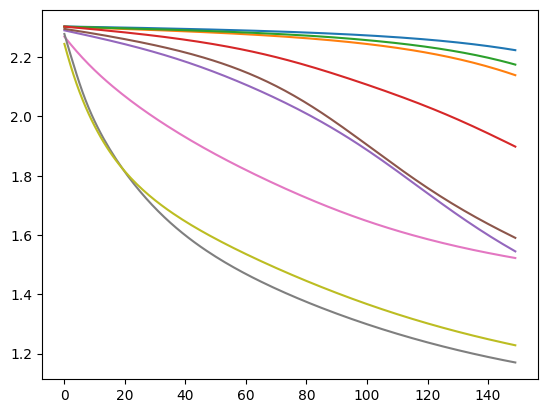

In [ ]:
for task in range(num_task):
    print(f"Loss for task: {task} is {loss_ewc[task]}")
    print(f"Loss for task: {task} is {loss_si[task]}")
    print(f"Loss for task: {task} is {loss_l1l2[task]}")
    print(f"Loss for task: {task} is {loss_baseline[task]}")

In [ ]:
for task in range(num_task):
    print(f"Accuracy for task: {task} is {acc_ewc[task]}")
    print(f"Accuracy for task: {task} is {acc_si[task]}")
    print(f"Accuracy for task: {task} is {acc_l1l2[task]}")
    print(f"Accuracy for task: {task} is {acc_baseline[task]}")

Accuracy for task: 0 is [tensor(0.0893), tensor(0.0893), tensor(0.0895), tensor(0.0897), tensor(0.0900), tensor(0.0902), tensor(0.0905), tensor(0.0905), tensor(0.0910), tensor(0.0915), tensor(0.0923), tensor(0.0929), tensor(0.0949), tensor(0.0974), tensor(0.1005), tensor(0.1028), tensor(0.1066), tensor(0.1105), tensor(0.1156), tensor(0.1231), tensor(0.1320), tensor(0.1415), tensor(0.1525), tensor(0.1641), tensor(0.1772), tensor(0.1896), tensor(0.2016), tensor(0.2158), tensor(0.2273), tensor(0.2371), tensor(0.2452), tensor(0.2525), tensor(0.2598), tensor(0.2659), tensor(0.2722), tensor(0.2791), tensor(0.2847), tensor(0.2883), tensor(0.2919), tensor(0.2946), tensor(0.2997), tensor(0.3049), tensor(0.3076), tensor(0.3093), tensor(0.3111), tensor(0.3126), tensor(0.3146), tensor(0.3165), tensor(0.3175), tensor(0.3192), tensor(0.3209), tensor(0.3225), tensor(0.3239), tensor(0.3252), tensor(0.3276), tensor(0.3290), tensor(0.3307), tensor(0.3323), tensor(0.3340), tensor(0.3351), tensor(0.3363),

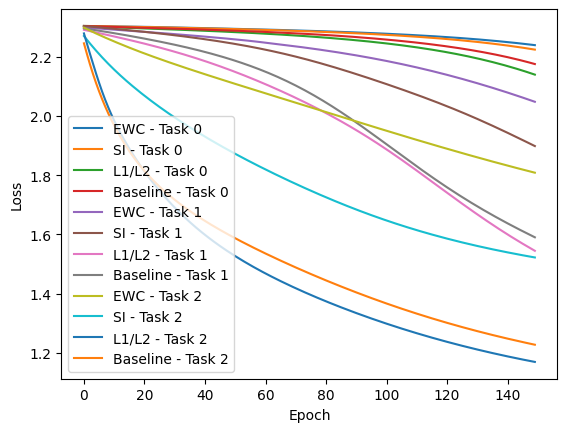

In [ ]:
# Plot Loss
for task in range(num_task):
    plt.plot(loss_ewc[task], label=f'EWC - Task {task}')
    plt.plot(loss_si[task], label=f'SI - Task {task}')
    plt.plot(loss_l1l2[task], label=f'L1/L2 - Task {task}')
    plt.plot(loss_baseline[task], label=f'Baseline - Task {task}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

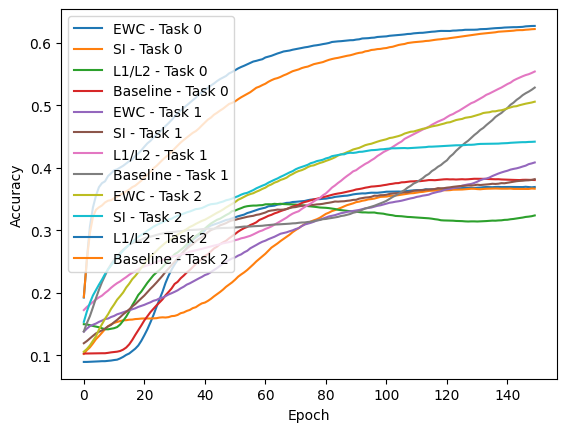

In [ ]:
# Plot Accuracy
for task in range(num_task):
    plt.plot(acc_ewc[task], label=f'EWC - Task {task}')
    plt.plot(acc_si[task], label=f'SI - Task {task}')
    plt.plot(acc_l1l2[task], label=f'L1/L2 - Task {task}')
    plt.plot(acc_baseline[task], label=f'Baseline - Task {task}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

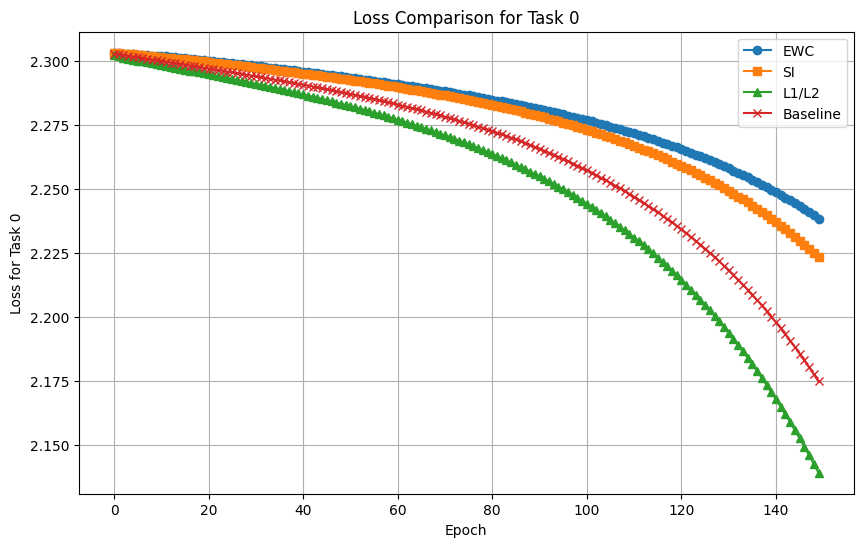

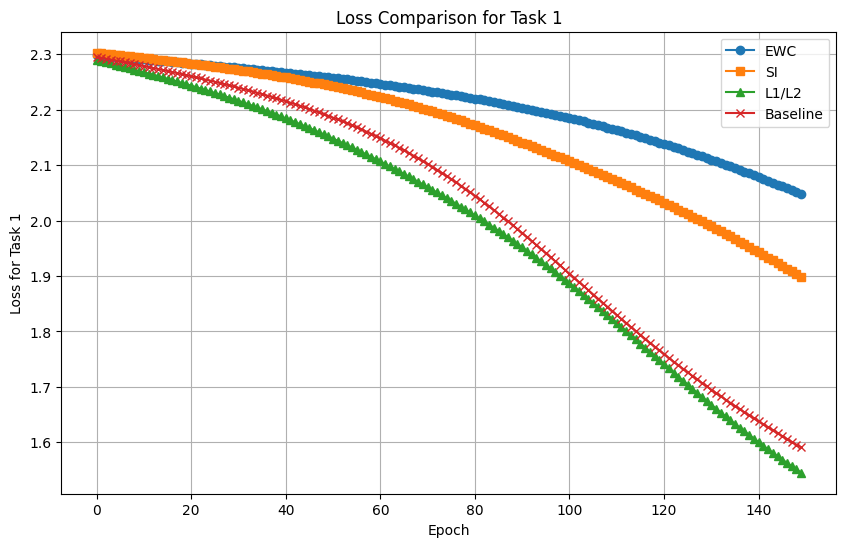

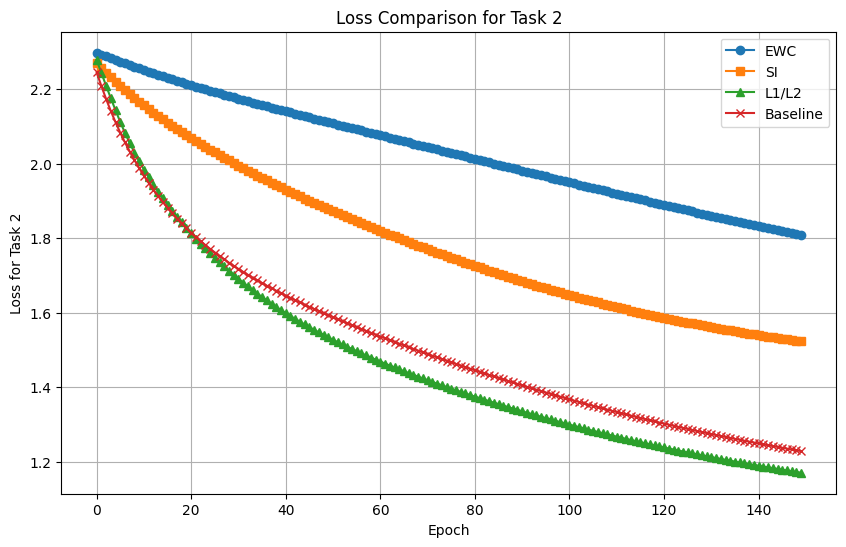

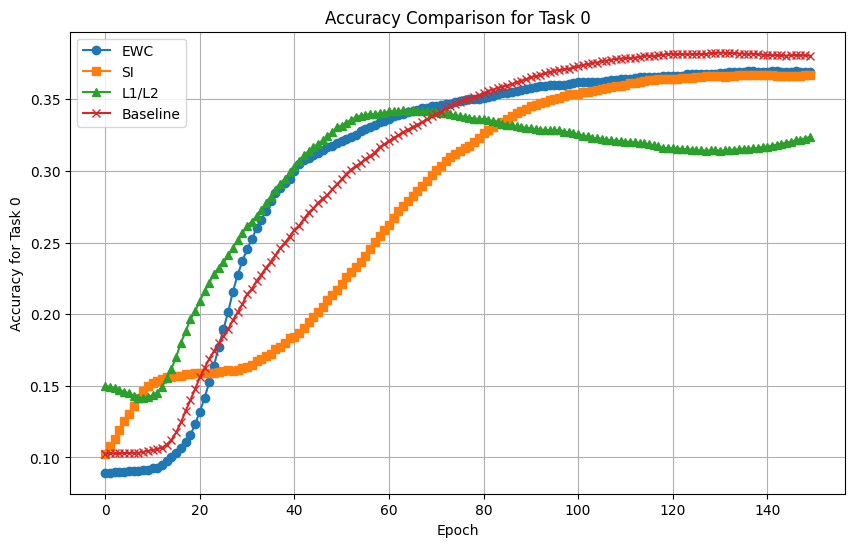

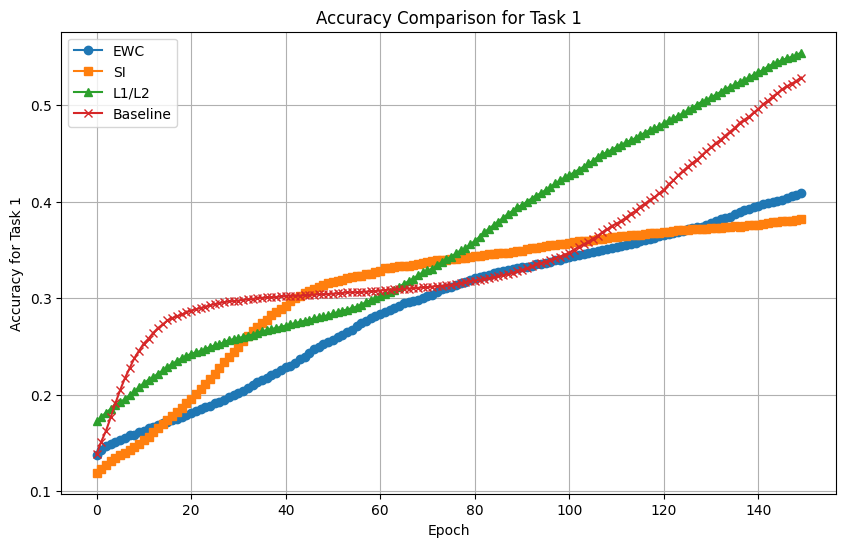

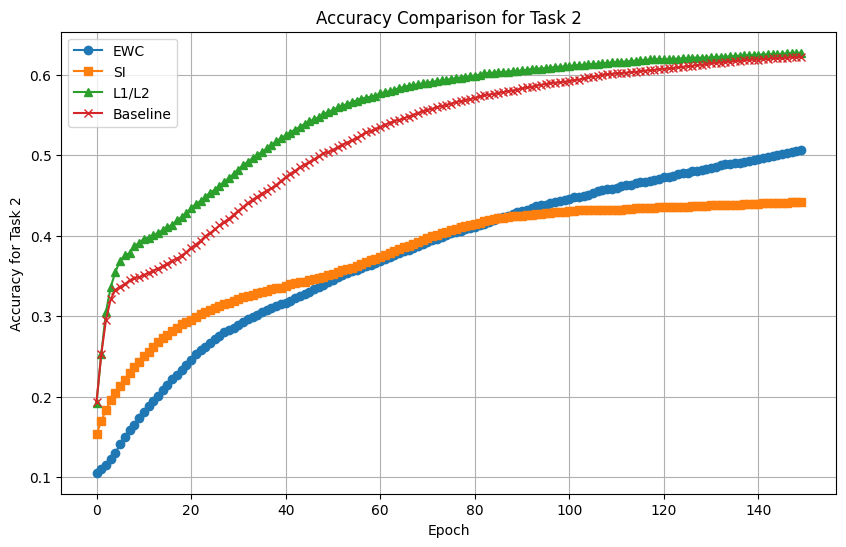

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Assuming num_task is the number of tasks
num_task = len(loss_ewc)  # This should match the number of tasks in your experiment

# Plot Loss for each task with different regularization methods
for task in range(num_task):
    plt.figure(figsize=(10, 6))  # Create a new figure for each task
    plt.plot(loss_ewc[task], label='EWC', linestyle='-', marker='o')
    plt.plot(loss_si[task], label='SI', linestyle='-', marker='s')
    plt.plot(loss_l1l2[task], label='L1/L2', linestyle='-', marker='^')
    plt.plot(loss_baseline[task], label='Baseline', linestyle='-', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel(f'Loss for Task {task}')
    plt.title(f'Loss Comparison for Task {task}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Accuracy for each task with different regularization methods
for task in range(num_task):
    plt.figure(figsize=(10, 6))  # Create a new figure for each task
    plt.plot(acc_ewc[task], label='EWC', linestyle='-', marker='o')
    plt.plot(acc_si[task], label='SI', linestyle='-', marker='s')
    plt.plot(acc_l1l2[task], label='L1/L2', linestyle='-', marker='^')
    plt.plot(acc_baseline[task], label='Baseline', linestyle='-', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel(f'Accuracy for Task {task}')
    plt.title(f'Accuracy Comparison for Task {task}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Print final losses for all tasks using all regularization methods
print("Final Losses for all tasks:")
for task in range(num_task):
    print(f"Task {task}:")
    print(f"  EWC Loss: {loss_ewc[task][-1]:.4f}")
    print(f"  SI Loss: {loss_si[task][-1]:.4f}")
    print(f"  L1/L2 Loss: {loss_l1l2[task][-1]:.4f}")
    print(f"  Baseline Loss: {loss_baseline[task][-1]:.4f}")

# Print final accuracies for all tasks using all regularization methods
print("\nFinal Accuracies for all tasks:")
for task in range(num_task):
    print(f"Task {task}:")
    print(f"  EWC Accuracy: {acc_ewc[task][-1]:.4f}")
    print(f"  SI Accuracy: {acc_si[task][-1]:.4f}")
    print(f"  L1/L2 Accuracy: {acc_l1l2[task][-1]:.4f}")
    print(f"  Baseline Accuracy: {acc_baseline[task][-1]:.4f}")

Final Losses for all tasks:
Task 0:
  EWC Loss: 2.2384
  SI Loss: 2.2234
  L1/L2 Loss: 2.1390
  Baseline Loss: 2.1747
Task 1:
  EWC Loss: 2.0475
  SI Loss: 1.8982
  L1/L2 Loss: 1.5449
  Baseline Loss: 1.5905
Task 2:
  EWC Loss: 1.8083
  SI Loss: 1.5225
  L1/L2 Loss: 1.1703
  Baseline Loss: 1.2282

Final Accuracies for all tasks:
Task 0:
  EWC Accuracy: 0.3693
  SI Accuracy: 0.3666
  L1/L2 Accuracy: 0.3238
  Baseline Accuracy: 0.3805
Task 1:
  EWC Accuracy: 0.4086
  SI Accuracy: 0.3819
  L1/L2 Accuracy: 0.5542
  Baseline Accuracy: 0.5285
Task 2:
  EWC Accuracy: 0.5059
  SI Accuracy: 0.4419
  L1/L2 Accuracy: 0.6272
  Baseline Accuracy: 0.6222
